In [1]:
import os
from glob import glob
from natsort import natsorted
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from time import time
import math
import random
import timm
import torch
from torch.optim import SGD, AdamW, lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

print(torch.__version__)
print(torch.cuda.is_available())
os.chdir('D:/dacon/open')

1.8.1+cu102
True


# 1. EDA

In [2]:
train_list = natsorted(glob('train/*.png'))
test_list = natsorted(glob('test/*.png'))
print(len(train_list))
print(len(test_list))

4277
2154


In [3]:
df_train = pd.read_csv('train_df.csv')
df_train.head()

,index,file_name,class,state,label
0,0,10000.png,transistor,good,transistor-good
1,1,10001.png,capsule,good,capsule-good
2,2,10002.png,transistor,good,transistor-good
3,3,10003.png,wood,good,wood-good
4,4,10004.png,bottle,good,bottle-good


In [4]:
print(len(df_train['class'].unique()))
print(len(df_train.label.unique()))

15
88


In [5]:
label_count = df_train[['class', 'label']].groupby('label').count().rename(columns={'class':'count'})
label_count

,count
label,
bottle-broken_large,10
bottle-broken_small,11
bottle-contamination,11
bottle-good,209
cable-bent_wire,7
cable-cable_swap,6
cable-combined,6
cable-cut_inner_insulation,7
cable-cut_outer_insulation,5


In [6]:
dic = {}
for cls in df_train['class'].unique():
    cls_df = pd.DataFrame(label_count[label_count.index.str.contains(cls)]).sort_values(by='count', ascending=False)
    dic[cls] = cls_df

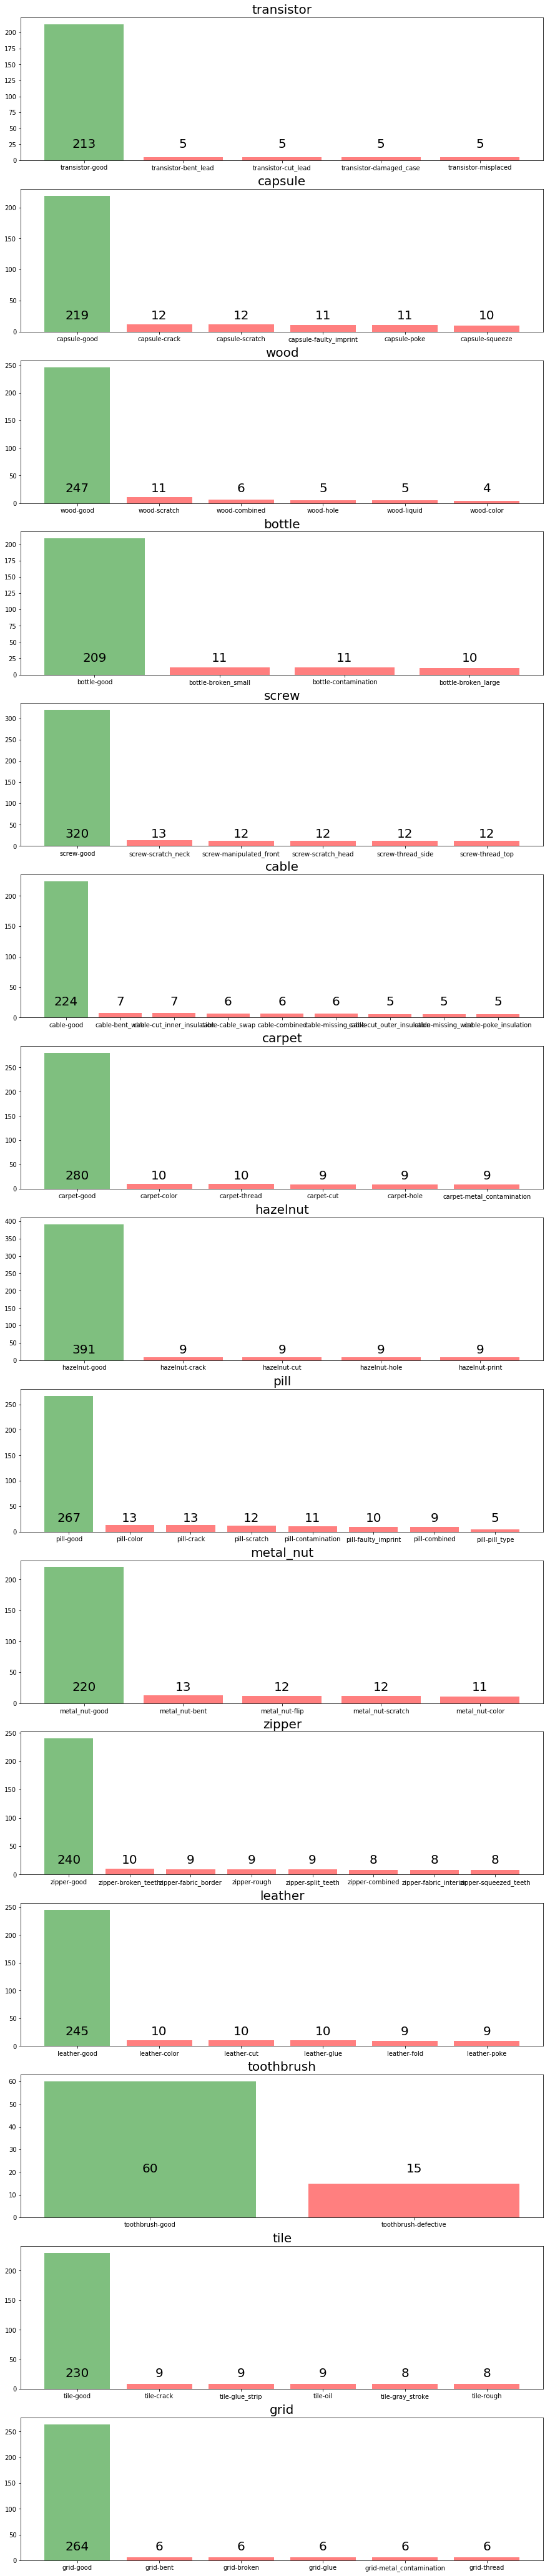

In [7]:
fig, ax = plt.subplots(15, 1, figsize=(15, 15*5))
# fig.subplots_adjust(hspace = .3)
# ax = ax.ravel()

for i, (cls, cls_df) in enumerate(dic.items()):
    colors = ['red']*len(cls_df.index)
    colors[0] = 'green'
    ax[i].bar(cls_df.index, cls_df.iloc[:, 0], color=colors, alpha=0.5)
    ax[i].set_title(cls, fontsize=20)
    for j, value in enumerate(cls_df.iloc[:, 0]):
        ax[i].text(j, 20, cls_df.iloc[:, 0][j], ha='center', fontsize=20)

In [8]:
# sample = cv2.imread(train_list[0])
# while True:
#     cv2.imshow('sample', sample)
#     key = cv2.waitKey()
#     if key == 27:
#         break
# cv2.destroyAllWindows()

# 2. Load Data

In [8]:
df_check = df_train[df_train.state != 'good'].sort_values('label')
df_check

,index,file_name,class,state,label
260,260,10260.png,bottle,broken_large,bottle-broken_large
3456,3456,13456.png,bottle,broken_large,bottle-broken_large
1143,1143,11143.png,bottle,broken_large,bottle-broken_large
204,204,10204.png,bottle,broken_large,bottle-broken_large
712,712,10712.png,bottle,broken_large,bottle-broken_large
2253,2253,12253.png,bottle,broken_large,bottle-broken_large
2006,2006,12006.png,bottle,broken_large,bottle-broken_large
839,839,10839.png,bottle,broken_large,bottle-broken_large
1828,1828,11828.png,bottle,broken_large,bottle-broken_large
912,912,10912.png,bottle,broken_large,bottle-broken_large


In [9]:
for cls in df_check['class'].unique():
    n = int(df_check[df_check['class']==cls].label.value_counts().max() * 1.5)
    df_check = pd.concat([df_check, df_train[(df_train.state == 'good') & (df_train['class']==cls)].sample(n=n, replace=True)])
df_check

,index,file_name,class,state,label
260,260,10260.png,bottle,broken_large,bottle-broken_large
3456,3456,13456.png,bottle,broken_large,bottle-broken_large
1143,1143,11143.png,bottle,broken_large,bottle-broken_large
204,204,10204.png,bottle,broken_large,bottle-broken_large
712,712,10712.png,bottle,broken_large,bottle-broken_large
2253,2253,12253.png,bottle,broken_large,bottle-broken_large
2006,2006,12006.png,bottle,broken_large,bottle-broken_large
839,839,10839.png,bottle,broken_large,bottle-broken_large
1828,1828,11828.png,bottle,broken_large,bottle-broken_large
912,912,10912.png,bottle,broken_large,bottle-broken_large


In [10]:
df_dic = {}
for cls in df_check['class'].unique():
    cls_df = df_check[df_check['class']==cls].sort_values('state')
    df_dic[cls] = cls_df

In [11]:
df_dic['transistor']

,index,file_name,class,state,label
3752,3752,13752.png,transistor,bent_lead,transistor-bent_lead
144,144,10144.png,transistor,bent_lead,transistor-bent_lead
2353,2353,12353.png,transistor,bent_lead,transistor-bent_lead
2355,2355,12355.png,transistor,bent_lead,transistor-bent_lead
4248,4248,14248.png,transistor,bent_lead,transistor-bent_lead
3776,3776,13776.png,transistor,cut_lead,transistor-cut_lead
3159,3159,13159.png,transistor,cut_lead,transistor-cut_lead
2904,2904,12904.png,transistor,cut_lead,transistor-cut_lead
1449,1449,11449.png,transistor,cut_lead,transistor-cut_lead
3015,3015,13015.png,transistor,cut_lead,transistor-cut_lead


In [12]:
cls_encoder = {key:value for value, key in enumerate(sorted(df_check["class"].unique()))}
cls_decoder = {value:key for value, key in enumerate(sorted(df_check["class"].unique()))}
train_cls = [cls_encoder[k] for k in df_check["class"]]
df_check['cls_code'] = train_cls
df_check

,index,file_name,class,state,label,cls_code
260,260,10260.png,bottle,broken_large,bottle-broken_large,0
3456,3456,13456.png,bottle,broken_large,bottle-broken_large,0
1143,1143,11143.png,bottle,broken_large,bottle-broken_large,0
204,204,10204.png,bottle,broken_large,bottle-broken_large,0
712,712,10712.png,bottle,broken_large,bottle-broken_large,0
2253,2253,12253.png,bottle,broken_large,bottle-broken_large,0
2006,2006,12006.png,bottle,broken_large,bottle-broken_large,0
839,839,10839.png,bottle,broken_large,bottle-broken_large,0
1828,1828,11828.png,bottle,broken_large,bottle-broken_large,0
912,912,10912.png,bottle,broken_large,bottle-broken_large,0


In [14]:
cls_encoder

{'bottle': 0,
 'cable': 1,
 'capsule': 2,
 'carpet': 3,
 'grid': 4,
 'hazelnut': 5,
 'leather': 6,
 'metal_nut': 7,
 'pill': 8,
 'screw': 9,
 'tile': 10,
 'toothbrush': 11,
 'transistor': 12,
 'wood': 13,
 'zipper': 14}

In [15]:
train_set, val_set = train_test_split(df_check, test_size = 0.2, random_state=42, stratify=df_check.label)

In [16]:
print(len(train_set.label.unique()))
print(len(val_set.label.unique()))

88
88


In [35]:
def img_load(path):
    img = cv2.imread(path)
    shape = img.shape
    img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_AREA)
    return img, shape

In [18]:
train_list = [f'train/{x}' for x in train_set.file_name]
val_list = [f'train/{x}' for x in val_set.file_name]

In [19]:
train_shapes = []
train_imgs = []
for img in tqdm(train_list):
    img, shape = img_load(img)
    train_imgs.append(img)
    train_shapes.append(shape)

100%|████████████████████████████████████████████████████████████████████████████████| 699/699 [00:26<00:00, 26.50it/s]


In [20]:
# check size
df_shape = pd.DataFrame(train_shapes)
df_shape[0].value_counts()

1024    430
800      73
1000     60
700      54
840      43
900      39
Name: 0, dtype: int64

In [21]:
df_shape[1].value_counts()

1024    430
800      73
1000     60
700      54
840      43
900      39
Name: 1, dtype: int64

In [22]:
val_imgs = []
for img in tqdm(val_list):
    img, _ = img_load(img)
    val_imgs.append(img)

100%|████████████████████████████████████████████████████████████████████████████████| 175/175 [00:06<00:00, 27.13it/s]


In [36]:
test_imgs = []
for img in tqdm(test_list):
    img, _ = img_load(img)
    test_imgs.append(img)

100%|██████████████████████████████████████████████████████████████████████████████| 2154/2154 [01:08<00:00, 31.42it/s]


In [24]:
def augmentation(img, degrees=90, translate=0.1, scale=0.1, shear=5):

    height, width, _ = img.shape

    # Center
    C = np.eye(3)
    C[0, 2] = -width / 2
    C[1, 2] = -height / 2 

    # Rotation and Scale
    R = np.eye(3)
    a = random.uniform(-degrees, degrees)
    s = random.uniform(1 - scale, 1 + scale)
    R[:2] = cv2.getRotationMatrix2D(angle=a, center=(0, 0), scale=s)

    # Shear
    S = np.eye(3)
    S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)
    S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)

    # Translation
    T = np.eye(3)
    T[0, 2] = random.uniform(0.5 - translate, 0.5 + translate) * width
    T[1, 2] = random.uniform(0.5 - translate, 0.5 + translate) * height

    # Combined rotation matrix
    M = T @ S @ R @ C  # 순서 중요!
    img = cv2.warpAffine(img, M[:2], dsize=(width, height))

    return img

In [13]:
class Custom_dataset(Dataset):
    def __init__(self, img_paths, labels, mode='train'):
        self.img_paths = img_paths
        self.labels = labels
        self.mode=mode
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        img = self.img_paths[idx]
        if self.mode != 'test':
            img = augmentation(img)
            if label not in [7]:
                if random.random() < 0.5:
                    img = img[::-1]  # flip_ud
                if random.random() < 0.5:
                    img = img[:,::-1]  # flip_lr
        img = transforms.ToTensor()(img.copy())        
        return img, label

In [14]:
class Network(nn.Module):
    def __init__(self, num_classes=88):
        super(Network, self).__init__()
        self.model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=num_classes)
        
    def forward(self, x):
        x = self.model(x)
        return x

# 3. 모델링
## 1차모델 : 클래스분류

In [37]:
batch_size=32

In [28]:
train_dataset = Custom_dataset(np.array(train_imgs), np.array(train_set.cls_code), mode='train')
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

In [29]:
val_dataset = Custom_dataset(np.array(val_imgs), np.array(val_set.cls_code), mode='val')
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size)

In [38]:
test_dataset = Custom_dataset(np.array(test_imgs), np.array(["tmp"]*len(test_imgs)), mode='test')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [29]:
def score_function(real, pred):
    score = f1_score(real, pred, average="macro")
    return score

In [32]:
epochs = 3
device = torch.device('cuda')
model = Network(num_classes=len(df_check.cls_code.unique())).to(device)
optimizer = SGD(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
best=0
for epoch in range(epochs):
    train_start=time()
    train_loss = 0
    train_pred=[]
    train_y=[]
    model.train()
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        x = torch.tensor(batch[0], dtype=torch.float32, device=device)
        y = torch.tensor(batch[1], dtype=torch.long, device=device)
        with torch.cuda.amp.autocast():
            pred = model(x)
        loss = criterion(pred, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()/len(train_loader)
        train_pred += pred.argmax(1).detach().cpu().numpy().tolist()
        train_y += y.detach().cpu().numpy().tolist()  
        
    train_f1 = score_function(train_y, train_pred)
    torch.save(model, 'last.pt')
    
    TIME = time() - train_start
    print(f'epoch : {epoch+1}/{epochs}    time : {TIME:.0f}s')
    print(f'TRAIN    loss : {train_loss:.5f}    f1 : {train_f1:.5f}')
    
    val_start = time()
    val_pred = []
    val_y = []
    model.eval()

    with torch.no_grad():
        for batch in tqdm(val_loader):
            x = torch.tensor(batch[0], dtype = torch.float32, device = device)
            y = torch.tensor(batch[1], dtype=torch.long, device=device)
            with torch.cuda.amp.autocast():
                pred = model(x)
            val_pred += pred.argmax(1).detach().cpu().numpy().tolist()
            val_y += y.detach().cpu().numpy().tolist()
    
    val_f1 = score_function(val_y, val_pred)
    
    TIME = time() - val_start
    print(f'VAL    f1 : {val_f1:.5f}    time : {TIME:.0f}s')
    
    if val_f1 > best:
        torch.save(model, 'best.pt')
        best = val_f1
    
#     if best > 0.999:
#         break

  0%|                                                                                           | 0/22 [00:00<?, ?it/s]D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:56<00:00,  2.56s/it]


epoch : 1/3    time : 56s
TRAIN    loss : 1.32999    f1 : 0.65950


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.88s/it]
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


VAL    f1 : 0.23430    time : 17s


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:18<00:00,  3.56s/it]


epoch : 2/3    time : 78s
TRAIN    loss : 0.09884    f1 : 0.99197


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.51s/it]


VAL    f1 : 0.96854    time : 15s


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:25<00:00,  3.88s/it]


epoch : 3/3    time : 86s
TRAIN    loss : 0.04472    f1 : 0.99603


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.56s/it]

VAL    f1 : 1.00000    time : 15s


## 2차모델 : 상태분류

In [33]:
def img_load(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_AREA)
    return img

In [34]:
class Custom_dataset(Dataset):
    def __init__(self, img_paths, labels, mode='train', flip=True):
        self.img_paths = img_paths
        self.labels = labels
        self.mode=mode
        self.flip = flip
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        img = self.img_paths[idx]
        if self.mode != 'test':
            img = augmentation(img)
            if self.flip:
                if random.random() < 0.5:
                    img = img[::-1]  # flip_ud
                if random.random() < 0.5:
                    img = img[:,::-1]  # flip_lr
        img = transforms.ToTensor()(img.copy())        
        return img, label

In [35]:
df_check['class'].unique()

array(['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut',
       'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush',
       'transistor', 'wood', 'zipper'], dtype=object)

In [36]:
df_dic = {}
for cls in tqdm(sorted(df_check['class'].unique())):
    # make dataframe for classes
    cls_df = df_check[df_check['class']==cls].sort_values('state')
    globals()[f'cls_encoder_{cls}'] = {key:value for value, key in enumerate(sorted(cls_df.state.unique()))}
    globals()[f'cls_decoder_{cls}'] = {value:key for value, key in enumerate(sorted(cls_df.state.unique()))}
    cls_df['state_code'] = [globals()[f'cls_encoder_{cls}'][k] for k in cls_df["state"]]
    df_dic[cls] = cls_df
    
    # split data
    globals()[f'train_set_{cls}'], globals()[f'val_set_{cls}'] = train_test_split(cls_df, test_size = 0.2,
                                                                                  random_state=42, stratify=cls_df.state)
    
    # check split
    print(f'train_{cls}', len(globals()[f'train_set_{cls}'].label.unique()))
    print(f'val_{cls}', len(globals()[f'val_set_{cls}'].label.unique()))
    
    # file_name
    train_list = [f'train/{x}' for x in globals()[f'train_set_{cls}'].file_name]
    val_list = [f'train/{x}' for x in globals()[f'val_set_{cls}'].file_name]
    
    # load images
    train_imgs = [img_load(file) for file in train_list]
    val_imgs = [img_load(file) for file in val_list]
    
    # dataset & dataloader
    train_dataset = Custom_dataset(np.array(train_imgs), np.array(globals()[f'train_set_{cls}'].state_code), mode='train',
                                   flip = False if cls == 'metal_nut' else True)
    globals()[f'train_loader_{cls}'] = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_dataset = Custom_dataset(np.array(val_imgs), np.array(globals()[f'val_set_{cls}'].state_code), mode='val',
                                flip = False if cls == 'metal_nut' else True)
    globals()[f'val_loader_{cls}'] = DataLoader(val_dataset, shuffle=True, batch_size=batch_size)

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train_bottle 4
val_bottle 4


  7%|█████▌                                                                             | 1/15 [00:01<00:19,  1.38s/it]

train_cable 9
val_cable 9


 13%|███████████                                                                        | 2/15 [00:03<00:23,  1.78s/it]

train_capsule 6
val_capsule 6


 20%|████████████████▌                                                                  | 3/15 [00:06<00:26,  2.23s/it]

train_carpet 6
val_carpet 6


 27%|██████████████████████▏                                                            | 4/15 [00:08<00:24,  2.26s/it]

train_grid 6
val_grid 6


 33%|███████████████████████████▋                                                       | 5/15 [00:09<00:17,  1.75s/it]

train_hazelnut 5
val_hazelnut 5


 40%|█████████████████████████████████▏                                                 | 6/15 [00:11<00:15,  1.73s/it]

train_leather 6
val_leather 6


 47%|██████████████████████████████████████▋                                            | 7/15 [00:13<00:14,  1.87s/it]

train_metal_nut 5
val_metal_nut 5


 53%|████████████████████████████████████████████▎                                      | 8/15 [00:14<00:11,  1.70s/it]

train_pill 8
val_pill 8


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [00:16<00:11,  1.87s/it]

train_screw 6
val_screw 6


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [00:18<00:09,  1.84s/it]

train_tile 6
val_tile 6


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [00:20<00:07,  1.76s/it]

train_toothbrush 2
val_toothbrush 2


 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [00:21<00:04,  1.61s/it]

train_transistor 5
val_transistor 5


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [00:22<00:02,  1.41s/it]

train_wood 6
val_wood 6


 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [00:24<00:01,  1.50s/it]

train_zipper 8
val_zipper 8


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:25<00:00,  1.72s/it]


In [37]:
for cls in sorted(df_check['class'].unique()):
    print('============================================================================================================')
    print(cls)
    epochs = 300
    device = torch.device('cuda:0')
    model = Network(num_classes=len(df_dic[cls].state.unique())).to(device)
    optimizer = AdamW(model.parameters())
    criterion = nn.CrossEntropyLoss()
    scaler = torch.cuda.amp.GradScaler()
    lf = lambda x: ((1 - math.cos(x * math.pi / epochs)) / 2) * (0.01 - 1) + 1
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
    best=0
    for epoch in range tqdm(epochs):
        train_start=time()
        train_loss = 0
        train_pred=[]
        train_y=[]
        model.train()
        for batch in globals()[f'train_loader_{cls}']:
            optimizer.zero_grad()
            x = torch.tensor(batch[0], dtype=torch.float32, device=device)
            y = torch.tensor(batch[1], dtype=torch.long, device=device)
            with torch.cuda.amp.autocast():
                pred = model(x)
            loss = criterion(pred, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()/len(train_loader)
            train_pred += pred.argmax(1).detach().cpu().numpy().tolist()
            train_y += y.detach().cpu().numpy().tolist()  

        train_f1 = score_function(train_y, train_pred)
        torch.save(model, f'{cls}_last.pt')

        TIME = time() - train_start
        print(f'epoch : {epoch+1}/{epochs}    time : {TIME:.0f}s')
        print(f'TRAIN    loss : {train_loss:.5f}    f1 : {train_f1:.5f}')

        val_start = time()
        val_pred = []
        val_y = []
        model.eval()

        with torch.no_grad():
            for batch in tqdm(globals()[f'val_loader_{cls}']):
                x = torch.tensor(batch[0], dtype = torch.float32, device = device)
                y = torch.tensor(batch[1], dtype=torch.long, device=device)
                with torch.cuda.amp.autocast():
                    pred = model(x)
                val_pred += pred.argmax(1).detach().cpu().numpy().tolist()
                val_y += y.detach().cpu().numpy().tolist()

        val_f1 = score_function(val_y, val_pred)

        TIME = time() - val_start
        print(f'VAL    f1 : {val_f1:.5f}    time : {TIME:.0f}s')

        if val_f1 > best:
            torch.save(model, f'{cls}_best.pt')
            best = val_f1

        if best > 0.999:
            break
        
        scheduler.step()

    print(f'Best {cls} : {best}')

bottle


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.34s/it]


epoch : 1/300    time : 3s
TRAIN    loss : 0.26012    f1 : 0.11438


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\t

VAL    f1 : 0.15385    time : 1s
0.15384615384615383


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.20s/it]


epoch : 2/300    time : 8s
TRAIN    loss : 0.17254    f1 : 0.27171


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


VAL    f1 : 0.15385    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.42s/it]


epoch : 3/300    time : 5s
TRAIN    loss : 0.09450    f1 : 0.63562


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


VAL    f1 : 0.16667    time : 2s
0.16666666666666663


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.86s/it]


epoch : 4/300    time : 4s
TRAIN    loss : 0.04372    f1 : 0.86456


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


VAL    f1 : 0.50000    time : 2s
0.5


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.40s/it]


epoch : 5/300    time : 5s
TRAIN    loss : 0.06718    f1 : 0.82209


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


VAL    f1 : 0.43182    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.57s/it]


epoch : 6/300    time : 5s
TRAIN    loss : 0.00394    f1 : 0.97214


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


VAL    f1 : 0.36667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.07s/it]


epoch : 7/300    time : 6s
TRAIN    loss : 0.01136    f1 : 0.94952


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


VAL    f1 : 0.36667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.32s/it]


epoch : 8/300    time : 5s
TRAIN    loss : 0.00044    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


VAL    f1 : 0.55556    time : 0s
0.5555555555555556


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.18s/it]


epoch : 9/300    time : 3s
TRAIN    loss : 0.00861    f1 : 0.94752


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


VAL    f1 : 0.37500    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]


epoch : 10/300    time : 3s
TRAIN    loss : 0.00300    f1 : 0.97214


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


VAL    f1 : 0.26667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.32s/it]


epoch : 11/300    time : 7s
TRAIN    loss : 0.04098    f1 : 0.94746


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


VAL    f1 : 0.31250    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.36s/it]


epoch : 12/300    time : 3s
TRAIN    loss : 0.11741    f1 : 0.91147


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


VAL    f1 : 0.67222    time : 0s
0.6722222222222223


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.19s/it]


epoch : 13/300    time : 4s
TRAIN    loss : 0.08683    f1 : 0.83583


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.81s/it]


VAL    f1 : 0.70000    time : 2s
0.7


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.09it/s]


epoch : 14/300    time : 2s
TRAIN    loss : 0.00878    f1 : 0.97018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.40s/it]


epoch : 15/300    time : 3s
TRAIN    loss : 0.12128    f1 : 0.86005


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


VAL    f1 : 0.54722    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


epoch : 16/300    time : 5s
TRAIN    loss : 0.02798    f1 : 0.94746


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


VAL    f1 : 0.61667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/it]


epoch : 17/300    time : 2s
TRAIN    loss : 0.18342    f1 : 0.82796


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.25s/it]


VAL    f1 : 0.88889    time : 2s
0.8888888888888888


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.74s/it]


epoch : 18/300    time : 4s
TRAIN    loss : 0.00412    f1 : 0.97597


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


VAL    f1 : 0.38182    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.74s/it]


epoch : 19/300    time : 4s
TRAIN    loss : 0.10842    f1 : 0.86375


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


VAL    f1 : 0.38182    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.71s/it]


epoch : 20/300    time : 4s
TRAIN    loss : 0.02447    f1 : 0.88156


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.86s/it]


VAL    f1 : 0.33036    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.71s/it]


epoch : 21/300    time : 4s
TRAIN    loss : 0.09980    f1 : 0.82802


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


VAL    f1 : 0.52381    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.87s/it]


epoch : 22/300    time : 4s
TRAIN    loss : 0.21129    f1 : 0.79532


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.59s/it]


VAL    f1 : 0.55556    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.02s/it]


epoch : 23/300    time : 4s
TRAIN    loss : 0.00097    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


VAL    f1 : 0.76389    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.81s/it]


epoch : 24/300    time : 4s
TRAIN    loss : 0.24139    f1 : 0.88189


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


VAL    f1 : 0.67222    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.83s/it]


epoch : 25/300    time : 4s
TRAIN    loss : 0.07557    f1 : 0.87882


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.34s/it]


epoch : 26/300    time : 3s
TRAIN    loss : 0.10303    f1 : 0.92156


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


VAL    f1 : 0.36667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.32s/it]


epoch : 27/300    time : 3s
TRAIN    loss : 0.07136    f1 : 0.94588


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


VAL    f1 : 0.35417    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.74s/it]


epoch : 28/300    time : 4s
TRAIN    loss : 0.00329    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


VAL    f1 : 0.68095    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.27s/it]


epoch : 29/300    time : 3s
TRAIN    loss : 0.07810    f1 : 0.86331


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


VAL    f1 : 0.52143    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.46s/it]


epoch : 30/300    time : 3s
TRAIN    loss : 0.01269    f1 : 0.94281


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.06s/it]


epoch : 31/300    time : 4s
TRAIN    loss : 0.09313    f1 : 0.87052


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


VAL    f1 : 0.68750    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.99s/it]


epoch : 32/300    time : 6s
TRAIN    loss : 0.02692    f1 : 0.88969


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


VAL    f1 : 0.75556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.75s/it]


epoch : 33/300    time : 4s
TRAIN    loss : 0.15690    f1 : 0.85798


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


VAL    f1 : 0.59848    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.68s/it]


epoch : 34/300    time : 3s
TRAIN    loss : 0.01662    f1 : 0.94940


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


VAL    f1 : 0.58333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]


epoch : 35/300    time : 2s
TRAIN    loss : 0.04938    f1 : 0.89762


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.78it/s]


VAL    f1 : 0.29167    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.71s/it]


epoch : 36/300    time : 4s
TRAIN    loss : 0.01533    f1 : 0.92011


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


VAL    f1 : 0.47348    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.12s/it]


epoch : 37/300    time : 4s
TRAIN    loss : 0.05627    f1 : 0.92011


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


VAL    f1 : 0.29167    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.71s/it]


epoch : 38/300    time : 6s
TRAIN    loss : 0.00387    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  3.00s/it]


VAL    f1 : 0.45000    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.72s/it]


epoch : 39/300    time : 4s
TRAIN    loss : 0.07190    f1 : 0.97529


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.61s/it]


VAL    f1 : 0.45833    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.76s/it]


epoch : 40/300    time : 6s
TRAIN    loss : 0.02406    f1 : 0.97529


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.90s/it]


VAL    f1 : 0.36250    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.12s/it]


epoch : 41/300    time : 4s
TRAIN    loss : 0.32142    f1 : 0.77500


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


VAL    f1 : 0.78095    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.08s/it]


epoch : 42/300    time : 6s
TRAIN    loss : 0.00801    f1 : 0.92489


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


VAL    f1 : 0.60952    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.19s/it]


epoch : 43/300    time : 2s
TRAIN    loss : 0.07638    f1 : 0.95130


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


VAL    f1 : 0.46786    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.37s/it]


epoch : 44/300    time : 5s
TRAIN    loss : 0.06879    f1 : 0.97529


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


VAL    f1 : 0.86667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.48s/it]


epoch : 45/300    time : 5s
TRAIN    loss : 0.03844    f1 : 0.92627


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.86s/it]


VAL    f1 : 0.67917    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.21s/it]


epoch : 46/300    time : 3s
TRAIN    loss : 0.00461    f1 : 0.97059


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


VAL    f1 : 0.49286    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.68s/it]


epoch : 47/300    time : 3s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.18s/it]


VAL    f1 : 0.37500    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.87s/it]


epoch : 48/300    time : 4s
TRAIN    loss : 0.02409    f1 : 0.97529


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


VAL    f1 : 0.49167    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.14s/it]


epoch : 49/300    time : 4s
TRAIN    loss : 0.06936    f1 : 0.94941


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


VAL    f1 : 0.60952    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.89s/it]


epoch : 50/300    time : 4s
TRAIN    loss : 0.00740    f1 : 0.95227


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]


VAL    f1 : 0.49167    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.05s/it]


epoch : 51/300    time : 2s
TRAIN    loss : 0.03204    f1 : 0.92792


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


VAL    f1 : 0.35476    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.78s/it]


epoch : 52/300    time : 4s
TRAIN    loss : 0.02906    f1 : 0.92156


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


VAL    f1 : 0.66667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.24s/it]


epoch : 53/300    time : 3s
TRAIN    loss : 0.00278    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.27it/s]


epoch : 54/300    time : 2s
TRAIN    loss : 0.01010    f1 : 0.94942


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.92s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.77s/it]


epoch : 55/300    time : 6s
TRAIN    loss : 0.00110    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]


epoch : 56/300    time : 3s
TRAIN    loss : 0.00373    f1 : 0.97059


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.12it/s]


epoch : 57/300    time : 2s
TRAIN    loss : 0.03367    f1 : 0.94089


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.82s/it]


epoch : 58/300    time : 4s
TRAIN    loss : 0.00557    f1 : 0.97018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.78s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.02s/it]


epoch : 59/300    time : 4s
TRAIN    loss : 0.00012    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.94s/it]


epoch : 60/300    time : 4s
TRAIN    loss : 0.00674    f1 : 0.97018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.26s/it]


epoch : 61/300    time : 3s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.57it/s]


epoch : 62/300    time : 1s
TRAIN    loss : 0.01416    f1 : 0.97018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


VAL    f1 : 0.70000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]


epoch : 63/300    time : 3s
TRAIN    loss : 0.03204    f1 : 0.97597


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


VAL    f1 : 0.66667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.24s/it]


epoch : 64/300    time : 5s
TRAIN    loss : 0.01419    f1 : 0.93929


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.34s/it]


epoch : 65/300    time : 3s
TRAIN    loss : 0.00376    f1 : 0.94588


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]


VAL    f1 : 0.55556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.20s/it]


epoch : 66/300    time : 2s
TRAIN    loss : 0.08240    f1 : 0.91222


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


VAL    f1 : 0.75556    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.66s/it]


epoch : 67/300    time : 3s
TRAIN    loss : 0.06650    f1 : 0.91827


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


VAL    f1 : 0.53333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.93s/it]


epoch : 68/300    time : 4s
TRAIN    loss : 0.02603    f1 : 0.92431


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


VAL    f1 : 0.75556    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.93s/it]


epoch : 69/300    time : 4s
TRAIN    loss : 0.07975    f1 : 0.87882


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


VAL    f1 : 0.75000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.42s/it]


epoch : 70/300    time : 5s
TRAIN    loss : 0.08165    f1 : 0.87121


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


VAL    f1 : 0.55556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.23s/it]


epoch : 71/300    time : 3s
TRAIN    loss : 0.09162    f1 : 0.97018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.30s/it]


epoch : 72/300    time : 3s
TRAIN    loss : 0.01260    f1 : 0.93797


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.62s/it]


VAL    f1 : 0.56667    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.62s/it]


epoch : 73/300    time : 5s
TRAIN    loss : 0.00031    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.05s/it]


epoch : 74/300    time : 2s
TRAIN    loss : 0.00843    f1 : 0.94097


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.92it/s]

VAL    f1 : 0.36667    time : 0s



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]


epoch : 75/300    time : 3s
TRAIN    loss : 0.01622    f1 : 0.87857


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]


epoch : 76/300    time : 3s
TRAIN    loss : 0.01528    f1 : 0.94656


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.49s/it]


VAL    f1 : 0.55556    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.57s/it]


epoch : 77/300    time : 3s
TRAIN    loss : 0.00554    f1 : 0.97597


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.03s/it]


epoch : 78/300    time : 6s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.70s/it]


epoch : 79/300    time : 4s
TRAIN    loss : 0.00019    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


VAL    f1 : 0.75556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/it]


epoch : 80/300    time : 3s
TRAIN    loss : 0.00017    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.88s/it]


epoch : 81/300    time : 4s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


VAL    f1 : 0.75556    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.00s/it]


epoch : 82/300    time : 2s
TRAIN    loss : 0.02345    f1 : 0.97597


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


VAL    f1 : 0.55556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.18s/it]


epoch : 83/300    time : 2s
TRAIN    loss : 0.00626    f1 : 0.97018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.66it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.85s/it]


epoch : 84/300    time : 4s
TRAIN    loss : 0.00008    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.00it/s]


epoch : 85/300    time : 2s
TRAIN    loss : 0.00045    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.37s/it]


epoch : 86/300    time : 3s
TRAIN    loss : 0.00422    f1 : 0.97059


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.24s/it]


epoch : 87/300    time : 3s
TRAIN    loss : 0.00403    f1 : 0.97059


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.63s/it]


epoch : 88/300    time : 5s
TRAIN    loss : 0.01122    f1 : 0.97018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.78s/it]


epoch : 89/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/it]


epoch : 90/300    time : 2s
TRAIN    loss : 0.00061    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]


epoch : 91/300    time : 3s
TRAIN    loss : 0.01799    f1 : 0.97059


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.86s/it]


epoch : 92/300    time : 4s
TRAIN    loss : 0.00206    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.09it/s]


epoch : 93/300    time : 2s
TRAIN    loss : 0.00009    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.96s/it]


epoch : 94/300    time : 4s
TRAIN    loss : 0.37441    f1 : 0.87560


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.97s/it]


epoch : 95/300    time : 4s
TRAIN    loss : 0.04844    f1 : 0.90731


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.39s/it]


epoch : 96/300    time : 5s
TRAIN    loss : 0.02266    f1 : 0.91222


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


VAL    f1 : 0.32051    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/it]


epoch : 97/300    time : 3s
TRAIN    loss : 0.09595    f1 : 0.86880


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.80s/it]


VAL    f1 : 0.50000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.18s/it]


epoch : 98/300    time : 5s
TRAIN    loss : 0.02307    f1 : 0.92222


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


VAL    f1 : 0.50000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.68s/it]


epoch : 99/300    time : 3s
TRAIN    loss : 0.03440    f1 : 0.97529


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


VAL    f1 : 0.60833    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.46s/it]


epoch : 100/300    time : 3s
TRAIN    loss : 0.02508    f1 : 0.82949


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


VAL    f1 : 0.60119    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.71s/it]


epoch : 101/300    time : 4s
TRAIN    loss : 0.03731    f1 : 0.90088


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]


VAL    f1 : 0.60119    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.16s/it]


epoch : 102/300    time : 3s
TRAIN    loss : 0.03607    f1 : 0.94941


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.26s/it]


VAL    f1 : 0.51667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.57s/it]


epoch : 103/300    time : 7s
TRAIN    loss : 0.00219    f1 : 0.97442


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


VAL    f1 : 0.53333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.32s/it]


epoch : 104/300    time : 3s
TRAIN    loss : 0.00820    f1 : 0.95227


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


VAL    f1 : 0.60952    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.21s/it]


epoch : 105/300    time : 3s
TRAIN    loss : 0.06437    f1 : 0.97597


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


VAL    f1 : 0.70000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.32it/s]


epoch : 106/300    time : 2s
TRAIN    loss : 0.00703    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


VAL    f1 : 0.67917    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.33s/it]


epoch : 107/300    time : 5s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


VAL    f1 : 0.67917    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.43it/s]


epoch : 108/300    time : 1s
TRAIN    loss : 0.01991    f1 : 0.94940


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


VAL    f1 : 0.67917    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.48s/it]


epoch : 109/300    time : 5s
TRAIN    loss : 0.00102    f1 : 0.97018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.15it/s]


epoch : 110/300    time : 2s
TRAIN    loss : 0.01848    f1 : 0.97529


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


VAL    f1 : 0.55556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.17s/it]


epoch : 111/300    time : 4s
TRAIN    loss : 0.00246    f1 : 0.97018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.20s/it]


epoch : 112/300    time : 2s
TRAIN    loss : 0.00010    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.16s/it]


VAL    f1 : 0.56667    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.30s/it]


epoch : 113/300    time : 3s
TRAIN    loss : 0.00020    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


VAL    f1 : 0.53333    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.85s/it]


epoch : 114/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


VAL    f1 : 0.52083    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.34s/it]


epoch : 115/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.22s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.22s/it]


epoch : 116/300    time : 5s
TRAIN    loss : 0.00008    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


VAL    f1 : 0.75556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]


epoch : 117/300    time : 3s
TRAIN    loss : 0.00034    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.09it/s]


epoch : 118/300    time : 2s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.12s/it]


VAL    f1 : 0.78095    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.32it/s]


epoch : 119/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.31it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.65s/it]


epoch : 120/300    time : 3s
TRAIN    loss : 0.05837    f1 : 0.94656


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


VAL    f1 : 0.67917    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.80s/it]


epoch : 121/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


VAL    f1 : 0.67917    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.77s/it]


epoch : 122/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.95s/it]


VAL    f1 : 0.67917    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.12s/it]


epoch : 123/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]


VAL    f1 : 0.78095    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]


epoch : 124/300    time : 2s
TRAIN    loss : 0.00008    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.31it/s]


VAL    f1 : 0.67917    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.31s/it]


epoch : 125/300    time : 3s
TRAIN    loss : 0.00071    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


VAL    f1 : 0.67917    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.36s/it]


epoch : 126/300    time : 5s
TRAIN    loss : 0.28806    f1 : 0.89092


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


VAL    f1 : 0.66429    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:16<00:00,  8.32s/it]


epoch : 127/300    time : 17s
TRAIN    loss : 0.00852    f1 : 0.97018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.34s/it]


VAL    f1 : 0.79762    time : 4s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.30s/it]


epoch : 128/300    time : 3s
TRAIN    loss : 0.00571    f1 : 0.97597


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.23s/it]


VAL    f1 : 0.62500    time : 5s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]


epoch : 129/300    time : 2s
TRAIN    loss : 0.07252    f1 : 0.93929


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.69it/s]


VAL    f1 : 0.19643    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.51it/s]


epoch : 130/300    time : 1s
TRAIN    loss : 0.00907    f1 : 0.97597


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.69it/s]


VAL    f1 : 0.35119    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.45it/s]


epoch : 131/300    time : 1s
TRAIN    loss : 0.01226    f1 : 0.92217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


VAL    f1 : 0.41250    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.95it/s]


epoch : 132/300    time : 1s
TRAIN    loss : 0.07597    f1 : 0.94375


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


VAL    f1 : 0.51667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:19<00:00,  9.57s/it]


epoch : 133/300    time : 19s
TRAIN    loss : 0.03099    f1 : 0.97529


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.81s/it]


VAL    f1 : 0.75556    time : 5s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:17<00:00,  8.99s/it]


epoch : 134/300    time : 18s
TRAIN    loss : 0.00870    f1 : 0.97059


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.94s/it]


VAL    f1 : 0.50000    time : 4s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:18<00:00,  9.38s/it]


epoch : 135/300    time : 19s
TRAIN    loss : 0.00128    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.65s/it]


VAL    f1 : 0.47348    time : 6s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:17<00:00,  8.58s/it]


epoch : 136/300    time : 17s
TRAIN    loss : 0.07739    f1 : 0.95227


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.34s/it]


VAL    f1 : 0.60417    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:12<00:00,  6.17s/it]


epoch : 137/300    time : 12s
TRAIN    loss : 0.00041    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.64s/it]


epoch : 138/300    time : 3s
TRAIN    loss : 0.01715    f1 : 0.94547


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


VAL    f1 : 0.59848    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.02it/s]


epoch : 139/300    time : 2s
TRAIN    loss : 0.00014    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]


VAL    f1 : 0.59848    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.37s/it]


epoch : 140/300    time : 3s
TRAIN    loss : 0.00342    f1 : 0.97529


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.76it/s]


epoch : 141/300    time : 1s
TRAIN    loss : 0.00417    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


VAL    f1 : 0.59848    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.39it/s]


epoch : 142/300    time : 2s
TRAIN    loss : 0.00076    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


VAL    f1 : 0.66667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.32s/it]


epoch : 143/300    time : 3s
TRAIN    loss : 0.12995    f1 : 0.97059


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.88it/s]


epoch : 144/300    time : 1s
TRAIN    loss : 0.00223    f1 : 0.97018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


VAL    f1 : 0.51667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.26s/it]


epoch : 145/300    time : 3s
TRAIN    loss : 0.02635    f1 : 0.88529


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.28it/s]


VAL    f1 : 0.30682    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.22s/it]


epoch : 146/300    time : 3s
TRAIN    loss : 0.02708    f1 : 0.91176


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


VAL    f1 : 0.47348    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.08it/s]


epoch : 147/300    time : 2s
TRAIN    loss : 0.01005    f1 : 0.94097


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.39it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.20s/it]


epoch : 148/300    time : 3s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


VAL    f1 : 0.67917    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.28it/s]


epoch : 149/300    time : 2s
TRAIN    loss : 0.00015    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.28it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.20s/it]


epoch : 150/300    time : 2s
TRAIN    loss : 0.03629    f1 : 0.94556


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


VAL    f1 : 0.53333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.30it/s]


epoch : 151/300    time : 2s
TRAIN    loss : 0.00206    f1 : 0.97018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/it]


epoch : 152/300    time : 2s
TRAIN    loss : 0.00422    f1 : 0.97018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.68it/s]


VAL    f1 : 0.70000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.23s/it]


epoch : 153/300    time : 3s
TRAIN    loss : 0.00217    f1 : 0.97018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.60it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.31s/it]


epoch : 154/300    time : 3s
TRAIN    loss : 0.00086    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]


epoch : 155/300    time : 3s
TRAIN    loss : 0.01257    f1 : 0.97597


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]


epoch : 156/300    time : 3s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.62it/s]


VAL    f1 : 0.70000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.18s/it]


epoch : 157/300    time : 2s
TRAIN    loss : 0.02827    f1 : 0.92245


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]


epoch : 158/300    time : 2s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.70it/s]


epoch : 159/300    time : 1s
TRAIN    loss : 0.00093    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.60it/s]


VAL    f1 : 0.55556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/it]


epoch : 160/300    time : 2s
TRAIN    loss : 0.00026    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.32it/s]


epoch : 161/300    time : 2s
TRAIN    loss : 0.00186    f1 : 0.97018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.59it/s]


VAL    f1 : 0.55556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/it]


epoch : 162/300    time : 2s
TRAIN    loss : 0.00031    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.52it/s]


VAL    f1 : 0.70000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.06it/s]


epoch : 163/300    time : 2s
TRAIN    loss : 0.00502    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


VAL    f1 : 0.55556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.39it/s]


epoch : 164/300    time : 2s
TRAIN    loss : 0.00799    f1 : 0.97529


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


VAL    f1 : 0.55556    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.76s/it]


epoch : 165/300    time : 4s
TRAIN    loss : 0.01387    f1 : 0.97529


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


VAL    f1 : 0.55556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.62s/it]


epoch : 166/300    time : 3s
TRAIN    loss : 0.00089    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.15s/it]


epoch : 167/300    time : 2s
TRAIN    loss : 0.00038    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.97it/s]


VAL    f1 : 0.55556    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.65it/s]


epoch : 168/300    time : 1s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


VAL    f1 : 0.55556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.47it/s]


epoch : 169/300    time : 2s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]


epoch : 170/300    time : 3s
TRAIN    loss : 0.00048    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.80it/s]


epoch : 171/300    time : 1s
TRAIN    loss : 0.04670    f1 : 0.97529


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.35s/it]


epoch : 172/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.48it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.66s/it]


epoch : 173/300    time : 3s
TRAIN    loss : 0.00070    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.87it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.33s/it]


epoch : 174/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.06it/s]


epoch : 175/300    time : 2s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]


VAL    f1 : 0.55556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.58s/it]


epoch : 176/300    time : 9s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


VAL    f1 : 0.55556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.19it/s]


epoch : 177/300    time : 2s
TRAIN    loss : 0.00017    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


VAL    f1 : 0.55556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.34s/it]


epoch : 178/300    time : 3s
TRAIN    loss : 0.00779    f1 : 0.97018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.43it/s]


VAL    f1 : 0.75000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]


epoch : 179/300    time : 3s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


VAL    f1 : 0.75000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/it]


epoch : 180/300    time : 2s
TRAIN    loss : 0.06339    f1 : 0.97018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.15s/it]


epoch : 181/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


VAL    f1 : 0.70000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.33it/s]


epoch : 182/300    time : 1s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


VAL    f1 : 0.70000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.25s/it]


epoch : 183/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.53it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.52it/s]


epoch : 184/300    time : 1s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.05it/s]


VAL    f1 : 0.88889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/it]


epoch : 185/300    time : 2s
TRAIN    loss : 0.00026    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.47it/s]


VAL    f1 : 0.70000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.19it/s]


epoch : 186/300    time : 1s
TRAIN    loss : 0.00022    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


VAL    f1 : 0.67222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/it]


epoch : 187/300    time : 2s
TRAIN    loss : 0.00123    f1 : 0.97059


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.56it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.35s/it]


epoch : 188/300    time : 3s
TRAIN    loss : 0.00037    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.66it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]


epoch : 189/300    time : 2s
TRAIN    loss : 0.00471    f1 : 0.97059


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.06it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.37it/s]


epoch : 190/300    time : 2s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


VAL    f1 : 0.67222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]


epoch : 191/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/it]


epoch : 192/300    time : 2s
TRAIN    loss : 0.05190    f1 : 0.94089


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.28it/s]


VAL    f1 : 0.67222    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.26it/s]


epoch : 193/300    time : 1s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.40it/s]

VAL    f1 : 0.67222    time : 0s



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.15s/it]


epoch : 194/300    time : 2s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.41it/s]


epoch : 195/300    time : 1s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.06it/s]


epoch : 196/300    time : 2s
TRAIN    loss : 0.00008    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.18s/it]


epoch : 197/300    time : 2s
TRAIN    loss : 0.00008    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.40it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.08it/s]


epoch : 198/300    time : 1s
TRAIN    loss : 0.00012    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:30<00:00, 15.02s/it]


epoch : 199/300    time : 30s
TRAIN    loss : 0.18963    f1 : 0.94952


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.29s/it]


VAL    f1 : 0.56667    time : 20s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:41<00:00, 20.59s/it]


epoch : 200/300    time : 42s
TRAIN    loss : 0.00015    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.38s/it]


VAL    f1 : 0.56667    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]


epoch : 201/300    time : 6s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]


epoch : 202/300    time : 3s
TRAIN    loss : 0.00244    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]


epoch : 203/300    time : 3s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.93s/it]


epoch : 204/300    time : 6s
TRAIN    loss : 0.00053    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.90s/it]


epoch : 205/300    time : 4s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]


epoch : 206/300    time : 3s
TRAIN    loss : 0.00011    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.50s/it]


epoch : 207/300    time : 5s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.22s/it]


epoch : 208/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.81s/it]


epoch : 209/300    time : 4s
TRAIN    loss : 0.00008    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]


epoch : 210/300    time : 3s
TRAIN    loss : 0.00057    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


VAL    f1 : 0.55556    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]


epoch : 211/300    time : 3s
TRAIN    loss : 0.00103    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.79s/it]


epoch : 212/300    time : 4s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.60it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.88s/it]


epoch : 213/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


VAL    f1 : 0.75556    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.95s/it]


epoch : 214/300    time : 4s
TRAIN    loss : 0.00016    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.95s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.99s/it]


epoch : 215/300    time : 4s
TRAIN    loss : 0.00025    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.00it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.24s/it]


epoch : 216/300    time : 7s
TRAIN    loss : 0.00051    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.64it/s]

VAL    f1 : 0.55556    time : 0s



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.20s/it]


epoch : 217/300    time : 3s
TRAIN    loss : 0.00292    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


VAL    f1 : 0.55556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.01s/it]


epoch : 218/300    time : 6s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


VAL    f1 : 0.55556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]


epoch : 219/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.34s/it]


epoch : 220/300    time : 5s
TRAIN    loss : 0.00027    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.80s/it]


VAL    f1 : 0.53333    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.07s/it]


epoch : 221/300    time : 6s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.19s/it]


epoch : 222/300    time : 4s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.73it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.23s/it]


epoch : 223/300    time : 3s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.87s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.66s/it]


epoch : 224/300    time : 3s
TRAIN    loss : 0.00034    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.75s/it]


epoch : 225/300    time : 4s
TRAIN    loss : 0.00042    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.57s/it]


epoch : 226/300    time : 3s
TRAIN    loss : 0.00011    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.28s/it]


epoch : 227/300    time : 5s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]


epoch : 228/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.11s/it]


epoch : 229/300    time : 4s
TRAIN    loss : 0.00429    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.45it/s]


epoch : 230/300    time : 1s
TRAIN    loss : 0.00186    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.04s/it]


epoch : 231/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


VAL    f1 : 0.55556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.61s/it]


epoch : 232/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.68s/it]


epoch : 233/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


VAL    f1 : 0.55556    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.46s/it]


epoch : 234/300    time : 5s
TRAIN    loss : 0.00045    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.12s/it]


epoch : 235/300    time : 4s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.62s/it]


epoch : 236/300    time : 5s
TRAIN    loss : 0.00064    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


VAL    f1 : 0.55556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.93s/it]


epoch : 237/300    time : 4s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.71s/it]


epoch : 238/300    time : 4s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.17it/s]


epoch : 239/300    time : 2s
TRAIN    loss : 0.00016    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


VAL    f1 : 0.55556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.17s/it]


epoch : 240/300    time : 2s
TRAIN    loss : 0.00035    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


VAL    f1 : 0.55556    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.11s/it]


epoch : 241/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.04it/s]


epoch : 242/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.24s/it]


epoch : 243/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.20s/it]


epoch : 244/300    time : 3s
TRAIN    loss : 0.00009    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.30s/it]


epoch : 245/300    time : 7s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]


epoch : 246/300    time : 2s
TRAIN    loss : 0.00010    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.03s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.28s/it]


epoch : 247/300    time : 5s
TRAIN    loss : 0.03613    f1 : 0.94097


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.49s/it]


epoch : 248/300    time : 5s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


VAL    f1 : 0.55556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.81s/it]


epoch : 249/300    time : 4s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


VAL    f1 : 0.55556    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.77s/it]


epoch : 250/300    time : 4s
TRAIN    loss : 0.00023    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.41s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.36s/it]


epoch : 251/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]


epoch : 252/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.63s/it]


epoch : 253/300    time : 3s
TRAIN    loss : 0.04246    f1 : 0.97018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.22it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/it]


epoch : 254/300    time : 3s
TRAIN    loss : 0.00706    f1 : 0.97059


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.81s/it]


epoch : 255/300    time : 4s
TRAIN    loss : 0.13956    f1 : 0.93929


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.86s/it]


epoch : 256/300    time : 4s
TRAIN    loss : 0.00210    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.18it/s]


epoch : 257/300    time : 2s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.50s/it]


VAL    f1 : 0.55556    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]


epoch : 258/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.03s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.73s/it]


epoch : 259/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]


epoch : 260/300    time : 3s
TRAIN    loss : 0.00060    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


VAL    f1 : 0.55556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.15s/it]


epoch : 261/300    time : 2s
TRAIN    loss : 0.00827    f1 : 0.97018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]


epoch : 262/300    time : 3s
TRAIN    loss : 0.00119    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.22s/it]


VAL    f1 : 0.55556    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/it]


epoch : 263/300    time : 2s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.33s/it]


epoch : 264/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


VAL    f1 : 0.55556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.05s/it]


epoch : 265/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


VAL    f1 : 0.67222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.15s/it]


epoch : 266/300    time : 2s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


VAL    f1 : 0.67222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.17it/s]


epoch : 267/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]


epoch : 268/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


VAL    f1 : 0.56667    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.86s/it]


epoch : 269/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.22s/it]


epoch : 270/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.57it/s]


epoch : 271/300    time : 1s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]


epoch : 272/300    time : 2s
TRAIN    loss : 0.00947    f1 : 0.97214


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]


epoch : 273/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]


VAL    f1 : 0.55556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.68s/it]


epoch : 274/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.95s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]


epoch : 275/300    time : 3s
TRAIN    loss : 0.00019    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.42s/it]


epoch : 276/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.55it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.17it/s]


epoch : 277/300    time : 2s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]


epoch : 278/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


VAL    f1 : 0.55556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.20s/it]


epoch : 279/300    time : 2s
TRAIN    loss : 0.00014    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.54s/it]


epoch : 280/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]


epoch : 281/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.40s/it]


epoch : 282/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.39it/s]


epoch : 283/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.75s/it]


epoch : 284/300    time : 4s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.62s/it]


epoch : 285/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.76s/it]


epoch : 286/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/it]


epoch : 287/300    time : 2s
TRAIN    loss : 0.00822    f1 : 0.97597


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.18it/s]


epoch : 288/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.23s/it]


epoch : 289/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.71s/it]


epoch : 290/300    time : 6s
TRAIN    loss : 0.00011    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.04it/s]


epoch : 291/300    time : 2s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.02s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.76s/it]


epoch : 292/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.82s/it]


epoch : 293/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.31s/it]


epoch : 294/300    time : 7s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.91s/it]


epoch : 295/300    time : 4s
TRAIN    loss : 0.00018    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.11s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.18s/it]


epoch : 296/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


VAL    f1 : 0.55556    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/it]


epoch : 297/300    time : 2s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.19s/it]


epoch : 298/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.46s/it]


epoch : 299/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/it]


epoch : 300/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


VAL    f1 : 0.55556    time : 2s
cable


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.50s/it]


epoch : 1/300    time : 5s
TRAIN    loss : 0.25861    f1 : 0.05096


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


VAL    f1 : 0.02020    time : 1s
0.0202020202020202


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.91s/it]


epoch : 2/300    time : 4s
TRAIN    loss : 0.18066    f1 : 0.33489


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.10s/it]


VAL    f1 : 0.06349    time : 2s
0.06349206349206349


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]


epoch : 3/300    time : 2s
TRAIN    loss : 0.09164    f1 : 0.65042


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


VAL    f1 : 0.04938    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.09s/it]


epoch : 4/300    time : 4s
TRAIN    loss : 0.08083    f1 : 0.72528


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


VAL    f1 : 0.11448    time : 2s
0.11447811447811447


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]


epoch : 5/300    time : 3s
TRAIN    loss : 0.01527    f1 : 0.95286


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.01s/it]


VAL    f1 : 0.03419    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.85s/it]


epoch : 6/300    time : 4s
TRAIN    loss : 0.04431    f1 : 0.86420


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.32s/it]


VAL    f1 : 0.08333    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.41s/it]


epoch : 7/300    time : 5s
TRAIN    loss : 0.00907    f1 : 0.97755


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


VAL    f1 : 0.17037    time : 1s
0.17037037037037037


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.79s/it]


epoch : 8/300    time : 4s
TRAIN    loss : 0.02087    f1 : 0.95780


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


VAL    f1 : 0.09259    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.67s/it]


epoch : 9/300    time : 4s
TRAIN    loss : 0.00325    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


VAL    f1 : 0.09428    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.70s/it]


epoch : 10/300    time : 4s
TRAIN    loss : 0.01370    f1 : 0.98249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.04s/it]


VAL    f1 : 0.16835    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.35s/it]


epoch : 11/300    time : 3s
TRAIN    loss : 0.01231    f1 : 0.95370


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


VAL    f1 : 0.20741    time : 2s
0.2074074074074074


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.37s/it]


epoch : 12/300    time : 3s
TRAIN    loss : 0.01322    f1 : 0.98112


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


VAL    f1 : 0.20741    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.49s/it]


epoch : 13/300    time : 5s
TRAIN    loss : 0.00213    f1 : 0.98112


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


VAL    f1 : 0.28704    time : 1s
0.287037037037037


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.87s/it]


epoch : 14/300    time : 4s
TRAIN    loss : 0.00059    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


VAL    f1 : 0.16667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.85s/it]


epoch : 15/300    time : 4s
TRAIN    loss : 0.00967    f1 : 0.98249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


VAL    f1 : 0.16667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]


epoch : 16/300    time : 3s
TRAIN    loss : 0.01605    f1 : 0.98112


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


VAL    f1 : 0.20000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.12s/it]


epoch : 17/300    time : 4s
TRAIN    loss : 0.00046    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


VAL    f1 : 0.20000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.46s/it]


epoch : 18/300    time : 5s
TRAIN    loss : 0.00130    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


VAL    f1 : 0.18519    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.25s/it]


epoch : 19/300    time : 3s
TRAIN    loss : 0.04685    f1 : 0.96004


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]


VAL    f1 : 0.20000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]


epoch : 20/300    time : 3s
TRAIN    loss : 0.01902    f1 : 0.95652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


VAL    f1 : 0.17460    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]


epoch : 21/300    time : 2s
TRAIN    loss : 0.00474    f1 : 0.98112


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


VAL    f1 : 0.38519    time : 0s
0.3851851851851852


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.32s/it]


epoch : 22/300    time : 3s
TRAIN    loss : 0.00900    f1 : 0.95000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]


VAL    f1 : 0.38889    time : 2s
0.3888888888888889


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.23s/it]


epoch : 23/300    time : 3s
TRAIN    loss : 0.00231    f1 : 0.98112


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


VAL    f1 : 0.31852    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.12s/it]


epoch : 24/300    time : 4s
TRAIN    loss : 0.00583    f1 : 0.98112


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]


VAL    f1 : 0.55185    time : 3s
0.5518518518518518


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.74s/it]


epoch : 25/300    time : 4s
TRAIN    loss : 0.00198    f1 : 0.97759


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.80s/it]


VAL    f1 : 0.35185    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.17s/it]


epoch : 26/300    time : 4s
TRAIN    loss : 0.01332    f1 : 0.95514


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]


VAL    f1 : 0.43333    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.28s/it]


epoch : 27/300    time : 5s
TRAIN    loss : 0.00161    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]


VAL    f1 : 0.43915    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.46s/it]


epoch : 28/300    time : 3s
TRAIN    loss : 0.02552    f1 : 0.93795


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.28s/it]


VAL    f1 : 0.33333    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.01s/it]


epoch : 29/300    time : 2s
TRAIN    loss : 0.02279    f1 : 0.93364


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


VAL    f1 : 0.21111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.82s/it]


epoch : 30/300    time : 4s
TRAIN    loss : 0.00130    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


VAL    f1 : 0.20988    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.54s/it]


epoch : 31/300    time : 3s
TRAIN    loss : 0.01200    f1 : 0.92755


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


VAL    f1 : 0.34286    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.71s/it]


epoch : 32/300    time : 4s
TRAIN    loss : 0.05216    f1 : 0.93881


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


VAL    f1 : 0.56296    time : 1s
0.5629629629629629


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.39s/it]


epoch : 33/300    time : 5s
TRAIN    loss : 0.00630    f1 : 0.97759


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


VAL    f1 : 0.64815    time : 1s
0.6481481481481481


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.25s/it]


epoch : 34/300    time : 3s
TRAIN    loss : 0.02297    f1 : 0.96168


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.94s/it]


VAL    f1 : 0.38519    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.57it/s]


epoch : 35/300    time : 1s
TRAIN    loss : 0.00960    f1 : 0.97403


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


VAL    f1 : 0.47778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.46s/it]


epoch : 36/300    time : 7s
TRAIN    loss : 0.00188    f1 : 0.98249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


VAL    f1 : 0.43386    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.48s/it]


epoch : 37/300    time : 5s
TRAIN    loss : 0.00251    f1 : 0.97403


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


VAL    f1 : 0.48148    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.24s/it]


epoch : 38/300    time : 5s
TRAIN    loss : 0.02613    f1 : 0.95944


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.31s/it]


VAL    f1 : 0.57037    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.08s/it]


epoch : 39/300    time : 6s
TRAIN    loss : 0.00734    f1 : 0.95780


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.90s/it]


VAL    f1 : 0.60741    time : 4s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.30s/it]


epoch : 40/300    time : 3s
TRAIN    loss : 0.00023    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


VAL    f1 : 0.58889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.84s/it]


epoch : 41/300    time : 4s
TRAIN    loss : 0.00597    f1 : 0.97531


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.09s/it]


VAL    f1 : 0.39683    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.93s/it]


epoch : 42/300    time : 4s
TRAIN    loss : 0.00144    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.29s/it]


VAL    f1 : 0.35185    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.37s/it]


epoch : 43/300    time : 5s
TRAIN    loss : 0.00486    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


VAL    f1 : 0.42222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.16s/it]


epoch : 44/300    time : 4s
TRAIN    loss : 0.00050    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


VAL    f1 : 0.48148    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]


epoch : 45/300    time : 3s
TRAIN    loss : 0.00065    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.80s/it]


VAL    f1 : 0.66667    time : 3s
0.6666666666666666


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.68s/it]


epoch : 46/300    time : 3s
TRAIN    loss : 0.00226    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


VAL    f1 : 0.68148    time : 1s
0.6814814814814815


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.61s/it]


epoch : 47/300    time : 3s
TRAIN    loss : 0.00042    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.44s/it]


VAL    f1 : 0.58889    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.76s/it]


epoch : 48/300    time : 6s
TRAIN    loss : 0.00009    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.78s/it]


VAL    f1 : 0.68148    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.83s/it]


epoch : 49/300    time : 4s
TRAIN    loss : 0.00709    f1 : 0.97531


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


VAL    f1 : 0.52222    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]


epoch : 50/300    time : 3s
TRAIN    loss : 0.01214    f1 : 0.98025


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.75s/it]


VAL    f1 : 0.46296    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.81s/it]


epoch : 51/300    time : 4s
TRAIN    loss : 0.01255    f1 : 0.96004


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


VAL    f1 : 0.47778    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.87s/it]


epoch : 52/300    time : 4s
TRAIN    loss : 0.00095    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


VAL    f1 : 0.61111    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.02s/it]


epoch : 53/300    time : 4s
TRAIN    loss : 0.00091    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]


VAL    f1 : 0.33333    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.80s/it]


epoch : 54/300    time : 4s
TRAIN    loss : 0.00111    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


VAL    f1 : 0.64815    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.92s/it]


epoch : 55/300    time : 6s
TRAIN    loss : 0.00288    f1 : 0.97403


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.41s/it]


VAL    f1 : 0.42593    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.02s/it]


epoch : 56/300    time : 6s
TRAIN    loss : 0.00131    f1 : 0.97755


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


VAL    f1 : 0.68148    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.63s/it]


epoch : 57/300    time : 3s
TRAIN    loss : 0.00208    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


VAL    f1 : 0.50000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.19s/it]


epoch : 58/300    time : 2s
TRAIN    loss : 0.00060    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


VAL    f1 : 0.55556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.14s/it]


epoch : 59/300    time : 4s
TRAIN    loss : 0.00011    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


VAL    f1 : 0.61111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  2.00s/it]


epoch : 60/300    time : 4s
TRAIN    loss : 0.00282    f1 : 0.97755


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


VAL    f1 : 0.71852    time : 0s
0.7185185185185186


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.16s/it]


epoch : 61/300    time : 4s
TRAIN    loss : 0.00074    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


VAL    f1 : 0.62593    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.33it/s]


epoch : 62/300    time : 2s
TRAIN    loss : 0.00712    f1 : 0.97755


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]


VAL    f1 : 0.62593    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.67s/it]


epoch : 63/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


VAL    f1 : 0.60741    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.02s/it]


epoch : 64/300    time : 4s
TRAIN    loss : 0.00177    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.36s/it]


VAL    f1 : 0.51852    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/it]


epoch : 65/300    time : 3s
TRAIN    loss : 0.00019    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


VAL    f1 : 0.53333    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.11s/it]


epoch : 66/300    time : 6s
TRAIN    loss : 0.00317    f1 : 0.97755


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


VAL    f1 : 0.53333    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.81s/it]


epoch : 67/300    time : 4s
TRAIN    loss : 0.00079    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


VAL    f1 : 0.57037    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.41s/it]


epoch : 68/300    time : 3s
TRAIN    loss : 0.00302    f1 : 0.97759


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


VAL    f1 : 0.49630    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.48s/it]


epoch : 69/300    time : 5s
TRAIN    loss : 0.01634    f1 : 0.95286


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


VAL    f1 : 0.60000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.31s/it]


epoch : 70/300    time : 3s
TRAIN    loss : 0.00313    f1 : 0.97755


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


VAL    f1 : 0.55556    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.46s/it]


epoch : 71/300    time : 3s
TRAIN    loss : 0.00470    f1 : 0.97755


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


VAL    f1 : 0.59259    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.54s/it]


epoch : 72/300    time : 3s
TRAIN    loss : 0.00475    f1 : 0.97755


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.46s/it]


VAL    f1 : 0.56296    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.74s/it]


epoch : 73/300    time : 4s
TRAIN    loss : 0.04133    f1 : 0.94321


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


VAL    f1 : 0.44074    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.39s/it]


epoch : 74/300    time : 5s
TRAIN    loss : 0.00027    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.95s/it]


VAL    f1 : 0.62222    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.26it/s]


epoch : 75/300    time : 2s
TRAIN    loss : 0.00026    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


VAL    f1 : 0.60741    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/it]


epoch : 76/300    time : 3s
TRAIN    loss : 0.02678    f1 : 0.90837


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.06it/s]


VAL    f1 : 0.62222    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.81s/it]


epoch : 77/300    time : 4s
TRAIN    loss : 0.02019    f1 : 0.91015


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


VAL    f1 : 0.55185    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.17it/s]


epoch : 78/300    time : 2s
TRAIN    loss : 0.00923    f1 : 0.95537


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/it]


VAL    f1 : 0.44444    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.09it/s]


epoch : 79/300    time : 2s
TRAIN    loss : 0.01040    f1 : 0.97531


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.29s/it]


VAL    f1 : 0.48148    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.13s/it]


epoch : 80/300    time : 6s
TRAIN    loss : 0.00008    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


VAL    f1 : 0.51852    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.28s/it]


epoch : 81/300    time : 3s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.86s/it]


VAL    f1 : 0.59259    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.79s/it]


epoch : 82/300    time : 6s
TRAIN    loss : 0.00031    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


VAL    f1 : 0.77778    time : 1s
0.7777777777777778


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.88s/it]


epoch : 83/300    time : 4s
TRAIN    loss : 0.01288    f1 : 0.97531


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.65it/s]


VAL    f1 : 0.58889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]


epoch : 84/300    time : 3s
TRAIN    loss : 0.01750    f1 : 0.98112


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


VAL    f1 : 0.45926    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


epoch : 85/300    time : 5s
TRAIN    loss : 0.00128    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


VAL    f1 : 0.39683    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.73s/it]


epoch : 86/300    time : 6s
TRAIN    loss : 0.03104    f1 : 0.95158


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.49it/s]


VAL    f1 : 0.40741    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


epoch : 87/300    time : 5s
TRAIN    loss : 0.01115    f1 : 0.97755


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


VAL    f1 : 0.47407    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.46s/it]


epoch : 88/300    time : 3s
TRAIN    loss : 0.00955    f1 : 0.96004


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.96s/it]


VAL    f1 : 0.55185    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.17s/it]


epoch : 89/300    time : 2s
TRAIN    loss : 0.02734    f1 : 0.89418


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


VAL    f1 : 0.41534    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.76s/it]


epoch : 90/300    time : 4s
TRAIN    loss : 0.00374    f1 : 0.95286


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


VAL    f1 : 0.65926    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.22s/it]


epoch : 91/300    time : 3s
TRAIN    loss : 0.00552    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


VAL    f1 : 0.42593    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.23s/it]


epoch : 92/300    time : 5s
TRAIN    loss : 0.00093    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.65it/s]


VAL    f1 : 0.54815    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.42s/it]


epoch : 93/300    time : 3s
TRAIN    loss : 0.00448    f1 : 0.97755


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


VAL    f1 : 0.65926    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.33s/it]


epoch : 94/300    time : 3s
TRAIN    loss : 0.00864    f1 : 0.97531


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.30s/it]


VAL    f1 : 0.62593    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.50s/it]


epoch : 95/300    time : 3s
TRAIN    loss : 0.00106    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


VAL    f1 : 0.57407    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.25s/it]


epoch : 96/300    time : 3s
TRAIN    loss : 0.00014    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


VAL    f1 : 0.70000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]


epoch : 97/300    time : 3s
TRAIN    loss : 0.00299    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


VAL    f1 : 0.57407    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.09s/it]


epoch : 98/300    time : 4s
TRAIN    loss : 0.00086    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.25s/it]


VAL    f1 : 0.57407    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.04s/it]


epoch : 99/300    time : 4s
TRAIN    loss : 0.00121    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


VAL    f1 : 0.61111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.10it/s]


epoch : 100/300    time : 2s
TRAIN    loss : 0.00118    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


VAL    f1 : 0.57407    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.13s/it]


epoch : 101/300    time : 6s
TRAIN    loss : 0.00196    f1 : 0.97403


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


VAL    f1 : 0.68519    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.94s/it]


epoch : 102/300    time : 4s
TRAIN    loss : 0.00200    f1 : 0.97403


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


VAL    f1 : 0.58889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.15s/it]


epoch : 103/300    time : 4s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.28s/it]


VAL    f1 : 0.58889    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.65s/it]


epoch : 104/300    time : 7s
TRAIN    loss : 0.00237    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.65it/s]


VAL    f1 : 0.61905    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.50s/it]


epoch : 105/300    time : 5s
TRAIN    loss : 0.00024    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


VAL    f1 : 0.79259    time : 1s
0.7925925925925925


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.83s/it]


epoch : 106/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.81s/it]


VAL    f1 : 0.79259    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]


epoch : 107/300    time : 3s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


VAL    f1 : 0.61111    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]


epoch : 108/300    time : 3s
TRAIN    loss : 0.00017    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.01s/it]


VAL    f1 : 0.72222    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.74s/it]


epoch : 109/300    time : 4s
TRAIN    loss : 0.00053    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.58s/it]


VAL    f1 : 0.79259    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.53s/it]


epoch : 110/300    time : 5s
TRAIN    loss : 0.01868    f1 : 0.97759


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.40s/it]


VAL    f1 : 0.70000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.61s/it]


epoch : 111/300    time : 3s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


VAL    f1 : 0.77778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.63s/it]


epoch : 112/300    time : 5s
TRAIN    loss : 0.00120    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]


VAL    f1 : 0.68519    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.78s/it]


epoch : 113/300    time : 4s
TRAIN    loss : 0.00191    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.01s/it]


epoch : 114/300    time : 4s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


VAL    f1 : 0.64444    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.14s/it]


epoch : 115/300    time : 4s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]


VAL    f1 : 0.57037    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.18s/it]


epoch : 116/300    time : 4s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


VAL    f1 : 0.58889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.27s/it]


epoch : 117/300    time : 3s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


VAL    f1 : 0.68148    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.48s/it]


epoch : 118/300    time : 5s
TRAIN    loss : 0.00014    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.46s/it]


VAL    f1 : 0.68148    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.01s/it]


epoch : 119/300    time : 4s
TRAIN    loss : 0.00093    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


VAL    f1 : 0.68148    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.25s/it]


epoch : 120/300    time : 3s
TRAIN    loss : 0.00033    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


VAL    f1 : 0.57037    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  2.00s/it]


epoch : 121/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.90s/it]


epoch : 122/300    time : 4s
TRAIN    loss : 0.00777    f1 : 0.98025


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


VAL    f1 : 0.71852    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]


epoch : 123/300    time : 3s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


VAL    f1 : 0.68148    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.94s/it]


epoch : 124/300    time : 4s
TRAIN    loss : 0.00009    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


VAL    f1 : 0.57037    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.67s/it]


epoch : 125/300    time : 3s
TRAIN    loss : 0.00161    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/it]


epoch : 126/300    time : 3s
TRAIN    loss : 0.01601    f1 : 0.98112


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


VAL    f1 : 0.62222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.62s/it]


epoch : 127/300    time : 3s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  2.00s/it]


VAL    f1 : 0.62963    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.76s/it]


epoch : 128/300    time : 6s
TRAIN    loss : 0.00051    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.41s/it]


VAL    f1 : 0.57037    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.76s/it]


epoch : 129/300    time : 8s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


VAL    f1 : 0.60741    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.15s/it]


epoch : 130/300    time : 3s
TRAIN    loss : 0.00307    f1 : 0.98249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


VAL    f1 : 0.58889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.37s/it]


epoch : 131/300    time : 5s
TRAIN    loss : 0.00019    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


VAL    f1 : 0.62963    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.83s/it]


epoch : 132/300    time : 4s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


VAL    f1 : 0.64444    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.47s/it]


epoch : 133/300    time : 5s
TRAIN    loss : 0.00016    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.55it/s]


VAL    f1 : 0.49630    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]


epoch : 134/300    time : 3s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


VAL    f1 : 0.60741    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.35s/it]


epoch : 135/300    time : 3s
TRAIN    loss : 0.00010    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


VAL    f1 : 0.58889    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.02s/it]


epoch : 136/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.98s/it]


epoch : 137/300    time : 6s
TRAIN    loss : 0.00028    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


VAL    f1 : 0.62963    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/it]


epoch : 138/300    time : 2s
TRAIN    loss : 0.00026    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


VAL    f1 : 0.70000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.95s/it]


epoch : 139/300    time : 4s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.59s/it]


epoch : 140/300    time : 5s
TRAIN    loss : 0.00011    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


VAL    f1 : 0.66296    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.50s/it]


epoch : 141/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.70s/it]


epoch : 142/300    time : 8s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


VAL    f1 : 0.58889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.53s/it]


epoch : 143/300    time : 7s
TRAIN    loss : 0.00016    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


VAL    f1 : 0.51111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.71s/it]


epoch : 144/300    time : 4s
TRAIN    loss : 0.00283    f1 : 0.98112


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


VAL    f1 : 0.70000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.38s/it]


epoch : 145/300    time : 5s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


VAL    f1 : 0.64444    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.31s/it]


epoch : 146/300    time : 3s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


VAL    f1 : 0.62222    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.63s/it]


epoch : 147/300    time : 3s
TRAIN    loss : 0.00018    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


VAL    f1 : 0.70000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


epoch : 148/300    time : 6s
TRAIN    loss : 0.00246    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


VAL    f1 : 0.57407    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.54s/it]


epoch : 149/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


VAL    f1 : 0.64444    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.21s/it]


epoch : 150/300    time : 3s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


VAL    f1 : 0.70000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.24s/it]


epoch : 151/300    time : 3s
TRAIN    loss : 0.00017    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.87s/it]


epoch : 152/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.04s/it]


VAL    f1 : 0.70000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.96s/it]


epoch : 153/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


VAL    f1 : 0.68519    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.43s/it]


epoch : 154/300    time : 5s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.20it/s]

VAL    f1 : 0.70000    time : 0s

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.50s/it]


epoch : 155/300    time : 5s
TRAIN    loss : 0.00191    f1 : 0.97403


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.81s/it]


VAL    f1 : 0.70000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.05s/it]


epoch : 156/300    time : 6s
TRAIN    loss : 0.01063    f1 : 0.98025


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.75s/it]


VAL    f1 : 0.70000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.22s/it]


epoch : 157/300    time : 5s
TRAIN    loss : 0.00181    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.66s/it]


epoch : 158/300    time : 3s
TRAIN    loss : 0.00011    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


VAL    f1 : 0.69630    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.60s/it]


epoch : 159/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.37s/it]


VAL    f1 : 0.70000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.91s/it]


epoch : 160/300    time : 4s
TRAIN    loss : 0.00033    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


VAL    f1 : 0.70000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.79s/it]


epoch : 161/300    time : 4s
TRAIN    loss : 0.00315    f1 : 0.98112


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.20it/s]


VAL    f1 : 0.68519    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.54s/it]


epoch : 162/300    time : 5s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.65it/s]

VAL    f1 : 0.58889    time : 0s



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.53s/it]


epoch : 163/300    time : 5s
TRAIN    loss : 0.00228    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.26s/it]


epoch : 164/300    time : 3s
TRAIN    loss : 0.00997    f1 : 0.95780


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/it]


epoch : 165/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


VAL    f1 : 0.70370    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.30s/it]


epoch : 166/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.24s/it]


epoch : 167/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


VAL    f1 : 0.47778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.77s/it]


epoch : 168/300    time : 4s
TRAIN    loss : 0.00092    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


VAL    f1 : 0.79259    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]


epoch : 169/300    time : 5s
TRAIN    loss : 0.00029    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


VAL    f1 : 0.66296    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.10s/it]


epoch : 170/300    time : 4s
TRAIN    loss : 0.04331    f1 : 0.98249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]


epoch : 171/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


VAL    f1 : 0.79259    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]


epoch : 172/300    time : 2s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


VAL    f1 : 0.79259    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.10it/s]


epoch : 173/300    time : 2s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


VAL    f1 : 0.79259    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.42s/it]


epoch : 174/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.80s/it]


VAL    f1 : 0.77778    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.98s/it]


epoch : 175/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


VAL    f1 : 0.66296    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.30s/it]


epoch : 176/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


VAL    f1 : 0.79259    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.95s/it]


epoch : 177/300    time : 4s
TRAIN    loss : 0.00170    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]


VAL    f1 : 0.70000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.03s/it]


epoch : 178/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.86s/it]


VAL    f1 : 0.65926    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.47s/it]


epoch : 179/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.16s/it]


VAL    f1 : 0.70000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.21it/s]


epoch : 180/300    time : 2s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


VAL    f1 : 0.55185    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.76s/it]


epoch : 181/300    time : 4s
TRAIN    loss : 0.00011    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]


VAL    f1 : 0.58889    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]


epoch : 182/300    time : 3s
TRAIN    loss : 0.00040    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


VAL    f1 : 0.79259    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.20s/it]


epoch : 183/300    time : 3s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.39it/s]


VAL    f1 : 0.79259    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.42s/it]


epoch : 184/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.75s/it]


VAL    f1 : 0.66296    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.08s/it]


epoch : 185/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  2.00s/it]


epoch : 186/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]


VAL    f1 : 0.47778    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.80s/it]


epoch : 187/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


VAL    f1 : 0.47778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.21s/it]


epoch : 188/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


VAL    f1 : 0.47778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.49s/it]


epoch : 189/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.28it/s]


VAL    f1 : 0.70370    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.91s/it]


epoch : 190/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


VAL    f1 : 0.47778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.41s/it]


epoch : 191/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


VAL    f1 : 0.58889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.69s/it]


epoch : 192/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]


VAL    f1 : 0.58889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.77s/it]


epoch : 193/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


VAL    f1 : 0.47778    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.69s/it]


epoch : 194/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


VAL    f1 : 0.58889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.77s/it]


epoch : 195/300    time : 4s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


VAL    f1 : 0.58889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.74s/it]


epoch : 196/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]


VAL    f1 : 0.58519    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]


epoch : 197/300    time : 3s
TRAIN    loss : 0.01096    f1 : 0.98249


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


VAL    f1 : 0.86667    time : 1s
0.8666666666666667


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/it]


epoch : 198/300    time : 2s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


VAL    f1 : 0.56667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.29it/s]


epoch : 199/300    time : 2s
TRAIN    loss : 0.00047    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/it]


VAL    f1 : 0.70000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]


epoch : 200/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.76it/s]


VAL    f1 : 0.70000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.11s/it]


epoch : 201/300    time : 4s
TRAIN    loss : 0.00165    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


VAL    f1 : 0.73333    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.34s/it]


epoch : 202/300    time : 3s
TRAIN    loss : 0.00016    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


VAL    f1 : 0.70000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.28s/it]


epoch : 203/300    time : 3s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


VAL    f1 : 0.58889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.08it/s]


epoch : 204/300    time : 2s
TRAIN    loss : 0.01806    f1 : 0.98112


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.87s/it]


epoch : 205/300    time : 4s
TRAIN    loss : 0.00021    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.67s/it]


epoch : 206/300    time : 3s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


VAL    f1 : 0.68148    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.51s/it]


epoch : 207/300    time : 7s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.00it/s]


VAL    f1 : 0.60741    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.04s/it]


epoch : 208/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.03s/it]


VAL    f1 : 0.70000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.19s/it]


epoch : 209/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


VAL    f1 : 0.62222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.60s/it]


epoch : 210/300    time : 3s
TRAIN    loss : 0.00039    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.17s/it]


VAL    f1 : 0.70000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.64s/it]


epoch : 211/300    time : 3s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.90s/it]


epoch : 212/300    time : 6s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.02s/it]


epoch : 213/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


VAL    f1 : 0.69630    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]


epoch : 214/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


VAL    f1 : 0.45556    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


epoch : 215/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


VAL    f1 : 0.57407    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.24s/it]


epoch : 216/300    time : 3s
TRAIN    loss : 0.00976    f1 : 0.97755


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


VAL    f1 : 0.60000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.18s/it]


epoch : 217/300    time : 9s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.00s/it]


VAL    f1 : 0.62222    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.12s/it]


epoch : 218/300    time : 4s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


VAL    f1 : 0.58889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.24s/it]


epoch : 219/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


VAL    f1 : 0.58889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/it]


epoch : 220/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


VAL    f1 : 0.59259    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.29s/it]


epoch : 221/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


VAL    f1 : 0.68148    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.72s/it]


epoch : 222/300    time : 4s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]


VAL    f1 : 0.57407    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.40s/it]


epoch : 223/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]


epoch : 224/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]


VAL    f1 : 0.62222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.15s/it]


epoch : 225/300    time : 6s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.91s/it]


VAL    f1 : 0.70000    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.16s/it]


epoch : 226/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.06s/it]


VAL    f1 : 0.70000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.63s/it]


epoch : 227/300    time : 3s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.00s/it]


epoch : 228/300    time : 4s
TRAIN    loss : 0.00235    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]


VAL    f1 : 0.70000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.44s/it]


epoch : 229/300    time : 5s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.78s/it]


VAL    f1 : 0.73333    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.77s/it]


epoch : 230/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/it]


VAL    f1 : 0.58889    time : 4s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.74s/it]


epoch : 231/300    time : 4s
TRAIN    loss : 0.00117    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.99it/s]


VAL    f1 : 0.70000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.55s/it]


epoch : 232/300    time : 5s
TRAIN    loss : 0.00083    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.10s/it]


VAL    f1 : 0.70000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.59s/it]


epoch : 233/300    time : 5s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.65s/it]


VAL    f1 : 0.70000    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]


epoch : 234/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.81s/it]


VAL    f1 : 0.73333    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.12s/it]


epoch : 235/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


VAL    f1 : 0.69630    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.84s/it]


epoch : 236/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.23s/it]


VAL    f1 : 0.58889    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.21s/it]


epoch : 237/300    time : 5s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.87s/it]


epoch : 238/300    time : 4s
TRAIN    loss : 0.00021    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.80s/it]


VAL    f1 : 0.69630    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.85s/it]


epoch : 239/300    time : 6s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


VAL    f1 : 0.69630    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.86s/it]


epoch : 240/300    time : 6s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


VAL    f1 : 0.68148    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.88s/it]


epoch : 241/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


VAL    f1 : 0.69630    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.40s/it]


epoch : 242/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


VAL    f1 : 0.58889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.52s/it]


epoch : 243/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.44s/it]


epoch : 244/300    time : 5s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]


epoch : 245/300    time : 3s
TRAIN    loss : 0.00039    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


VAL    f1 : 0.51852    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.89s/it]


epoch : 246/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


VAL    f1 : 0.70000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]


epoch : 247/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.74it/s]


VAL    f1 : 0.70000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.08it/s]


epoch : 248/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.43s/it]


epoch : 249/300    time : 5s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.48it/s]

VAL    f1 : 0.56667    time : 0s



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.90s/it]


epoch : 250/300    time : 4s
TRAIN    loss : 0.00033    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


VAL    f1 : 0.58889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.04it/s]


epoch : 251/300    time : 2s
TRAIN    loss : 0.00010    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.13s/it]


VAL    f1 : 0.70000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.54s/it]


epoch : 252/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


VAL    f1 : 0.70000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.28s/it]


epoch : 253/300    time : 5s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


VAL    f1 : 0.70370    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.27s/it]


epoch : 254/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


VAL    f1 : 0.69630    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.89s/it]


epoch : 255/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.59it/s]


VAL    f1 : 0.69630    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.83s/it]


epoch : 256/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


VAL    f1 : 0.68519    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.89s/it]


epoch : 257/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.16it/s]

VAL    f1 : 0.70000    time : 0s



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.22s/it]


epoch : 258/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


VAL    f1 : 0.58889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]


epoch : 259/300    time : 3s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.18s/it]


epoch : 260/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]


epoch : 261/300    time : 3s
TRAIN    loss : 0.00016    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


VAL    f1 : 0.74074    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.04it/s]


epoch : 262/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


VAL    f1 : 0.58889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.26s/it]


epoch : 263/300    time : 3s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.36s/it]


epoch : 264/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


VAL    f1 : 0.58889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]


epoch : 265/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


VAL    f1 : 0.56667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.89s/it]


epoch : 266/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.39s/it]


VAL    f1 : 0.70000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.19s/it]


epoch : 267/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.98s/it]


VAL    f1 : 0.58889    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.30s/it]


epoch : 268/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


VAL    f1 : 0.70370    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.42s/it]


epoch : 269/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


VAL    f1 : 0.69630    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.60s/it]


epoch : 270/300    time : 5s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


VAL    f1 : 0.73333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.86s/it]


epoch : 271/300    time : 4s
TRAIN    loss : 0.00151    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.75s/it]


VAL    f1 : 0.70000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.23s/it]


epoch : 272/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


VAL    f1 : 0.62222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/it]


epoch : 273/300    time : 2s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


VAL    f1 : 0.57037    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.89s/it]


epoch : 274/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


VAL    f1 : 0.69630    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.72s/it]


epoch : 275/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


VAL    f1 : 0.70370    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.09s/it]


epoch : 276/300    time : 4s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.20it/s]


VAL    f1 : 0.58889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.33s/it]


epoch : 277/300    time : 7s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.94s/it]


epoch : 278/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/it]


VAL    f1 : 0.70000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.17s/it]


epoch : 279/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.86s/it]


VAL    f1 : 0.70000    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/it]


epoch : 280/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


VAL    f1 : 0.57037    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.26s/it]


epoch : 281/300    time : 7s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.03s/it]


epoch : 282/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


VAL    f1 : 0.58889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.94s/it]


epoch : 283/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]


VAL    f1 : 0.69630    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.29s/it]


epoch : 284/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


VAL    f1 : 0.70000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]


epoch : 285/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


VAL    f1 : 0.58889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.55s/it]


epoch : 286/300    time : 5s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


VAL    f1 : 0.69630    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.38s/it]


epoch : 287/300    time : 5s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


VAL    f1 : 0.62222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.17s/it]


epoch : 288/300    time : 2s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


VAL    f1 : 0.70000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.18s/it]


epoch : 289/300    time : 8s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.90s/it]


epoch : 290/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]


VAL    f1 : 0.73333    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.01s/it]


epoch : 291/300    time : 4s
TRAIN    loss : 0.00073    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.23s/it]


epoch : 292/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


VAL    f1 : 0.70000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.92s/it]


epoch : 293/300    time : 4s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.82s/it]


epoch : 294/300    time : 4s
TRAIN    loss : 0.00014    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.98s/it]


epoch : 295/300    time : 6s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.96s/it]


VAL    f1 : 0.58519    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.31s/it]


epoch : 296/300    time : 7s
TRAIN    loss : 0.00014    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


VAL    f1 : 0.58519    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.02s/it]


epoch : 297/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]


epoch : 298/300    time : 6s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


VAL    f1 : 0.58889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.61s/it]


epoch : 299/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.64s/it]


VAL    f1 : 0.73333    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.27s/it]


epoch : 300/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.57s/it]


VAL    f1 : 0.70000    time : 3s
capsule


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.86s/it]


epoch : 1/300    time : 8s
TRAIN    loss : 0.32164    f1 : 0.10434


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


VAL    f1 : 0.00000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.25s/it]


epoch : 2/300    time : 5s
TRAIN    loss : 0.36213    f1 : 0.15232


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


VAL    f1 : 0.09091    time : 1s
0.0909090909090909


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.77s/it]


epoch : 3/300    time : 4s
TRAIN    loss : 0.29918    f1 : 0.22915


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


VAL    f1 : 0.11616    time : 1s
0.11616161616161617


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.11s/it]


epoch : 4/300    time : 4s
TRAIN    loss : 0.28320    f1 : 0.11667


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


VAL    f1 : 0.09048    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.42s/it]


epoch : 5/300    time : 5s
TRAIN    loss : 0.14937    f1 : 0.37243


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/it]


VAL    f1 : 0.04167    time : 4s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.97s/it]


epoch : 6/300    time : 6s
TRAIN    loss : 0.16286    f1 : 0.36874


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


VAL    f1 : 0.02222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.34s/it]


epoch : 7/300    time : 5s
TRAIN    loss : 0.14444    f1 : 0.42932


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.63it/s]


VAL    f1 : 0.02778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.13s/it]


epoch : 8/300    time : 4s
TRAIN    loss : 0.13139    f1 : 0.46436


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.22s/it]


VAL    f1 : 0.27778    time : 3s
0.27777777777777773


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.16s/it]


epoch : 9/300    time : 6s
TRAIN    loss : 0.09897    f1 : 0.57066


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


VAL    f1 : 0.35595    time : 1s
0.35595238095238096


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.73s/it]


epoch : 10/300    time : 6s
TRAIN    loss : 0.06738    f1 : 0.67816


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


VAL    f1 : 0.22407    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.57s/it]


epoch : 11/300    time : 7s
TRAIN    loss : 0.06128    f1 : 0.75081


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.02s/it]


VAL    f1 : 0.22251    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.10s/it]


epoch : 12/300    time : 4s
TRAIN    loss : 0.04118    f1 : 0.80140


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


VAL    f1 : 0.31481    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.47s/it]


epoch : 13/300    time : 5s
TRAIN    loss : 0.03591    f1 : 0.83552


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


VAL    f1 : 0.32778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.71s/it]


epoch : 14/300    time : 4s
TRAIN    loss : 0.06004    f1 : 0.81788


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


VAL    f1 : 0.20476    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.60s/it]


epoch : 15/300    time : 5s
TRAIN    loss : 0.03315    f1 : 0.88220


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


VAL    f1 : 0.23333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.97s/it]


epoch : 16/300    time : 4s
TRAIN    loss : 0.03197    f1 : 0.85323


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


VAL    f1 : 0.26587    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.62s/it]


epoch : 17/300    time : 3s
TRAIN    loss : 0.01108    f1 : 0.98142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


VAL    f1 : 0.12222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.37s/it]


epoch : 18/300    time : 5s
TRAIN    loss : 0.01042    f1 : 0.96821


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


VAL    f1 : 0.29365    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.10s/it]


epoch : 19/300    time : 4s
TRAIN    loss : 0.02321    f1 : 0.89910


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.59s/it]


VAL    f1 : 0.36581    time : 3s
0.36581196581196584


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.73s/it]


epoch : 20/300    time : 4s
TRAIN    loss : 0.02527    f1 : 0.89147


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


VAL    f1 : 0.34921    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]


epoch : 21/300    time : 3s
TRAIN    loss : 0.01055    f1 : 0.96508


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.21s/it]


VAL    f1 : 0.26869    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.14s/it]


epoch : 22/300    time : 8s
TRAIN    loss : 0.01146    f1 : 0.92355


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


VAL    f1 : 0.13704    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.22s/it]


epoch : 23/300    time : 5s
TRAIN    loss : 0.01116    f1 : 0.94648


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.10s/it]


VAL    f1 : 0.56667    time : 2s
0.5666666666666667


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.36s/it]


epoch : 24/300    time : 7s
TRAIN    loss : 0.01235    f1 : 0.92663


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.51it/s]


VAL    f1 : 0.52579    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.71s/it]


epoch : 25/300    time : 4s
TRAIN    loss : 0.02137    f1 : 0.92973


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


VAL    f1 : 0.46061    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.61s/it]


epoch : 26/300    time : 5s
TRAIN    loss : 0.02043    f1 : 0.94541


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


VAL    f1 : 0.46032    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.36s/it]


epoch : 27/300    time : 5s
TRAIN    loss : 0.00195    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


VAL    f1 : 0.48413    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.13s/it]


epoch : 28/300    time : 6s
TRAIN    loss : 0.01718    f1 : 0.92703


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


VAL    f1 : 0.44841    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.02s/it]


epoch : 29/300    time : 6s
TRAIN    loss : 0.00240    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.05s/it]


VAL    f1 : 0.68889    time : 2s
0.6888888888888888


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.56s/it]


epoch : 30/300    time : 5s
TRAIN    loss : 0.00494    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


VAL    f1 : 0.42222    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]


epoch : 31/300    time : 3s
TRAIN    loss : 0.01033    f1 : 0.96182


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


VAL    f1 : 0.70159    time : 1s
0.7015873015873016


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.13s/it]


epoch : 32/300    time : 4s
TRAIN    loss : 0.00433    f1 : 0.98445


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.92s/it]


VAL    f1 : 0.68056    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.03s/it]


epoch : 33/300    time : 6s
TRAIN    loss : 0.01585    f1 : 0.93575


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


VAL    f1 : 0.63333    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.65s/it]


epoch : 34/300    time : 3s
TRAIN    loss : 0.01240    f1 : 0.94308


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


VAL    f1 : 0.69841    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.69s/it]


epoch : 35/300    time : 4s
TRAIN    loss : 0.00855    f1 : 0.98226


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.57it/s]


VAL    f1 : 0.48413    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.61s/it]


epoch : 36/300    time : 3s
TRAIN    loss : 0.00670    f1 : 0.98012


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


VAL    f1 : 0.49048    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.02s/it]


epoch : 37/300    time : 8s
TRAIN    loss : 0.01473    f1 : 0.96291


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]


VAL    f1 : 0.49524    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.44s/it]


epoch : 38/300    time : 5s
TRAIN    loss : 0.00998    f1 : 0.95194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.10s/it]


VAL    f1 : 0.46944    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.03s/it]


epoch : 39/300    time : 6s
TRAIN    loss : 0.01819    f1 : 0.94291


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


VAL    f1 : 0.34924    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.99s/it]


epoch : 40/300    time : 4s
TRAIN    loss : 0.03065    f1 : 0.89379


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.31s/it]


VAL    f1 : 0.61389    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.77s/it]


epoch : 41/300    time : 4s
TRAIN    loss : 0.00275    f1 : 0.98246


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.30s/it]


VAL    f1 : 0.50758    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.33s/it]


epoch : 42/300    time : 5s
TRAIN    loss : 0.00963    f1 : 0.96540


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


VAL    f1 : 0.58333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.43s/it]


epoch : 43/300    time : 3s
TRAIN    loss : 0.00132    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.69s/it]


VAL    f1 : 0.48413    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]


epoch : 44/300    time : 3s
TRAIN    loss : 0.00875    f1 : 0.98142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


VAL    f1 : 0.60202    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.24s/it]


epoch : 45/300    time : 3s
TRAIN    loss : 0.00200    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


VAL    f1 : 0.36111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.63s/it]


epoch : 46/300    time : 5s
TRAIN    loss : 0.00835    f1 : 0.95063


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


VAL    f1 : 0.55000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.57s/it]


epoch : 47/300    time : 5s
TRAIN    loss : 0.00445    f1 : 0.98548


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.00it/s]


VAL    f1 : 0.81587    time : 1s
0.8158730158730158


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.89s/it]


epoch : 48/300    time : 6s
TRAIN    loss : 0.00315    f1 : 0.98589


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


VAL    f1 : 0.58333    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.13s/it]


epoch : 49/300    time : 6s
TRAIN    loss : 0.00184    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


VAL    f1 : 0.55595    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


epoch : 50/300    time : 5s
TRAIN    loss : 0.00089    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


VAL    f1 : 0.70675    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.59s/it]


epoch : 51/300    time : 7s
TRAIN    loss : 0.00636    f1 : 0.96901


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


VAL    f1 : 0.47778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/it]


epoch : 52/300    time : 3s
TRAIN    loss : 0.00038    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


VAL    f1 : 0.71111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.23s/it]


epoch : 53/300    time : 3s
TRAIN    loss : 0.00010    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


VAL    f1 : 0.66667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.39s/it]


epoch : 54/300    time : 5s
TRAIN    loss : 0.00247    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


VAL    f1 : 0.73232    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.04s/it]


epoch : 55/300    time : 6s
TRAIN    loss : 0.00008    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


VAL    f1 : 0.80556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.77s/it]


epoch : 56/300    time : 4s
TRAIN    loss : 0.00187    f1 : 0.98548


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.87s/it]


VAL    f1 : 0.86944    time : 2s
0.8694444444444444


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]


epoch : 57/300    time : 3s
TRAIN    loss : 0.00809    f1 : 0.98142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


VAL    f1 : 0.57619    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.46s/it]


epoch : 58/300    time : 5s
TRAIN    loss : 0.00084    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.65it/s]


VAL    f1 : 0.55185    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.08s/it]


epoch : 59/300    time : 4s
TRAIN    loss : 0.01068    f1 : 0.98142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


VAL    f1 : 0.78788    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.05s/it]


epoch : 60/300    time : 6s
TRAIN    loss : 0.00462    f1 : 0.96628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.60s/it]


VAL    f1 : 0.80556    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.31s/it]


epoch : 61/300    time : 5s
TRAIN    loss : 0.00113    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]


VAL    f1 : 0.85556    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.09s/it]


epoch : 62/300    time : 4s
TRAIN    loss : 0.00677    f1 : 0.96731


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


VAL    f1 : 0.66667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.91s/it]


epoch : 63/300    time : 8s
TRAIN    loss : 0.00019    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


VAL    f1 : 0.67677    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.38s/it]


epoch : 64/300    time : 5s
TRAIN    loss : 0.00191    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.03s/it]


VAL    f1 : 0.64646    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.63s/it]


epoch : 65/300    time : 5s
TRAIN    loss : 0.01030    f1 : 0.94639


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


VAL    f1 : 0.73232    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.88s/it]


epoch : 66/300    time : 6s
TRAIN    loss : 0.00089    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


VAL    f1 : 0.58788    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.74s/it]


epoch : 67/300    time : 6s
TRAIN    loss : 0.00352    f1 : 0.98012


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.57it/s]


VAL    f1 : 0.34722    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


epoch : 68/300    time : 5s
TRAIN    loss : 0.00612    f1 : 0.98142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.07s/it]


VAL    f1 : 0.42222    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.33s/it]


epoch : 69/300    time : 5s
TRAIN    loss : 0.00264    f1 : 0.98142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


VAL    f1 : 0.66746    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.87s/it]


epoch : 70/300    time : 4s
TRAIN    loss : 0.00969    f1 : 0.98506


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


VAL    f1 : 0.54167    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.41s/it]


epoch : 71/300    time : 5s
TRAIN    loss : 0.00011    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  2.00s/it]


VAL    f1 : 0.48611    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.97s/it]


epoch : 72/300    time : 4s
TRAIN    loss : 0.01307    f1 : 0.96162


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


VAL    f1 : 0.43611    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.23s/it]


epoch : 73/300    time : 3s
TRAIN    loss : 0.00430    f1 : 0.98226


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.83s/it]


VAL    f1 : 0.68492    time : 4s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]


epoch : 74/300    time : 3s
TRAIN    loss : 0.00028    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


VAL    f1 : 0.74444    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.44s/it]


epoch : 75/300    time : 5s
TRAIN    loss : 0.00136    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.84s/it]


VAL    f1 : 0.78611    time : 4s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.71s/it]


epoch : 76/300    time : 6s
TRAIN    loss : 0.00530    f1 : 0.95112


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


VAL    f1 : 0.65119    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.98s/it]


epoch : 77/300    time : 4s
TRAIN    loss : 0.00451    f1 : 0.98142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


VAL    f1 : 0.78148    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.78s/it]


epoch : 78/300    time : 6s
TRAIN    loss : 0.00124    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/it]


VAL    f1 : 0.52222    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]


epoch : 79/300    time : 6s
TRAIN    loss : 0.00010    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.15s/it]


VAL    f1 : 0.58611    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.11s/it]


epoch : 80/300    time : 4s
TRAIN    loss : 0.00030    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


VAL    f1 : 0.58413    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.64s/it]


epoch : 81/300    time : 3s
TRAIN    loss : 0.00072    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


VAL    f1 : 0.45455    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]


epoch : 82/300    time : 6s
TRAIN    loss : 0.00449    f1 : 0.98314


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


VAL    f1 : 0.48730    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.38s/it]


epoch : 83/300    time : 5s
TRAIN    loss : 0.00543    f1 : 0.98314


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


VAL    f1 : 0.55159    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.97s/it]


epoch : 84/300    time : 6s
TRAIN    loss : 0.00076    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.06s/it]


VAL    f1 : 0.69524    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.20s/it]


epoch : 85/300    time : 9s
TRAIN    loss : 0.00607    f1 : 0.98402


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.91s/it]


VAL    f1 : 0.53730    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.91s/it]


epoch : 86/300    time : 6s
TRAIN    loss : 0.00404    f1 : 0.98402


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.58s/it]


VAL    f1 : 0.66667    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.89s/it]


epoch : 87/300    time : 4s
TRAIN    loss : 0.00097    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.74s/it]


VAL    f1 : 0.58796    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.42s/it]


epoch : 88/300    time : 5s
TRAIN    loss : 0.00010    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.86s/it]


VAL    f1 : 0.60000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.87s/it]


epoch : 89/300    time : 6s
TRAIN    loss : 0.00032    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


VAL    f1 : 0.67677    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.75s/it]


epoch : 90/300    time : 6s
TRAIN    loss : 0.01561    f1 : 0.96508


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


VAL    f1 : 0.39899    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.62s/it]


epoch : 91/300    time : 3s
TRAIN    loss : 0.00173    f1 : 0.98039


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.75s/it]


VAL    f1 : 0.63889    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.83s/it]


epoch : 92/300    time : 4s
TRAIN    loss : 0.00784    f1 : 0.98548


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


VAL    f1 : 0.61574    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.17s/it]


epoch : 93/300    time : 2s
TRAIN    loss : 0.00019    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


VAL    f1 : 0.63889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.80s/it]


epoch : 94/300    time : 4s
TRAIN    loss : 0.00015    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.57s/it]


VAL    f1 : 0.66032    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.13s/it]


epoch : 95/300    time : 6s
TRAIN    loss : 0.00170    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


VAL    f1 : 0.88730    time : 2s
0.8873015873015873


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.77s/it]


epoch : 96/300    time : 8s
TRAIN    loss : 0.01302    f1 : 0.93865


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


VAL    f1 : 0.61111    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.47s/it]


epoch : 97/300    time : 5s
TRAIN    loss : 0.00042    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


VAL    f1 : 0.65000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


epoch : 98/300    time : 5s
TRAIN    loss : 0.00081    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.96s/it]


VAL    f1 : 0.60952    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.90s/it]


epoch : 99/300    time : 4s
TRAIN    loss : 0.00090    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]


VAL    f1 : 0.69630    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.68s/it]


epoch : 100/300    time : 5s
TRAIN    loss : 0.02542    f1 : 0.93336


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


VAL    f1 : 0.62963    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/it]


epoch : 101/300    time : 3s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


VAL    f1 : 0.78889    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/it]


epoch : 102/300    time : 2s
TRAIN    loss : 0.00024    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


VAL    f1 : 0.60556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.49s/it]


epoch : 103/300    time : 5s
TRAIN    loss : 0.01641    f1 : 0.94735


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


VAL    f1 : 0.58788    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.44s/it]


epoch : 104/300    time : 5s
TRAIN    loss : 0.00172    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.59it/s]


VAL    f1 : 0.65000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.21s/it]


epoch : 105/300    time : 5s
TRAIN    loss : 0.01738    f1 : 0.94948


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]


VAL    f1 : 0.67302    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.45s/it]


epoch : 106/300    time : 5s
TRAIN    loss : 0.00077    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.78s/it]


VAL    f1 : 0.60556    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.87s/it]


epoch : 107/300    time : 6s
TRAIN    loss : 0.00370    f1 : 0.96731


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


VAL    f1 : 0.52116    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.65s/it]


epoch : 108/300    time : 7s
TRAIN    loss : 0.00292    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.16s/it]


VAL    f1 : 0.77778    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]


epoch : 109/300    time : 3s
TRAIN    loss : 0.03785    f1 : 0.93824


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


VAL    f1 : 0.52222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.73s/it]


epoch : 110/300    time : 6s
TRAIN    loss : 0.00043    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


VAL    f1 : 0.61869    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.34s/it]


epoch : 111/300    time : 5s
TRAIN    loss : 0.00029    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/it]


VAL    f1 : 0.61869    time : 4s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.55s/it]


epoch : 112/300    time : 5s
TRAIN    loss : 0.01097    f1 : 0.98095


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


VAL    f1 : 0.76111    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.12s/it]


epoch : 113/300    time : 8s
TRAIN    loss : 0.00845    f1 : 0.95026


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]


VAL    f1 : 0.59444    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.75s/it]


epoch : 114/300    time : 4s
TRAIN    loss : 0.00907    f1 : 0.96671


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


VAL    f1 : 0.71111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.86s/it]


epoch : 115/300    time : 8s
TRAIN    loss : 0.00509    f1 : 0.98142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


VAL    f1 : 0.64444    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.32s/it]


epoch : 116/300    time : 3s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


VAL    f1 : 0.70079    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.15s/it]


epoch : 117/300    time : 6s
TRAIN    loss : 0.00092    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.31s/it]


VAL    f1 : 0.69206    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.02s/it]


epoch : 118/300    time : 4s
TRAIN    loss : 0.00074    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


VAL    f1 : 0.42302    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.15s/it]


epoch : 119/300    time : 4s
TRAIN    loss : 0.00051    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


VAL    f1 : 0.74444    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.52s/it]


epoch : 120/300    time : 5s
TRAIN    loss : 0.00399    f1 : 0.98506


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.86s/it]


VAL    f1 : 0.75556    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.31s/it]


epoch : 121/300    time : 7s
TRAIN    loss : 0.00913    f1 : 0.96860


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


VAL    f1 : 0.74921    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.05s/it]


epoch : 122/300    time : 4s
TRAIN    loss : 0.00046    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.75s/it]


VAL    f1 : 0.64646    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.68s/it]


epoch : 123/300    time : 5s
TRAIN    loss : 0.00123    f1 : 0.98142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


VAL    f1 : 0.72121    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.30s/it]


epoch : 124/300    time : 5s
TRAIN    loss : 0.00016    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.20s/it]


VAL    f1 : 0.60000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.62s/it]


epoch : 125/300    time : 9s
TRAIN    loss : 0.00140    f1 : 0.98548


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.86s/it]


VAL    f1 : 0.59444    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.71s/it]


epoch : 126/300    time : 4s
TRAIN    loss : 0.00042    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.72s/it]


VAL    f1 : 0.71111    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.12s/it]


epoch : 127/300    time : 6s
TRAIN    loss : 0.00020    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


VAL    f1 : 0.78889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.44s/it]


epoch : 128/300    time : 5s
TRAIN    loss : 0.00011    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


VAL    f1 : 0.38519    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.98s/it]


epoch : 129/300    time : 4s
TRAIN    loss : 0.00009    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


VAL    f1 : 0.54444    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.95s/it]


epoch : 130/300    time : 6s
TRAIN    loss : 0.00214    f1 : 0.98445


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.17s/it]


VAL    f1 : 0.60000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.43s/it]


epoch : 131/300    time : 7s
TRAIN    loss : 0.00035    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]


VAL    f1 : 0.50833    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.11s/it]


epoch : 132/300    time : 4s
TRAIN    loss : 0.01600    f1 : 0.98142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


VAL    f1 : 0.72500    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.20s/it]


epoch : 133/300    time : 5s
TRAIN    loss : 0.00029    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.14s/it]


VAL    f1 : 0.53968    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.28s/it]


epoch : 134/300    time : 5s
TRAIN    loss : 0.00028    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]


VAL    f1 : 0.53651    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.44s/it]


epoch : 135/300    time : 7s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


VAL    f1 : 0.72500    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.21s/it]


epoch : 136/300    time : 5s
TRAIN    loss : 0.00160    f1 : 0.98095


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


VAL    f1 : 0.67143    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.10s/it]


epoch : 137/300    time : 4s
TRAIN    loss : 0.00009    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]


VAL    f1 : 0.55714    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.85s/it]


epoch : 138/300    time : 6s
TRAIN    loss : 0.00023    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


VAL    f1 : 0.71944    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]


epoch : 139/300    time : 6s
TRAIN    loss : 0.00075    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


VAL    f1 : 0.68889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.83s/it]


epoch : 140/300    time : 4s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.86s/it]


VAL    f1 : 0.74444    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.69s/it]


epoch : 141/300    time : 9s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


VAL    f1 : 0.63889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.47s/it]


epoch : 142/300    time : 7s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


VAL    f1 : 0.60714    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.85s/it]


epoch : 143/300    time : 4s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


VAL    f1 : 0.55556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.80s/it]


epoch : 144/300    time : 6s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


VAL    f1 : 0.55556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.28s/it]


epoch : 145/300    time : 7s
TRAIN    loss : 0.00118    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


VAL    f1 : 0.73413    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.14s/it]


epoch : 146/300    time : 4s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.84s/it]


VAL    f1 : 0.63730    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.77s/it]


epoch : 147/300    time : 6s
TRAIN    loss : 0.00014    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


VAL    f1 : 0.65278    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.51s/it]


epoch : 148/300    time : 7s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


VAL    f1 : 0.80635    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.72s/it]


epoch : 149/300    time : 4s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


VAL    f1 : 0.73254    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.42s/it]


epoch : 150/300    time : 5s
TRAIN    loss : 0.00139    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


VAL    f1 : 0.73254    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.43s/it]


epoch : 151/300    time : 7s
TRAIN    loss : 0.00111    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.79s/it]


VAL    f1 : 0.80278    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.10s/it]


epoch : 152/300    time : 4s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


VAL    f1 : 0.51190    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.15s/it]


epoch : 153/300    time : 4s
TRAIN    loss : 0.00014    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


VAL    f1 : 0.66468    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.61s/it]


epoch : 154/300    time : 3s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


VAL    f1 : 0.67302    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.01s/it]


epoch : 155/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


VAL    f1 : 0.78611    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.04s/it]


epoch : 156/300    time : 4s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.78s/it]


VAL    f1 : 0.53968    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.03s/it]


epoch : 157/300    time : 6s
TRAIN    loss : 0.00020    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.92s/it]


VAL    f1 : 0.86944    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.87s/it]


epoch : 158/300    time : 6s
TRAIN    loss : 0.00011    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.94s/it]


VAL    f1 : 0.70635    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.07s/it]


epoch : 159/300    time : 6s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


VAL    f1 : 0.66667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.04s/it]


epoch : 160/300    time : 4s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


VAL    f1 : 0.57778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.91s/it]


epoch : 161/300    time : 6s
TRAIN    loss : 0.00010    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


VAL    f1 : 0.79008    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.22s/it]


epoch : 162/300    time : 5s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


VAL    f1 : 0.73611    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


epoch : 163/300    time : 5s
TRAIN    loss : 0.00015    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.32s/it]


VAL    f1 : 0.57778    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.02s/it]


epoch : 164/300    time : 6s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


VAL    f1 : 0.51111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.81s/it]


epoch : 165/300    time : 4s
TRAIN    loss : 0.00012    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]


VAL    f1 : 0.51190    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.15s/it]


epoch : 166/300    time : 6s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.21s/it]


VAL    f1 : 0.85556    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.74s/it]


epoch : 167/300    time : 6s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]


VAL    f1 : 0.92593    time : 3s
0.9259259259259259


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.30s/it]


epoch : 168/300    time : 9s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


VAL    f1 : 0.71111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.47s/it]


epoch : 169/300    time : 5s
TRAIN    loss : 0.00044    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.86s/it]


VAL    f1 : 0.85556    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.03s/it]


epoch : 170/300    time : 4s
TRAIN    loss : 0.00010    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


VAL    f1 : 0.71111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.43s/it]


epoch : 171/300    time : 5s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


VAL    f1 : 0.57778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.73s/it]


epoch : 172/300    time : 8s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.75s/it]


VAL    f1 : 0.78148    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.36s/it]


epoch : 173/300    time : 7s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


VAL    f1 : 0.78889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.96s/it]


epoch : 174/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


VAL    f1 : 0.86944    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.74s/it]


epoch : 175/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


VAL    f1 : 0.80278    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.40s/it]


epoch : 176/300    time : 3s
TRAIN    loss : 0.00518    f1 : 0.98226


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


VAL    f1 : 0.64899    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.41s/it]


epoch : 177/300    time : 5s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


VAL    f1 : 0.85556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.50s/it]


epoch : 178/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


VAL    f1 : 0.79008    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.93s/it]


epoch : 179/300    time : 6s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


VAL    f1 : 0.84656    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.46s/it]


epoch : 180/300    time : 5s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.89s/it]


VAL    f1 : 0.71667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.02s/it]


epoch : 181/300    time : 6s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


VAL    f1 : 0.71111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.72s/it]


epoch : 182/300    time : 4s
TRAIN    loss : 0.00008    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.79it/s]


VAL    f1 : 0.72063    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.11s/it]


epoch : 183/300    time : 4s
TRAIN    loss : 0.00011    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


VAL    f1 : 0.92593    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.88s/it]


epoch : 184/300    time : 6s
TRAIN    loss : 0.00305    f1 : 0.98142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


VAL    f1 : 0.72063    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.88s/it]


epoch : 185/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


VAL    f1 : 0.78889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.85s/it]


epoch : 186/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]


VAL    f1 : 0.86944    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.58s/it]


epoch : 187/300    time : 5s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


VAL    f1 : 0.72063    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.58s/it]


epoch : 188/300    time : 5s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.95s/it]


VAL    f1 : 0.56667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.09s/it]


epoch : 189/300    time : 7s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.60it/s]


VAL    f1 : 0.86944    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.48s/it]


epoch : 190/300    time : 7s
TRAIN    loss : 0.00225    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


VAL    f1 : 0.80278    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.73s/it]


epoch : 191/300    time : 8s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


VAL    f1 : 0.72500    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.80s/it]


epoch : 192/300    time : 4s
TRAIN    loss : 0.00024    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


VAL    f1 : 0.85926    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.28s/it]


epoch : 193/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


VAL    f1 : 0.64167    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


epoch : 194/300    time : 5s
TRAIN    loss : 0.00100    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.18s/it]


VAL    f1 : 0.67143    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.86s/it]


epoch : 195/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


VAL    f1 : 0.68519    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.56s/it]


epoch : 196/300    time : 5s
TRAIN    loss : 0.00181    f1 : 0.98445


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.10s/it]


VAL    f1 : 0.73254    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/it]


epoch : 197/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


VAL    f1 : 0.80556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.09it/s]


epoch : 198/300    time : 2s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.11s/it]


VAL    f1 : 0.76111    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.27s/it]


epoch : 199/300    time : 9s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.27s/it]


VAL    f1 : 0.72500    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.19s/it]


epoch : 200/300    time : 4s
TRAIN    loss : 0.00008    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


VAL    f1 : 0.86944    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.32s/it]


epoch : 201/300    time : 5s
TRAIN    loss : 0.00009    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


VAL    f1 : 0.86944    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.94s/it]


epoch : 202/300    time : 6s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


VAL    f1 : 0.78611    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.74s/it]


epoch : 203/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


VAL    f1 : 0.56944    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.11s/it]


epoch : 204/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.12s/it]


VAL    f1 : 0.86944    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]


epoch : 205/300    time : 3s
TRAIN    loss : 0.00017    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.98s/it]


VAL    f1 : 0.87897    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.32s/it]


epoch : 206/300    time : 3s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.31s/it]


VAL    f1 : 0.80556    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.42s/it]


epoch : 207/300    time : 5s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


VAL    f1 : 0.86944    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.43s/it]


epoch : 208/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


VAL    f1 : 0.81587    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.76s/it]


epoch : 209/300    time : 8s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.37s/it]


VAL    f1 : 0.73968    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]


epoch : 210/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


VAL    f1 : 0.86944    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.42s/it]


epoch : 211/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


VAL    f1 : 0.85556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.57s/it]


epoch : 212/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


VAL    f1 : 0.49286    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.04it/s]


epoch : 213/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


VAL    f1 : 0.80556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.07s/it]


epoch : 214/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


VAL    f1 : 0.92593    time : 1s
0.925925925925926


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.03s/it]


epoch : 215/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


VAL    f1 : 0.75397    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.50s/it]


epoch : 216/300    time : 5s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


VAL    f1 : 0.80000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.32s/it]


epoch : 217/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


VAL    f1 : 0.80000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.57s/it]


epoch : 218/300    time : 5s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


VAL    f1 : 0.80556    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.98s/it]


epoch : 219/300    time : 6s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


VAL    f1 : 0.85556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.22s/it]


epoch : 220/300    time : 7s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


VAL    f1 : 0.80278    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.93s/it]


epoch : 221/300    time : 4s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


VAL    f1 : 0.72500    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.44s/it]


epoch : 222/300    time : 9s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/it]


VAL    f1 : 0.78611    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]


epoch : 223/300    time : 3s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.75s/it]


VAL    f1 : 0.79167    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.69s/it]


epoch : 224/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


VAL    f1 : 0.61667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.67s/it]


epoch : 225/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


VAL    f1 : 0.76111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.82s/it]


epoch : 226/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


VAL    f1 : 0.80000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.16s/it]


epoch : 227/300    time : 5s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.15s/it]


VAL    f1 : 0.81587    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.77s/it]


epoch : 228/300    time : 4s
TRAIN    loss : 0.00022    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


VAL    f1 : 0.78611    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]


epoch : 229/300    time : 2s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


VAL    f1 : 0.74286    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.35s/it]


epoch : 230/300    time : 7s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


VAL    f1 : 0.63175    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.16s/it]


epoch : 231/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


VAL    f1 : 0.66190    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.92s/it]


epoch : 232/300    time : 4s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.59it/s]


VAL    f1 : 0.86944    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.95s/it]


epoch : 233/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


VAL    f1 : 0.78611    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.20s/it]


epoch : 234/300    time : 5s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/it]


VAL    f1 : 0.85926    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.79s/it]


epoch : 235/300    time : 8s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.04s/it]


VAL    f1 : 0.80278    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.59s/it]


epoch : 236/300    time : 5s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


VAL    f1 : 0.80000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.10s/it]


epoch : 237/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.44s/it]


VAL    f1 : 0.74444    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.89s/it]


epoch : 238/300    time : 8s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


VAL    f1 : 0.66111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.98s/it]


epoch : 239/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


VAL    f1 : 0.62778    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.61s/it]


epoch : 240/300    time : 7s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


VAL    f1 : 0.73889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.53s/it]


epoch : 241/300    time : 5s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.01s/it]


VAL    f1 : 0.86944    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.06s/it]


epoch : 242/300    time : 6s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


VAL    f1 : 0.79008    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.02s/it]


epoch : 243/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


VAL    f1 : 0.48333    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.81s/it]


epoch : 244/300    time : 6s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


VAL    f1 : 0.80278    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.46s/it]


epoch : 245/300    time : 5s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.41s/it]


VAL    f1 : 0.86944    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.54s/it]


epoch : 246/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.83s/it]


VAL    f1 : 0.73889    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.73s/it]


epoch : 247/300    time : 4s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.15s/it]


VAL    f1 : 0.66111    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.47s/it]


epoch : 248/300    time : 5s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.06s/it]


VAL    f1 : 0.75397    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.90s/it]


epoch : 249/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.11s/it]


VAL    f1 : 0.80556    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.45s/it]


epoch : 250/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


VAL    f1 : 0.80635    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.13s/it]


epoch : 251/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


VAL    f1 : 0.75000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.84s/it]


epoch : 252/300    time : 6s
TRAIN    loss : 0.00010    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


VAL    f1 : 0.73254    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.67s/it]


epoch : 253/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.08s/it]


VAL    f1 : 0.66667    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]


epoch : 254/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


VAL    f1 : 0.86944    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.14s/it]


epoch : 255/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


VAL    f1 : 0.79167    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.13it/s]


epoch : 256/300    time : 2s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


VAL    f1 : 0.79563    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.95s/it]


epoch : 257/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


VAL    f1 : 0.74444    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]


epoch : 258/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.78s/it]


VAL    f1 : 0.74444    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.67s/it]


epoch : 259/300    time : 3s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


VAL    f1 : 0.92593    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.87s/it]


epoch : 260/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


VAL    f1 : 0.66190    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.58s/it]


epoch : 261/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


VAL    f1 : 0.85556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.52s/it]


epoch : 262/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


VAL    f1 : 0.73889    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.42s/it]


epoch : 263/300    time : 5s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]


VAL    f1 : 0.94286    time : 2s
0.942857142857143


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.00s/it]


epoch : 264/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]


VAL    f1 : 0.68915    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]


epoch : 265/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.12s/it]


VAL    f1 : 0.75397    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.18s/it]


epoch : 266/300    time : 4s
TRAIN    loss : 0.00014    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


VAL    f1 : 0.64646    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.10s/it]


epoch : 267/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


VAL    f1 : 0.80556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.15s/it]


epoch : 268/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


VAL    f1 : 0.66111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.58s/it]


epoch : 269/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


VAL    f1 : 0.60000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.90s/it]


epoch : 270/300    time : 8s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


VAL    f1 : 0.47778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.89s/it]


epoch : 271/300    time : 4s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.75s/it]


VAL    f1 : 0.79008    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.04s/it]


epoch : 272/300    time : 4s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


VAL    f1 : 0.78611    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.14s/it]


epoch : 273/300    time : 6s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


VAL    f1 : 0.69444    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.87s/it]


epoch : 274/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


VAL    f1 : 0.57222    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.08s/it]


epoch : 275/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


VAL    f1 : 0.79563    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.12s/it]


epoch : 276/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


VAL    f1 : 0.73889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.80s/it]


epoch : 277/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


VAL    f1 : 0.80952    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.80s/it]


epoch : 278/300    time : 8s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


VAL    f1 : 0.79563    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.14s/it]


epoch : 279/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


VAL    f1 : 0.94286    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.07s/it]


epoch : 280/300    time : 6s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


VAL    f1 : 0.74444    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.17it/s]


epoch : 281/300    time : 2s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


VAL    f1 : 0.71944    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.90s/it]


epoch : 282/300    time : 4s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


VAL    f1 : 0.75556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.32s/it]


epoch : 283/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]


VAL    f1 : 0.66944    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.98s/it]


epoch : 284/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]


VAL    f1 : 0.73254    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.40s/it]


epoch : 285/300    time : 5s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.66it/s]


VAL    f1 : 0.72222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.34s/it]


epoch : 286/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.89s/it]


VAL    f1 : 0.78611    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.07s/it]


epoch : 287/300    time : 8s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


VAL    f1 : 0.86944    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.91s/it]


epoch : 288/300    time : 4s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


VAL    f1 : 0.72500    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.64s/it]


epoch : 289/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.04s/it]


VAL    f1 : 0.80000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]


epoch : 290/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


VAL    f1 : 0.74444    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.98s/it]


epoch : 291/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


VAL    f1 : 0.80278    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.71s/it]


epoch : 292/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


VAL    f1 : 0.73413    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.56s/it]


epoch : 293/300    time : 5s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]


VAL    f1 : 0.73889    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.04s/it]


epoch : 294/300    time : 6s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


VAL    f1 : 0.65556    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.94s/it]


epoch : 295/300    time : 4s
TRAIN    loss : 0.00009    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


VAL    f1 : 0.84656    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]


epoch : 296/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


VAL    f1 : 0.78611    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.57s/it]


epoch : 297/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


VAL    f1 : 0.81746    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.84s/it]


epoch : 298/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


VAL    f1 : 0.80278    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.14s/it]


epoch : 299/300    time : 8s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.32s/it]


VAL    f1 : 0.69206    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.08s/it]


epoch : 300/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


VAL    f1 : 0.66944    time : 0s
carpet


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.26s/it]


epoch : 1/300    time : 7s
TRAIN    loss : 0.35982    f1 : 0.09808


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.05s/it]


VAL    f1 : 0.17172    time : 2s
0.1717171717171717


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.94s/it]


epoch : 2/300    time : 6s
TRAIN    loss : 0.33549    f1 : 0.14559


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.81s/it]


VAL    f1 : 0.13095    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.92s/it]


epoch : 3/300    time : 4s
TRAIN    loss : 0.31827    f1 : 0.13386


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.93s/it]


VAL    f1 : 0.06667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/it]


epoch : 4/300    time : 3s
TRAIN    loss : 0.34162    f1 : 0.23237


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


VAL    f1 : 0.06250    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]


epoch : 5/300    time : 3s
TRAIN    loss : 0.21848    f1 : 0.42514


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


VAL    f1 : 0.06250    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


epoch : 6/300    time : 5s
TRAIN    loss : 0.18928    f1 : 0.43667


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.25s/it]


VAL    f1 : 0.06250    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.37s/it]


epoch : 7/300    time : 5s
TRAIN    loss : 0.11599    f1 : 0.59963


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


VAL    f1 : 0.04762    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.50s/it]


epoch : 8/300    time : 3s
TRAIN    loss : 0.17321    f1 : 0.52082


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


VAL    f1 : 0.06667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.73s/it]


epoch : 9/300    time : 6s
TRAIN    loss : 0.16262    f1 : 0.54443


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


VAL    f1 : 0.07692    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.60s/it]


epoch : 10/300    time : 3s
TRAIN    loss : 0.08550    f1 : 0.70535


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.16s/it]


VAL    f1 : 0.15000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]


epoch : 11/300    time : 6s
TRAIN    loss : 0.12136    f1 : 0.71345


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.25s/it]


VAL    f1 : 0.14074    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.02s/it]


epoch : 12/300    time : 6s
TRAIN    loss : 0.06393    f1 : 0.77085


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


VAL    f1 : 0.00000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.07s/it]


epoch : 13/300    time : 4s
TRAIN    loss : 0.07970    f1 : 0.75298


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


VAL    f1 : 0.13889    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.61s/it]


epoch : 14/300    time : 5s
TRAIN    loss : 0.03753    f1 : 0.84778


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


VAL    f1 : 0.05556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.22s/it]


epoch : 15/300    time : 5s
TRAIN    loss : 0.02862    f1 : 0.87225


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.31s/it]


VAL    f1 : 0.24206    time : 2s
0.24206349206349206


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.66s/it]


epoch : 16/300    time : 7s
TRAIN    loss : 0.01358    f1 : 0.97738


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


VAL    f1 : 0.06667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.13s/it]


epoch : 17/300    time : 4s
TRAIN    loss : 0.02596    f1 : 0.88831


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


VAL    f1 : 0.33333    time : 0s
0.3333333333333333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.63s/it]


epoch : 18/300    time : 5s
TRAIN    loss : 0.04525    f1 : 0.93170


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


VAL    f1 : 0.25000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.97s/it]


epoch : 19/300    time : 4s
TRAIN    loss : 0.01945    f1 : 0.97908


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.95it/s]


VAL    f1 : 0.16667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.11it/s]


epoch : 20/300    time : 2s
TRAIN    loss : 0.02075    f1 : 0.92144


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


VAL    f1 : 0.07692    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.03s/it]


epoch : 21/300    time : 4s
TRAIN    loss : 0.00375    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.24s/it]


VAL    f1 : 0.19444    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.63s/it]


epoch : 22/300    time : 3s
TRAIN    loss : 0.00217    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


VAL    f1 : 0.30556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.94s/it]


epoch : 23/300    time : 4s
TRAIN    loss : 0.01218    f1 : 0.93273


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


VAL    f1 : 0.10000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.10s/it]


epoch : 24/300    time : 4s
TRAIN    loss : 0.01539    f1 : 0.95536


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


VAL    f1 : 0.43889    time : 2s
0.4388888888888889


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.07s/it]


epoch : 25/300    time : 4s
TRAIN    loss : 0.00075    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]


VAL    f1 : 0.55278    time : 2s
0.5527777777777777


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.22s/it]


epoch : 26/300    time : 5s
TRAIN    loss : 0.01073    f1 : 0.93361


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.78s/it]


VAL    f1 : 0.56389    time : 2s
0.5638888888888888


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.08s/it]


epoch : 27/300    time : 4s
TRAIN    loss : 0.00937    f1 : 0.97908


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


VAL    f1 : 0.49524    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]


epoch : 28/300    time : 3s
TRAIN    loss : 0.00169    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.89s/it]


VAL    f1 : 0.82778    time : 2s
0.8277777777777778


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.27s/it]


epoch : 29/300    time : 5s
TRAIN    loss : 0.00182    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


VAL    f1 : 0.74841    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]


epoch : 30/300    time : 2s
TRAIN    loss : 0.00198    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


VAL    f1 : 1.00000    time : 0s
1.0
grid


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


epoch : 1/300    time : 2s
TRAIN    loss : 0.22585    f1 : 0.17300


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


VAL    f1 : 0.03704    time : 1s
0.037037037037037035


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


epoch : 2/300    time : 1s
TRAIN    loss : 0.17809    f1 : 0.18223


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


VAL    f1 : 0.04762    time : 1s
0.047619047619047616


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


epoch : 3/300    time : 1s
TRAIN    loss : 0.16664    f1 : 0.11453


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


VAL    f1 : 0.04167    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


epoch : 4/300    time : 1s
TRAIN    loss : 0.23864    f1 : 0.05411


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.89it/s]

VAL    f1 : 0.16667    time : 0s


0.16666666666666666


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


epoch : 5/300    time : 1s
TRAIN    loss : 0.18910    f1 : 0.10529


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.06it/s]


VAL    f1 : 0.13889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.33s/it]


epoch : 6/300    time : 4s
TRAIN    loss : 0.21040    f1 : 0.20181


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


VAL    f1 : 0.13333    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


epoch : 7/300    time : 1s
TRAIN    loss : 0.16362    f1 : 0.25224


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]


VAL    f1 : 0.00000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


epoch : 8/300    time : 1s
TRAIN    loss : 0.12988    f1 : 0.43733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


VAL    f1 : 0.00000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.82s/it]


epoch : 9/300    time : 3s
TRAIN    loss : 0.10165    f1 : 0.56596


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


VAL    f1 : 0.00000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


epoch : 10/300    time : 2s
TRAIN    loss : 0.12038    f1 : 0.41309


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


VAL    f1 : 0.03704    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.84s/it]


epoch : 11/300    time : 4s
TRAIN    loss : 0.08709    f1 : 0.61199


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


VAL    f1 : 0.03704    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]


epoch : 12/300    time : 3s
TRAIN    loss : 0.07462    f1 : 0.50336


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


VAL    f1 : 0.13095    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.23s/it]


epoch : 13/300    time : 3s
TRAIN    loss : 0.06942    f1 : 0.51270


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


VAL    f1 : 0.13095    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


epoch : 14/300    time : 1s
TRAIN    loss : 0.08532    f1 : 0.47636


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/it]


VAL    f1 : 0.04762    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


epoch : 15/300    time : 1s
TRAIN    loss : 0.07724    f1 : 0.61333


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


VAL    f1 : 0.06667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


epoch : 16/300    time : 1s
TRAIN    loss : 0.09038    f1 : 0.35741


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


VAL    f1 : 0.11111    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.59s/it]


epoch : 17/300    time : 3s
TRAIN    loss : 0.08154    f1 : 0.32500


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


VAL    f1 : 0.15000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


epoch : 18/300    time : 3s
TRAIN    loss : 0.06547    f1 : 0.61758


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


VAL    f1 : 0.22222    time : 1s
0.2222222222222222


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.81s/it]


epoch : 19/300    time : 3s
TRAIN    loss : 0.05362    f1 : 0.58608


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


VAL    f1 : 0.06667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.06s/it]


epoch : 20/300    time : 2s
TRAIN    loss : 0.05913    f1 : 0.69365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.51it/s]

VAL    f1 : 0.00000    time : 0s



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]


epoch : 21/300    time : 3s
TRAIN    loss : 0.05637    f1 : 0.52339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


VAL    f1 : 0.05556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.47s/it]


epoch : 22/300    time : 4s
TRAIN    loss : 0.04204    f1 : 0.65175


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.78s/it]


VAL    f1 : 0.06667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


epoch : 23/300    time : 1s
TRAIN    loss : 0.04825    f1 : 0.63049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.94s/it]


VAL    f1 : 0.20000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.92s/it]


epoch : 24/300    time : 3s
TRAIN    loss : 0.06605    f1 : 0.57156


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


VAL    f1 : 0.08333    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.39s/it]


epoch : 25/300    time : 3s
TRAIN    loss : 0.01747    f1 : 0.84815


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]


VAL    f1 : 0.06667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


epoch : 26/300    time : 1s
TRAIN    loss : 0.02868    f1 : 0.80592


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


VAL    f1 : 0.08333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.68s/it]


epoch : 27/300    time : 3s
TRAIN    loss : 0.01427    f1 : 0.87205


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


VAL    f1 : 0.13333    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.19s/it]


epoch : 28/300    time : 2s
TRAIN    loss : 0.01958    f1 : 0.81230


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


VAL    f1 : 0.15000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.46s/it]


epoch : 29/300    time : 3s
TRAIN    loss : 0.02064    f1 : 0.81071


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


VAL    f1 : 0.17778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


epoch : 30/300    time : 2s
TRAIN    loss : 0.03544    f1 : 0.78022


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


VAL    f1 : 0.24444    time : 0s
0.24444444444444446


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.43s/it]


epoch : 31/300    time : 4s
TRAIN    loss : 0.01535    f1 : 0.86679


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


VAL    f1 : 0.12222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.75s/it]


epoch : 32/300    time : 3s
TRAIN    loss : 0.02176    f1 : 0.83722


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.79s/it]


VAL    f1 : 0.34444    time : 2s
0.3444444444444444


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.13s/it]


epoch : 33/300    time : 3s
TRAIN    loss : 0.01027    f1 : 0.97037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


VAL    f1 : 0.13333    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


epoch : 34/300    time : 2s
TRAIN    loss : 0.01230    f1 : 0.88047


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


VAL    f1 : 0.49444    time : 1s
0.4944444444444444


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


epoch : 35/300    time : 1s
TRAIN    loss : 0.02936    f1 : 0.89841


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


VAL    f1 : 0.05556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.70s/it]


epoch : 36/300    time : 5s
TRAIN    loss : 0.00572    f1 : 0.93670


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


VAL    f1 : 0.13889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.75s/it]


epoch : 37/300    time : 2s
TRAIN    loss : 0.01058    f1 : 0.93836


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


VAL    f1 : 0.32778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


epoch : 38/300    time : 2s
TRAIN    loss : 0.01602    f1 : 0.84850


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


VAL    f1 : 0.06667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.81s/it]


epoch : 39/300    time : 3s
TRAIN    loss : 0.00426    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


VAL    f1 : 0.16667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


epoch : 40/300    time : 1s
TRAIN    loss : 0.00345    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.09it/s]


VAL    f1 : 0.12222    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.75s/it]


epoch : 41/300    time : 3s
TRAIN    loss : 0.00859    f1 : 0.93207


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


VAL    f1 : 0.16667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.08s/it]


epoch : 42/300    time : 3s
TRAIN    loss : 0.00448    f1 : 0.90046


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


VAL    f1 : 0.04762    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


epoch : 43/300    time : 2s
TRAIN    loss : 0.00584    f1 : 0.90488


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


VAL    f1 : 0.13095    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


epoch : 44/300    time : 3s
TRAIN    loss : 0.00374    f1 : 0.96104


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


VAL    f1 : 0.32540    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.75s/it]


epoch : 45/300    time : 3s
TRAIN    loss : 0.01596    f1 : 0.90509


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


VAL    f1 : 0.15873    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.14s/it]


epoch : 46/300    time : 3s
TRAIN    loss : 0.00427    f1 : 0.96104


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


VAL    f1 : 0.31667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.80s/it]


epoch : 47/300    time : 2s
TRAIN    loss : 0.00502    f1 : 0.92737


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.74it/s]


VAL    f1 : 0.28889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.06s/it]


epoch : 48/300    time : 2s
TRAIN    loss : 0.00191    f1 : 0.97203


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


VAL    f1 : 0.31667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


epoch : 49/300    time : 2s
TRAIN    loss : 0.00083    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


VAL    f1 : 0.49444    time : 1s
0.49444444444444446


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.37s/it]


epoch : 50/300    time : 3s
TRAIN    loss : 0.00172    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


VAL    f1 : 0.33333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.41s/it]


epoch : 51/300    time : 3s
TRAIN    loss : 0.00690    f1 : 0.96633


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]


VAL    f1 : 0.45556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


epoch : 52/300    time : 1s
TRAIN    loss : 0.00038    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.01s/it]


VAL    f1 : 0.41667    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.52s/it]


epoch : 53/300    time : 7s
TRAIN    loss : 0.00495    f1 : 0.97203


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


VAL    f1 : 0.63889    time : 2s
0.6388888888888888


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.29s/it]


epoch : 54/300    time : 2s
TRAIN    loss : 0.00074    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


VAL    f1 : 0.31667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]


epoch : 55/300    time : 3s
TRAIN    loss : 0.00434    f1 : 0.96633


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.75s/it]


VAL    f1 : 0.33333    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


epoch : 56/300    time : 1s
TRAIN    loss : 0.00616    f1 : 0.97203


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


VAL    f1 : 0.50000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.00s/it]


epoch : 57/300    time : 3s
TRAIN    loss : 0.00029    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


VAL    f1 : 0.52778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.72s/it]


epoch : 58/300    time : 3s
TRAIN    loss : 0.00079    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


VAL    f1 : 0.26111    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.37s/it]


epoch : 59/300    time : 2s
TRAIN    loss : 0.00049    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.21it/s]


VAL    f1 : 0.30000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


epoch : 60/300    time : 1s
TRAIN    loss : 0.00030    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


VAL    f1 : 0.55000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


epoch : 61/300    time : 2s
TRAIN    loss : 0.00199    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


VAL    f1 : 0.55556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.50s/it]


epoch : 62/300    time : 3s
TRAIN    loss : 0.00044    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


VAL    f1 : 0.26111    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.86s/it]


epoch : 63/300    time : 4s
TRAIN    loss : 0.00155    f1 : 0.97037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


VAL    f1 : 0.50000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


epoch : 64/300    time : 1s
TRAIN    loss : 0.00338    f1 : 0.97037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


VAL    f1 : 0.30000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/it]


epoch : 65/300    time : 1s
TRAIN    loss : 0.00069    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


VAL    f1 : 0.30000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.04s/it]


epoch : 66/300    time : 5s
TRAIN    loss : 0.00075    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]


VAL    f1 : 0.38889    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.34s/it]


epoch : 67/300    time : 3s
TRAIN    loss : 0.00369    f1 : 0.97203


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


VAL    f1 : 0.33333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]


epoch : 68/300    time : 2s
TRAIN    loss : 0.00014    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.39it/s]


VAL    f1 : 0.48333    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.28s/it]


epoch : 69/300    time : 5s
TRAIN    loss : 0.01109    f1 : 0.96104


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


VAL    f1 : 0.62222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


epoch : 70/300    time : 2s
TRAIN    loss : 0.00028    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


VAL    f1 : 0.33333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.90s/it]


epoch : 71/300    time : 4s
TRAIN    loss : 0.00039    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


VAL    f1 : 0.61111    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.63s/it]


epoch : 72/300    time : 7s
TRAIN    loss : 0.00071    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.40it/s]


VAL    f1 : 0.80556    time : 0s
0.8055555555555555


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


epoch : 73/300    time : 2s
TRAIN    loss : 0.00033    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


VAL    f1 : 0.48333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.53s/it]


epoch : 74/300    time : 3s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


VAL    f1 : 0.63889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


epoch : 75/300    time : 1s
TRAIN    loss : 0.00016    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.61it/s]

VAL    f1 : 0.51111    time : 0s



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]


epoch : 76/300    time : 3s
TRAIN    loss : 0.00009    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


VAL    f1 : 0.72222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]


epoch : 77/300    time : 3s
TRAIN    loss : 0.00016    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


VAL    f1 : 0.51111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.94s/it]


epoch : 78/300    time : 2s
TRAIN    loss : 0.00315    f1 : 0.96296


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


VAL    f1 : 0.48333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]


epoch : 79/300    time : 3s
TRAIN    loss : 0.00032    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


VAL    f1 : 0.52778    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.87s/it]


epoch : 80/300    time : 2s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


VAL    f1 : 0.50000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


epoch : 81/300    time : 1s
TRAIN    loss : 0.00016    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


VAL    f1 : 0.63889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


epoch : 82/300    time : 2s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


VAL    f1 : 0.50000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


epoch : 83/300    time : 1s
TRAIN    loss : 0.00021    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


VAL    f1 : 0.63889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


epoch : 84/300    time : 2s
TRAIN    loss : 0.00009    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.07it/s]


VAL    f1 : 0.63333    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


epoch : 85/300    time : 1s
TRAIN    loss : 0.00042    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


VAL    f1 : 0.88889    time : 1s
0.8888888888888888


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


epoch : 86/300    time : 1s
TRAIN    loss : 0.00009    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


VAL    f1 : 0.55556    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]


epoch : 87/300    time : 3s
TRAIN    loss : 0.00014    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.22s/it]


VAL    f1 : 0.72222    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.90s/it]


epoch : 88/300    time : 5s
TRAIN    loss : 0.00106    f1 : 0.97203


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


VAL    f1 : 0.72222    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.89s/it]


epoch : 89/300    time : 2s
TRAIN    loss : 0.00015    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


VAL    f1 : 0.88889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


epoch : 90/300    time : 2s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


VAL    f1 : 0.88889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


epoch : 91/300    time : 2s
TRAIN    loss : 0.00847    f1 : 0.96104


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


VAL    f1 : 0.75000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.90s/it]


epoch : 92/300    time : 4s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


VAL    f1 : 0.75000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.59s/it]


epoch : 93/300    time : 3s
TRAIN    loss : 0.00619    f1 : 0.96104


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.96s/it]


VAL    f1 : 0.75000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.50s/it]


epoch : 94/300    time : 3s
TRAIN    loss : 0.00011    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


VAL    f1 : 0.74444    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.04s/it]


epoch : 95/300    time : 2s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


VAL    f1 : 0.88889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


epoch : 96/300    time : 2s
TRAIN    loss : 0.00015    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


VAL    f1 : 0.88889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.80s/it]


epoch : 97/300    time : 4s
TRAIN    loss : 0.00360    f1 : 0.96296


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.75it/s]

VAL    f1 : 0.91111    time : 0s


0.9111111111111111


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


epoch : 98/300    time : 1s
TRAIN    loss : 0.00157    f1 : 0.97037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.00it/s]


VAL    f1 : 0.52778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


epoch : 99/300    time : 1s
TRAIN    loss : 0.00024    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


VAL    f1 : 0.63889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.84s/it]


epoch : 100/300    time : 3s
TRAIN    loss : 0.00025    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.06it/s]


VAL    f1 : 0.72222    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


epoch : 101/300    time : 2s
TRAIN    loss : 0.00271    f1 : 0.97203


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


VAL    f1 : 0.75000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/it]


epoch : 102/300    time : 3s
TRAIN    loss : 0.01669    f1 : 0.93333


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


VAL    f1 : 0.88889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.13s/it]


epoch : 103/300    time : 3s
TRAIN    loss : 0.00012    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


VAL    f1 : 0.80556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.95s/it]


epoch : 104/300    time : 5s
TRAIN    loss : 0.00023    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


VAL    f1 : 0.63889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.95s/it]


epoch : 105/300    time : 2s
TRAIN    loss : 0.00021    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


VAL    f1 : 0.72222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


epoch : 106/300    time : 1s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


VAL    f1 : 0.88889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.97s/it]


epoch : 107/300    time : 4s
TRAIN    loss : 0.00015    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


VAL    f1 : 0.88889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


epoch : 108/300    time : 1s
TRAIN    loss : 0.00111    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


VAL    f1 : 0.63889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


epoch : 109/300    time : 2s
TRAIN    loss : 0.00034    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


VAL    f1 : 0.51111    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.30s/it]


epoch : 110/300    time : 4s
TRAIN    loss : 0.00031    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


VAL    f1 : 0.80556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]


epoch : 111/300    time : 2s
TRAIN    loss : 0.00450    f1 : 0.97037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.87it/s]


VAL    f1 : 0.57778    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.96s/it]


epoch : 112/300    time : 2s
TRAIN    loss : 0.00018    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


VAL    f1 : 0.72222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.81s/it]


epoch : 113/300    time : 3s
TRAIN    loss : 0.00009    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


VAL    f1 : 0.63889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


epoch : 114/300    time : 2s
TRAIN    loss : 0.00344    f1 : 0.97037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


VAL    f1 : 0.75000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.05s/it]


epoch : 115/300    time : 4s
TRAIN    loss : 0.00009    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


VAL    f1 : 0.58333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


epoch : 116/300    time : 3s
TRAIN    loss : 0.00051    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


VAL    f1 : 0.75000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


epoch : 117/300    time : 1s
TRAIN    loss : 0.00012    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


VAL    f1 : 0.75000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.39s/it]


epoch : 118/300    time : 2s
TRAIN    loss : 0.00010    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


VAL    f1 : 0.91111    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.13s/it]


epoch : 119/300    time : 2s
TRAIN    loss : 0.00022    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.23it/s]


VAL    f1 : 0.50000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.89s/it]


epoch : 120/300    time : 4s
TRAIN    loss : 0.00065    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


VAL    f1 : 0.63333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/it]


epoch : 121/300    time : 4s
TRAIN    loss : 0.00149    f1 : 0.97203


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


VAL    f1 : 0.75000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.90s/it]


epoch : 122/300    time : 4s
TRAIN    loss : 0.00026    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


VAL    f1 : 0.50000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.89s/it]


epoch : 123/300    time : 3s
TRAIN    loss : 0.00071    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


VAL    f1 : 0.88889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.01s/it]


epoch : 124/300    time : 2s
TRAIN    loss : 0.00037    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


VAL    f1 : 0.72222    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.97s/it]


epoch : 125/300    time : 3s
TRAIN    loss : 0.00025    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


VAL    f1 : 0.88889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


epoch : 126/300    time : 1s
TRAIN    loss : 0.00027    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


VAL    f1 : 0.58333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


epoch : 127/300    time : 1s
TRAIN    loss : 0.00016    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


VAL    f1 : 0.57778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.90s/it]


epoch : 128/300    time : 4s
TRAIN    loss : 0.00016    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


VAL    f1 : 0.66667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.72s/it]


epoch : 129/300    time : 3s
TRAIN    loss : 0.00122    f1 : 0.97203


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


VAL    f1 : 0.61111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.30s/it]


epoch : 130/300    time : 3s
TRAIN    loss : 0.00847    f1 : 0.96104


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


VAL    f1 : 0.74444    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.00s/it]


epoch : 131/300    time : 3s
TRAIN    loss : 0.00025    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


VAL    f1 : 0.58333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.87s/it]


epoch : 132/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


VAL    f1 : 0.88889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.51s/it]


epoch : 133/300    time : 3s
TRAIN    loss : 0.00398    f1 : 0.96104


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


VAL    f1 : 0.61111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.51s/it]


epoch : 134/300    time : 3s
TRAIN    loss : 0.00009    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


VAL    f1 : 0.75000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.57s/it]


epoch : 135/300    time : 3s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


VAL    f1 : 0.66667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


epoch : 136/300    time : 1s
TRAIN    loss : 0.00167    f1 : 0.97037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


VAL    f1 : 0.80556    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.81s/it]


epoch : 137/300    time : 4s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


VAL    f1 : 0.80556    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.17s/it]


epoch : 138/300    time : 2s
TRAIN    loss : 0.00071    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


VAL    f1 : 0.75000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


epoch : 139/300    time : 1s
TRAIN    loss : 0.00018    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


VAL    f1 : 0.91111    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


epoch : 140/300    time : 1s
TRAIN    loss : 0.00030    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


VAL    f1 : 0.69444    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.17s/it]


epoch : 141/300    time : 2s
TRAIN    loss : 0.00028    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


VAL    f1 : 0.80556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/it]


epoch : 142/300    time : 3s
TRAIN    loss : 0.00030    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.98s/it]


VAL    f1 : 0.88889    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.88s/it]


epoch : 143/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


VAL    f1 : 0.91111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.27s/it]


epoch : 144/300    time : 5s
TRAIN    loss : 0.00188    f1 : 0.96296


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


VAL    f1 : 0.88889    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.79s/it]


epoch : 145/300    time : 7s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


VAL    f1 : 0.91111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


epoch : 146/300    time : 2s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


VAL    f1 : 0.88889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.35s/it]


epoch : 147/300    time : 4s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


VAL    f1 : 0.80556    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]


epoch : 148/300    time : 2s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]


VAL    f1 : 0.88889    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/it]


epoch : 149/300    time : 4s
TRAIN    loss : 0.00047    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


VAL    f1 : 0.66667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]


epoch : 150/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.00s/it]


VAL    f1 : 0.88889    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.78s/it]


epoch : 151/300    time : 3s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


VAL    f1 : 0.88889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.81s/it]


epoch : 152/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


VAL    f1 : 0.72222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.86s/it]


epoch : 153/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


VAL    f1 : 0.80556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/it]


epoch : 154/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]


VAL    f1 : 0.88889    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/it]


epoch : 155/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


VAL    f1 : 0.58333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.15s/it]


epoch : 156/300    time : 3s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


VAL    f1 : 0.63889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.61s/it]


epoch : 157/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


VAL    f1 : 0.91111    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


epoch : 158/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


VAL    f1 : 0.69444    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


epoch : 159/300    time : 1s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


VAL    f1 : 0.88889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]


epoch : 160/300    time : 3s
TRAIN    loss : 0.00008    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


VAL    f1 : 0.88889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


epoch : 161/300    time : 2s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]


VAL    f1 : 0.88889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


epoch : 162/300    time : 6s
TRAIN    loss : 0.00014    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


VAL    f1 : 0.80556    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.75s/it]


epoch : 163/300    time : 2s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


VAL    f1 : 0.63889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]


epoch : 164/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


VAL    f1 : 0.80556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]


epoch : 165/300    time : 3s
TRAIN    loss : 0.00019    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


VAL    f1 : 0.63889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.04s/it]


epoch : 166/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


VAL    f1 : 0.77778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.20s/it]


epoch : 167/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


VAL    f1 : 0.68889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.31s/it]


epoch : 168/300    time : 3s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


VAL    f1 : 0.72222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.54s/it]


epoch : 169/300    time : 3s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


VAL    f1 : 0.91111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.36s/it]


epoch : 170/300    time : 3s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


VAL    f1 : 0.63889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


epoch : 171/300    time : 2s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


VAL    f1 : 0.80556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


epoch : 172/300    time : 2s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


VAL    f1 : 0.72222    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.11s/it]


epoch : 173/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


VAL    f1 : 0.47222    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


epoch : 174/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


VAL    f1 : 0.45556    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.10s/it]


epoch : 175/300    time : 2s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


VAL    f1 : 0.77778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.27s/it]


epoch : 176/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


VAL    f1 : 0.91111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


epoch : 177/300    time : 1s
TRAIN    loss : 0.00021    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.06it/s]

VAL    f1 : 0.72222    time : 0s



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.23s/it]


epoch : 178/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


VAL    f1 : 0.91111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]


epoch : 179/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.31it/s]


VAL    f1 : 0.63889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.09s/it]


epoch : 180/300    time : 2s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.90it/s]


VAL    f1 : 0.88889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.82s/it]


epoch : 181/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


VAL    f1 : 0.88889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/it]


epoch : 182/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


VAL    f1 : 0.58333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.85s/it]


epoch : 183/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


VAL    f1 : 0.61111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.09s/it]


epoch : 184/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


VAL    f1 : 0.72222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.50s/it]


epoch : 185/300    time : 4s
TRAIN    loss : 0.00135    f1 : 0.96104


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


VAL    f1 : 0.80556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.09s/it]


epoch : 186/300    time : 2s
TRAIN    loss : 0.00035    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


VAL    f1 : 0.72222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.86s/it]


epoch : 187/300    time : 3s
TRAIN    loss : 0.00015    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.84s/it]


VAL    f1 : 0.77778    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


epoch : 188/300    time : 1s
TRAIN    loss : 0.00020    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]


VAL    f1 : 0.91111    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


epoch : 189/300    time : 2s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]


VAL    f1 : 0.74444    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.10s/it]


epoch : 190/300    time : 3s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


VAL    f1 : 0.88889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


epoch : 191/300    time : 6s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


VAL    f1 : 0.91111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.44s/it]


epoch : 192/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.79s/it]


VAL    f1 : 0.91111    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.59s/it]


epoch : 193/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


VAL    f1 : 0.80556    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


epoch : 194/300    time : 1s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


VAL    f1 : 0.91111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.80s/it]


epoch : 195/300    time : 3s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


VAL    f1 : 0.63889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


epoch : 196/300    time : 2s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


VAL    f1 : 0.91111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


epoch : 197/300    time : 1s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]


VAL    f1 : 0.58333    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.12s/it]


epoch : 198/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


VAL    f1 : 0.91111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


epoch : 199/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


VAL    f1 : 0.68889    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.39s/it]


epoch : 200/300    time : 2s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


VAL    f1 : 0.88889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


epoch : 201/300    time : 1s
TRAIN    loss : 0.00039    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


VAL    f1 : 0.80556    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.95s/it]


epoch : 202/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


VAL    f1 : 0.62222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.20s/it]


epoch : 203/300    time : 2s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]


VAL    f1 : 0.80556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


epoch : 204/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


VAL    f1 : 0.80556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.21s/it]


epoch : 205/300    time : 2s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


VAL    f1 : 0.88889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.21s/it]


epoch : 206/300    time : 2s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.91s/it]


VAL    f1 : 0.80556    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


epoch : 207/300    time : 2s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


VAL    f1 : 0.68889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.25s/it]


epoch : 208/300    time : 2s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


VAL    f1 : 0.68889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/it]


epoch : 209/300    time : 4s
TRAIN    loss : 0.00011    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


VAL    f1 : 0.91111    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.43s/it]


epoch : 210/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


VAL    f1 : 0.57778    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


epoch : 211/300    time : 2s
TRAIN    loss : 0.00032    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


VAL    f1 : 0.91111    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.27s/it]


epoch : 212/300    time : 2s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]


VAL    f1 : 0.72222    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.70s/it]


epoch : 213/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


VAL    f1 : 0.91111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.06s/it]


epoch : 214/300    time : 4s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


VAL    f1 : 0.69444    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.52s/it]


epoch : 215/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


VAL    f1 : 0.91111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.75s/it]


epoch : 216/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


VAL    f1 : 0.74444    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.42s/it]


epoch : 217/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.97s/it]


VAL    f1 : 0.80556    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


epoch : 218/300    time : 1s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


VAL    f1 : 0.80556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


epoch : 219/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.82it/s]


VAL    f1 : 0.72222    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.06s/it]


epoch : 220/300    time : 2s
TRAIN    loss : 0.00021    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


VAL    f1 : 0.72222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/it]


epoch : 221/300    time : 3s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


VAL    f1 : 0.88889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


epoch : 222/300    time : 1s
TRAIN    loss : 0.00033    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.73it/s]

VAL    f1 : 0.80556    time : 0s



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


epoch : 223/300    time : 1s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


VAL    f1 : 0.55556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.28s/it]


epoch : 224/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


VAL    f1 : 0.77778    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.68s/it]


epoch : 225/300    time : 3s
TRAIN    loss : 0.00010    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


VAL    f1 : 0.80556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


epoch : 226/300    time : 2s
TRAIN    loss : 0.00104    f1 : 0.97203


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


VAL    f1 : 0.52222    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.17s/it]


epoch : 227/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


VAL    f1 : 0.91111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.80s/it]


epoch : 228/300    time : 4s
TRAIN    loss : 0.00021    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


VAL    f1 : 0.91111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.51s/it]


epoch : 229/300    time : 5s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


VAL    f1 : 0.58333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.78s/it]


epoch : 230/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]


VAL    f1 : 0.91111    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]


epoch : 231/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.59s/it]


VAL    f1 : 0.88889    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.30s/it]


epoch : 232/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]


VAL    f1 : 0.72222    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.17s/it]


epoch : 233/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.56it/s]


VAL    f1 : 0.68889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.59s/it]


epoch : 234/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.65it/s]


VAL    f1 : 0.77778    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


epoch : 235/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.83it/s]


VAL    f1 : 0.91111    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.61s/it]


epoch : 236/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


VAL    f1 : 0.61111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.92s/it]


epoch : 237/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.79s/it]


VAL    f1 : 0.57778    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.19s/it]


epoch : 238/300    time : 3s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


VAL    f1 : 0.75000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


epoch : 239/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


VAL    f1 : 0.88889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.29s/it]


epoch : 240/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


VAL    f1 : 0.88889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.27s/it]


epoch : 241/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


VAL    f1 : 0.77778    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.52s/it]


epoch : 242/300    time : 6s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.00it/s]


VAL    f1 : 0.88889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


epoch : 243/300    time : 1s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


VAL    f1 : 0.91111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


epoch : 244/300    time : 1s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]


VAL    f1 : 0.74444    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


epoch : 245/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


VAL    f1 : 0.72222    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.12s/it]


epoch : 246/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


VAL    f1 : 0.88889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/it]


epoch : 247/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


VAL    f1 : 0.88889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.77s/it]


epoch : 248/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


VAL    f1 : 0.72222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.68s/it]


epoch : 249/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


VAL    f1 : 0.72222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.39s/it]


epoch : 250/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


VAL    f1 : 0.68889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.53s/it]


epoch : 251/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


VAL    f1 : 0.91111    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.94s/it]


epoch : 252/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


VAL    f1 : 0.91111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.19s/it]


epoch : 253/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


VAL    f1 : 0.77778    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


epoch : 254/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]


VAL    f1 : 0.72222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.03s/it]


epoch : 255/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


VAL    f1 : 0.91111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]


epoch : 256/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]


VAL    f1 : 0.58333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.61s/it]


epoch : 257/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


VAL    f1 : 0.52222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.37s/it]


epoch : 258/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


VAL    f1 : 0.91111    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]


epoch : 259/300    time : 2s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.89s/it]


VAL    f1 : 0.68889    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/it]


epoch : 260/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.46s/it]


VAL    f1 : 0.91111    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.96s/it]


epoch : 261/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


VAL    f1 : 0.68889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


epoch : 262/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


VAL    f1 : 0.71667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


epoch : 263/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


VAL    f1 : 0.88889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


epoch : 264/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


VAL    f1 : 0.80556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


epoch : 265/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


VAL    f1 : 0.63889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.78s/it]


epoch : 266/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


VAL    f1 : 0.77778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


epoch : 267/300    time : 1s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


VAL    f1 : 0.55000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


epoch : 268/300    time : 1s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


VAL    f1 : 0.91111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


epoch : 269/300    time : 1s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


VAL    f1 : 0.61111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.29s/it]


epoch : 270/300    time : 2s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.00s/it]


VAL    f1 : 0.88889    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.64s/it]


epoch : 271/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


VAL    f1 : 0.91111    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.16s/it]


epoch : 272/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


VAL    f1 : 0.91111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


epoch : 273/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


VAL    f1 : 0.91111    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]


epoch : 274/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


VAL    f1 : 0.58333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.23s/it]


epoch : 275/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


VAL    f1 : 0.91111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


epoch : 276/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


VAL    f1 : 0.91111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.81s/it]


epoch : 277/300    time : 4s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


VAL    f1 : 0.91111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


epoch : 278/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


VAL    f1 : 0.63889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


epoch : 279/300    time : 2s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


VAL    f1 : 0.75000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.16s/it]


epoch : 280/300    time : 3s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.59s/it]


VAL    f1 : 0.88889    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.94s/it]


epoch : 281/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


VAL    f1 : 0.63889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.30s/it]


epoch : 282/300    time : 3s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


VAL    f1 : 0.91111    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  2.00s/it]


epoch : 283/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


VAL    f1 : 0.57778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.37s/it]


epoch : 284/300    time : 2s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


VAL    f1 : 0.69444    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


epoch : 285/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


VAL    f1 : 0.68889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.54s/it]


epoch : 286/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


VAL    f1 : 0.88889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.06s/it]


epoch : 287/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


VAL    f1 : 0.63889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.22s/it]


epoch : 288/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


VAL    f1 : 0.88889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


epoch : 289/300    time : 2s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


VAL    f1 : 0.91111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]


epoch : 290/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.14it/s]


VAL    f1 : 0.88889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]


epoch : 291/300    time : 1s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


VAL    f1 : 0.68889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.76s/it]


epoch : 292/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


VAL    f1 : 0.91111    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.91s/it]


epoch : 293/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


VAL    f1 : 0.68889    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.22s/it]


epoch : 294/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


VAL    f1 : 0.91111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.14s/it]


epoch : 295/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


VAL    f1 : 0.80556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.59s/it]


epoch : 296/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.53s/it]


VAL    f1 : 0.88889    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.43s/it]


epoch : 297/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


VAL    f1 : 0.80556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.59s/it]


epoch : 298/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


VAL    f1 : 0.88889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]


epoch : 299/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


VAL    f1 : 0.88889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.15s/it]


epoch : 300/300    time : 2s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


VAL    f1 : 0.88889    time : 1s
hazelnut


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.30s/it]


epoch : 1/300    time : 3s
TRAIN    loss : 0.19522    f1 : 0.23200


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


VAL    f1 : 0.16667    time : 1s
0.16666666666666666


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.67s/it]


epoch : 2/300    time : 4s
TRAIN    loss : 0.25266    f1 : 0.29255


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]


VAL    f1 : 0.07273    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.61s/it]


epoch : 3/300    time : 3s
TRAIN    loss : 0.11488    f1 : 0.61854


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


VAL    f1 : 0.07273    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.97s/it]


epoch : 4/300    time : 4s
TRAIN    loss : 0.03218    f1 : 0.82825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.51it/s]


VAL    f1 : 0.06667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.96s/it]


epoch : 5/300    time : 6s
TRAIN    loss : 0.04277    f1 : 0.81340


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


VAL    f1 : 0.06667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.88s/it]


epoch : 6/300    time : 4s
TRAIN    loss : 0.01000    f1 : 0.94842


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


VAL    f1 : 0.06667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]


epoch : 7/300    time : 3s
TRAIN    loss : 0.00667    f1 : 0.97128


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


VAL    f1 : 0.20606    time : 1s
0.20606060606060606


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.83s/it]


epoch : 8/300    time : 4s
TRAIN    loss : 0.03634    f1 : 0.94842


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


VAL    f1 : 0.20606    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.18s/it]


epoch : 9/300    time : 4s
TRAIN    loss : 0.00132    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


VAL    f1 : 0.06667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.57s/it]


epoch : 10/300    time : 3s
TRAIN    loss : 0.03722    f1 : 0.89600


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


VAL    f1 : 0.20606    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.25s/it]


epoch : 11/300    time : 5s
TRAIN    loss : 0.01989    f1 : 0.87976


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


VAL    f1 : 0.64762    time : 1s
0.6476190476190476


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.17s/it]


epoch : 12/300    time : 5s
TRAIN    loss : 0.00252    f1 : 0.97592


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]


VAL    f1 : 0.56667    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.71s/it]


epoch : 13/300    time : 3s
TRAIN    loss : 0.03206    f1 : 0.94735


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


VAL    f1 : 0.72000    time : 1s
0.72


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]


epoch : 14/300    time : 2s
TRAIN    loss : 0.04529    f1 : 0.92000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


VAL    f1 : 0.61333    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.28s/it]


epoch : 15/300    time : 3s
TRAIN    loss : 0.03886    f1 : 0.91881


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


VAL    f1 : 0.62667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.94s/it]


epoch : 16/300    time : 4s
TRAIN    loss : 0.00754    f1 : 0.97128


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.38s/it]


VAL    f1 : 0.53333    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.16s/it]


epoch : 17/300    time : 2s
TRAIN    loss : 0.17424    f1 : 0.88007


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


VAL    f1 : 0.49333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.11it/s]


epoch : 18/300    time : 2s
TRAIN    loss : 0.00488    f1 : 0.94271


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


VAL    f1 : 0.53333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.87s/it]


epoch : 19/300    time : 4s
TRAIN    loss : 0.00468    f1 : 0.94167


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


VAL    f1 : 0.78667    time : 0s
0.7866666666666667


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.13s/it]


epoch : 20/300    time : 4s
TRAIN    loss : 0.02642    f1 : 0.94167


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]


VAL    f1 : 0.69333    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.43s/it]


epoch : 21/300    time : 3s
TRAIN    loss : 0.01267    f1 : 0.97128


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


VAL    f1 : 0.53333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.11s/it]


epoch : 22/300    time : 4s
TRAIN    loss : 0.18754    f1 : 0.84409


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


VAL    f1 : 0.64762    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.91s/it]


epoch : 23/300    time : 4s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


VAL    f1 : 0.64762    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/it]


epoch : 24/300    time : 2s
TRAIN    loss : 0.03777    f1 : 0.92190


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


VAL    f1 : 0.73333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]


epoch : 25/300    time : 3s
TRAIN    loss : 0.04298    f1 : 0.89274


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


VAL    f1 : 0.32381    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.22s/it]


epoch : 26/300    time : 5s
TRAIN    loss : 0.04003    f1 : 0.88778


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


VAL    f1 : 0.72000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.36s/it]


epoch : 27/300    time : 3s
TRAIN    loss : 0.14399    f1 : 0.91295


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


VAL    f1 : 0.62667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.98s/it]


epoch : 28/300    time : 4s
TRAIN    loss : 0.04619    f1 : 0.91599


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.31it/s]


VAL    f1 : 0.52667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.62s/it]


epoch : 29/300    time : 7s
TRAIN    loss : 0.00704    f1 : 0.95500


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


VAL    f1 : 0.73333    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.01s/it]


epoch : 30/300    time : 2s
TRAIN    loss : 0.21471    f1 : 0.85980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


VAL    f1 : 0.69333    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]


epoch : 31/300    time : 2s
TRAIN    loss : 0.00803    f1 : 0.89718


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.03s/it]


VAL    f1 : 0.69333    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.31s/it]


epoch : 32/300    time : 3s
TRAIN    loss : 0.13310    f1 : 0.84600


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.10s/it]


VAL    f1 : 0.44667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.62s/it]


epoch : 33/300    time : 3s
TRAIN    loss : 0.07682    f1 : 0.77959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


VAL    f1 : 0.89333    time : 3s
0.8933333333333333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]


epoch : 34/300    time : 3s
TRAIN    loss : 0.00560    f1 : 0.97128


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.31it/s]


VAL    f1 : 0.68667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.84s/it]


epoch : 35/300    time : 4s
TRAIN    loss : 0.00315    f1 : 0.97128


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.00it/s]


VAL    f1 : 0.78667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.85s/it]


epoch : 36/300    time : 4s
TRAIN    loss : 0.38733    f1 : 0.87771


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


VAL    f1 : 0.57333    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/it]


epoch : 37/300    time : 3s
TRAIN    loss : 0.00538    f1 : 0.94167


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.96s/it]


VAL    f1 : 0.62667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.73s/it]


epoch : 38/300    time : 4s
TRAIN    loss : 0.06521    f1 : 0.92145


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


VAL    f1 : 0.78667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.08s/it]


epoch : 39/300    time : 4s
TRAIN    loss : 0.00622    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


VAL    f1 : 0.62000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.03s/it]


epoch : 40/300    time : 4s
TRAIN    loss : 0.07719    f1 : 0.83652


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


VAL    f1 : 0.69333    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.78s/it]


epoch : 41/300    time : 4s
TRAIN    loss : 0.06974    f1 : 0.88566


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.89s/it]


VAL    f1 : 0.80000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.29s/it]


epoch : 42/300    time : 7s
TRAIN    loss : 0.04437    f1 : 0.92137


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


VAL    f1 : 0.89333    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.04s/it]


epoch : 43/300    time : 4s
TRAIN    loss : 0.32288    f1 : 0.84120


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


VAL    f1 : 0.89333    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.79s/it]


epoch : 44/300    time : 4s
TRAIN    loss : 0.05767    f1 : 0.91881


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


VAL    f1 : 0.73333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]


epoch : 45/300    time : 3s
TRAIN    loss : 0.01199    f1 : 0.95009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.96s/it]


VAL    f1 : 0.62667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.12s/it]


epoch : 46/300    time : 4s
TRAIN    loss : 0.13372    f1 : 0.97128


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


VAL    f1 : 0.46667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.16it/s]


epoch : 47/300    time : 2s
TRAIN    loss : 0.20077    f1 : 0.82962


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]


VAL    f1 : 0.64762    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.81s/it]


epoch : 48/300    time : 6s
TRAIN    loss : 0.01538    f1 : 0.97128


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


VAL    f1 : 0.62667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.78s/it]


epoch : 49/300    time : 4s
TRAIN    loss : 0.14715    f1 : 0.84742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


VAL    f1 : 0.89333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.10s/it]


epoch : 50/300    time : 4s
TRAIN    loss : 0.09005    f1 : 0.92399


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


VAL    f1 : 0.73333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.28s/it]


epoch : 51/300    time : 7s
TRAIN    loss : 0.15031    f1 : 0.80464


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/it]


VAL    f1 : 0.73333    time : 4s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.37s/it]


epoch : 52/300    time : 5s
TRAIN    loss : 0.11503    f1 : 0.94464


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


VAL    f1 : 0.72000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.61s/it]


epoch : 53/300    time : 5s
TRAIN    loss : 0.36526    f1 : 0.87137


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.17s/it]


epoch : 54/300    time : 2s
TRAIN    loss : 0.03128    f1 : 0.89500


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


VAL    f1 : 0.47429    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.25s/it]


epoch : 55/300    time : 5s
TRAIN    loss : 0.06494    f1 : 0.90479


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


VAL    f1 : 0.89333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/it]


epoch : 56/300    time : 2s
TRAIN    loss : 0.13093    f1 : 0.80595


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


VAL    f1 : 0.78667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.22s/it]


epoch : 57/300    time : 3s
TRAIN    loss : 0.00020    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


VAL    f1 : 0.89333    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/it]


epoch : 58/300    time : 2s
TRAIN    loss : 0.10036    f1 : 0.92628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


VAL    f1 : 0.78667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.15s/it]


epoch : 59/300    time : 6s
TRAIN    loss : 0.01259    f1 : 0.97592


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


VAL    f1 : 0.62667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.00it/s]


epoch : 60/300    time : 2s
TRAIN    loss : 0.00323    f1 : 0.97128


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


VAL    f1 : 0.62667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.73s/it]


epoch : 61/300    time : 6s
TRAIN    loss : 0.01285    f1 : 0.95256


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


VAL    f1 : 0.62667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.17s/it]


epoch : 62/300    time : 4s
TRAIN    loss : 0.00429    f1 : 0.97128


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


VAL    f1 : 0.78667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.34s/it]


epoch : 63/300    time : 5s
TRAIN    loss : 0.03285    f1 : 0.92399


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]


VAL    f1 : 0.89333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.40s/it]


epoch : 64/300    time : 3s
TRAIN    loss : 0.14545    f1 : 0.91759


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


VAL    f1 : 0.78667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.67s/it]


epoch : 65/300    time : 3s
TRAIN    loss : 0.00008    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


VAL    f1 : 0.78667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.32s/it]


epoch : 66/300    time : 7s
TRAIN    loss : 0.00309    f1 : 0.97128


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


VAL    f1 : 0.78667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.69s/it]


epoch : 67/300    time : 3s
TRAIN    loss : 0.00164    f1 : 0.97714


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.31s/it]


VAL    f1 : 0.69333    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.66s/it]


epoch : 68/300    time : 3s
TRAIN    loss : 0.00434    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


VAL    f1 : 0.64762    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.46s/it]


epoch : 69/300    time : 3s
TRAIN    loss : 0.00549    f1 : 0.97128


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.42it/s]


VAL    f1 : 0.78667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]


epoch : 70/300    time : 3s
TRAIN    loss : 0.00147    f1 : 0.97128


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


VAL    f1 : 0.89333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.34s/it]


epoch : 71/300    time : 5s
TRAIN    loss : 0.09399    f1 : 0.89295


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


VAL    f1 : 0.78667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.63s/it]


epoch : 72/300    time : 3s
TRAIN    loss : 0.06617    f1 : 0.94167


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


VAL    f1 : 0.78667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.73s/it]


epoch : 73/300    time : 4s
TRAIN    loss : 0.00036    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


VAL    f1 : 0.72000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.34s/it]


epoch : 74/300    time : 7s
TRAIN    loss : 0.02765    f1 : 0.97128


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/it]


VAL    f1 : 0.89333    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.06s/it]


epoch : 75/300    time : 4s
TRAIN    loss : 0.00084    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


VAL    f1 : 0.78667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.41s/it]


epoch : 76/300    time : 3s
TRAIN    loss : 0.09185    f1 : 0.92441


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


VAL    f1 : 0.78667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]


epoch : 77/300    time : 2s
TRAIN    loss : 0.01798    f1 : 0.94423


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


VAL    f1 : 0.89333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.23s/it]


epoch : 78/300    time : 3s
TRAIN    loss : 0.00014    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


VAL    f1 : 0.78667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.16s/it]


epoch : 79/300    time : 4s
TRAIN    loss : 0.00027    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


VAL    f1 : 1.00000    time : 1s
1.0
leather


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.05s/it]


epoch : 1/300    time : 4s
TRAIN    loss : 0.39249    f1 : 0.06004


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.98s/it]


VAL    f1 : 0.04444    time : 2s
0.04444444444444445


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.49s/it]


epoch : 2/300    time : 5s
TRAIN    loss : 0.36186    f1 : 0.10152


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


VAL    f1 : 0.02564    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.16s/it]


epoch : 3/300    time : 6s
TRAIN    loss : 0.23420    f1 : 0.27710


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


VAL    f1 : 0.08466    time : 1s
0.08465608465608467


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.62s/it]


epoch : 4/300    time : 5s
TRAIN    loss : 0.17449    f1 : 0.48849


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


VAL    f1 : 0.04167    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.24s/it]


epoch : 5/300    time : 5s
TRAIN    loss : 0.09053    f1 : 0.73141


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


VAL    f1 : 0.32778    time : 0s
0.3277777777777778


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.71s/it]


epoch : 6/300    time : 4s
TRAIN    loss : 0.07979    f1 : 0.67614


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


VAL    f1 : 0.26667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.44s/it]


epoch : 7/300    time : 5s
TRAIN    loss : 0.03721    f1 : 0.82714


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


VAL    f1 : 0.05556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.32s/it]


epoch : 8/300    time : 5s
TRAIN    loss : 0.03522    f1 : 0.88910


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.82it/s]

VAL    f1 : 0.11429    time : 0s



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.01s/it]


epoch : 9/300    time : 2s
TRAIN    loss : 0.00759    f1 : 0.95767


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]


VAL    f1 : 0.10000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.02s/it]


epoch : 10/300    time : 4s
TRAIN    loss : 0.00114    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


VAL    f1 : 0.03333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.21s/it]


epoch : 11/300    time : 3s
TRAIN    loss : 0.00372    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


VAL    f1 : 0.13889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.33s/it]


epoch : 12/300    time : 3s
TRAIN    loss : 0.01211    f1 : 0.93191


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


VAL    f1 : 0.08333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.24s/it]


epoch : 13/300    time : 7s
TRAIN    loss : 0.00063    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


VAL    f1 : 0.22222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.76s/it]


epoch : 14/300    time : 4s
TRAIN    loss : 0.02340    f1 : 0.95755


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


VAL    f1 : 0.20556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.89s/it]


epoch : 15/300    time : 4s
TRAIN    loss : 0.00896    f1 : 0.97738


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


VAL    f1 : 0.12500    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.91s/it]


epoch : 16/300    time : 4s
TRAIN    loss : 0.00017    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


VAL    f1 : 0.08333    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.74s/it]


epoch : 17/300    time : 4s
TRAIN    loss : 0.00062    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


VAL    f1 : 0.08333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]


epoch : 18/300    time : 3s
TRAIN    loss : 0.01340    f1 : 0.97908


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


VAL    f1 : 0.08466    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]


epoch : 19/300    time : 3s
TRAIN    loss : 0.00300    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


VAL    f1 : 0.09524    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.31s/it]


epoch : 20/300    time : 3s
TRAIN    loss : 0.00349    f1 : 0.97738


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


VAL    f1 : 0.16190    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.19s/it]


epoch : 21/300    time : 4s
TRAIN    loss : 0.00576    f1 : 0.97607


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


VAL    f1 : 0.17172    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.39s/it]


epoch : 22/300    time : 5s
TRAIN    loss : 0.02143    f1 : 0.93277


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]


VAL    f1 : 0.44444    time : 1s
0.4444444444444444


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.67s/it]


epoch : 23/300    time : 3s
TRAIN    loss : 0.00057    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


VAL    f1 : 0.57778    time : 1s
0.5777777777777778


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.23s/it]


epoch : 24/300    time : 3s
TRAIN    loss : 0.00919    f1 : 0.97908


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


VAL    f1 : 0.46667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/it]


epoch : 25/300    time : 2s
TRAIN    loss : 0.01029    f1 : 0.97908


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


VAL    f1 : 0.78968    time : 1s
0.7896825396825397


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.21s/it]


epoch : 26/300    time : 4s
TRAIN    loss : 0.00849    f1 : 0.93170


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


VAL    f1 : 0.76190    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.73s/it]


epoch : 27/300    time : 4s
TRAIN    loss : 0.00036    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.59it/s]


VAL    f1 : 0.77222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]


epoch : 28/300    time : 6s
TRAIN    loss : 0.00045    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  2.00s/it]


VAL    f1 : 0.78968    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.01s/it]


epoch : 29/300    time : 4s
TRAIN    loss : 0.01191    f1 : 0.97908


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.72it/s]

VAL    f1 : 0.71667    time : 0s



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.59s/it]


epoch : 30/300    time : 5s
TRAIN    loss : 0.00026    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


VAL    f1 : 0.91111    time : 1s
0.9111111111111111


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.20s/it]


epoch : 31/300    time : 4s
TRAIN    loss : 0.02267    f1 : 0.97908


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]


VAL    f1 : 1.00000    time : 2s
1.0
metal_nut


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]


epoch : 1/300    time : 3s
TRAIN    loss : 0.32111    f1 : 0.16970


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.91s/it]


VAL    f1 : 0.05000    time : 2s
0.05


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.74s/it]


epoch : 2/300    time : 6s
TRAIN    loss : 0.32138    f1 : 0.24286


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]


VAL    f1 : 0.22000    time : 1s
0.22000000000000003


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.58s/it]


epoch : 3/300    time : 5s
TRAIN    loss : 0.11133    f1 : 0.74949


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


VAL    f1 : 0.24242    time : 1s
0.24242424242424238


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.29s/it]


epoch : 4/300    time : 5s
TRAIN    loss : 0.06984    f1 : 0.77011


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.97s/it]


VAL    f1 : 0.15714    time : 4s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.87s/it]


epoch : 5/300    time : 6s
TRAIN    loss : 0.03963    f1 : 0.80844


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


VAL    f1 : 0.21429    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]


epoch : 6/300    time : 3s
TRAIN    loss : 0.03620    f1 : 0.89498


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


VAL    f1 : 0.08000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


epoch : 7/300    time : 5s
TRAIN    loss : 0.00787    f1 : 0.95871


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


VAL    f1 : 0.07500    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.54s/it]


epoch : 8/300    time : 7s
TRAIN    loss : 0.00298    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]


VAL    f1 : 0.40242    time : 3s
0.40242424242424246


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.33s/it]


epoch : 9/300    time : 5s
TRAIN    loss : 0.00854    f1 : 0.94538


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


VAL    f1 : 0.46909    time : 1s
0.4690909090909091


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.74s/it]


epoch : 10/300    time : 8s
TRAIN    loss : 0.00253    f1 : 0.97995


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


VAL    f1 : 0.48052    time : 1s
0.4805194805194805


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.78s/it]


epoch : 11/300    time : 6s
TRAIN    loss : 0.00202    f1 : 0.97995


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.64s/it]


VAL    f1 : 0.38667    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.80s/it]


epoch : 12/300    time : 4s
TRAIN    loss : 0.00649    f1 : 0.97895


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


VAL    f1 : 0.34242    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.86s/it]


epoch : 13/300    time : 6s
TRAIN    loss : 0.01240    f1 : 0.97871


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


VAL    f1 : 0.40242    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.83s/it]


epoch : 14/300    time : 4s
TRAIN    loss : 0.00014    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


VAL    f1 : 0.38333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.21s/it]


epoch : 15/300    time : 4s
TRAIN    loss : 0.00665    f1 : 0.96173


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


VAL    f1 : 0.28571    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.64s/it]


epoch : 16/300    time : 5s
TRAIN    loss : 0.00442    f1 : 0.96753


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.93s/it]


VAL    f1 : 0.26374    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.49s/it]


epoch : 17/300    time : 7s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


VAL    f1 : 0.28571    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.37s/it]


epoch : 18/300    time : 5s
TRAIN    loss : 0.00021    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.38s/it]


VAL    f1 : 0.26374    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.20s/it]


epoch : 19/300    time : 4s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.78s/it]


VAL    f1 : 0.26374    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.91s/it]


epoch : 20/300    time : 4s
TRAIN    loss : 0.01288    f1 : 0.96080


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


VAL    f1 : 0.25000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.77s/it]


epoch : 21/300    time : 4s
TRAIN    loss : 0.00276    f1 : 0.98302


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


VAL    f1 : 0.26374    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.22s/it]


epoch : 22/300    time : 5s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]


VAL    f1 : 0.25000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]


epoch : 23/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.00s/it]


VAL    f1 : 0.63000    time : 3s
0.6299999999999999


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.15s/it]


epoch : 24/300    time : 2s
TRAIN    loss : 0.03607    f1 : 0.89310


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]


VAL    f1 : 0.81333    time : 1s
0.8133333333333332


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.92s/it]


epoch : 25/300    time : 6s
TRAIN    loss : 0.00074    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


VAL    f1 : 0.73143    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.57s/it]


epoch : 26/300    time : 3s
TRAIN    loss : 0.00543    f1 : 0.97895


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]


VAL    f1 : 0.67429    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.26s/it]


epoch : 27/300    time : 5s
TRAIN    loss : 0.02399    f1 : 0.97895


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


VAL    f1 : 0.62540    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.95s/it]


epoch : 28/300    time : 4s
TRAIN    loss : 0.00176    f1 : 0.98302


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


VAL    f1 : 0.56762    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.18s/it]


epoch : 29/300    time : 4s
TRAIN    loss : 0.01429    f1 : 0.96521


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


VAL    f1 : 0.74444    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.79s/it]


epoch : 30/300    time : 4s
TRAIN    loss : 0.00618    f1 : 0.95960


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


VAL    f1 : 0.84333    time : 1s
0.8433333333333334


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.48s/it]


epoch : 31/300    time : 5s
TRAIN    loss : 0.00057    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.54it/s]


VAL    f1 : 0.73778    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.77s/it]


epoch : 32/300    time : 6s
TRAIN    loss : 0.03250    f1 : 0.90740


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.18s/it]


VAL    f1 : 0.91111    time : 2s
0.9111111111111111


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.29s/it]


epoch : 33/300    time : 3s
TRAIN    loss : 0.00535    f1 : 0.98358


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


VAL    f1 : 0.91111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.11s/it]


epoch : 34/300    time : 4s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


VAL    f1 : 0.84254    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.21s/it]


epoch : 35/300    time : 7s
TRAIN    loss : 0.00051    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


VAL    f1 : 0.69143    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.33s/it]


epoch : 36/300    time : 5s
TRAIN    loss : 0.00449    f1 : 0.97871


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


VAL    f1 : 0.91111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.74s/it]


epoch : 37/300    time : 8s
TRAIN    loss : 0.00118    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


VAL    f1 : 0.91111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.18s/it]


epoch : 38/300    time : 2s
TRAIN    loss : 0.02293    f1 : 0.94783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


VAL    f1 : 1.00000    time : 1s
1.0
pill


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.42s/it]


epoch : 1/300    time : 7s
TRAIN    loss : 0.40882    f1 : 0.11525


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.01s/it]


VAL    f1 : 0.02381    time : 4s
0.02380952380952381


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:11<00:00,  3.72s/it]


epoch : 2/300    time : 11s
TRAIN    loss : 0.31161    f1 : 0.22575


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


VAL    f1 : 0.02500    time : 1s
0.024999999999999998


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.57s/it]


epoch : 3/300    time : 8s
TRAIN    loss : 0.22057    f1 : 0.46895


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


VAL    f1 : 0.02500    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


epoch : 4/300    time : 4s
TRAIN    loss : 0.17727    f1 : 0.67284


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


VAL    f1 : 0.00000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.54s/it]


epoch : 5/300    time : 5s
TRAIN    loss : 0.10787    f1 : 0.70426


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


VAL    f1 : 0.01250    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.44s/it]


epoch : 6/300    time : 7s
TRAIN    loss : 0.09761    f1 : 0.72565


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


VAL    f1 : 0.10833    time : 1s
0.10833333333333334


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.04it/s]


epoch : 7/300    time : 3s
TRAIN    loss : 0.13849    f1 : 0.72805


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


VAL    f1 : 0.04545    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.66s/it]


epoch : 8/300    time : 5s
TRAIN    loss : 0.06128    f1 : 0.81846


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


VAL    f1 : 0.17273    time : 1s
0.17272727272727273


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.95s/it]


epoch : 9/300    time : 6s
TRAIN    loss : 0.12770    f1 : 0.74948


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


VAL    f1 : 0.06439    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.93s/it]


epoch : 10/300    time : 9s
TRAIN    loss : 0.05695    f1 : 0.87179


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.05s/it]


VAL    f1 : 0.12292    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]


epoch : 11/300    time : 3s
TRAIN    loss : 0.09979    f1 : 0.74898


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


VAL    f1 : 0.16450    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.32s/it]


epoch : 12/300    time : 7s
TRAIN    loss : 0.04249    f1 : 0.91377


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


VAL    f1 : 0.11458    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.17it/s]


epoch : 13/300    time : 3s
TRAIN    loss : 0.08039    f1 : 0.93724


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


VAL    f1 : 0.01316    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.40s/it]


epoch : 14/300    time : 4s
TRAIN    loss : 0.05704    f1 : 0.87293


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.05s/it]


VAL    f1 : 0.00000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.68s/it]


epoch : 15/300    time : 8s
TRAIN    loss : 0.08868    f1 : 0.84256


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.31s/it]


VAL    f1 : 0.16725    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.14s/it]


epoch : 16/300    time : 7s
TRAIN    loss : 0.02227    f1 : 0.94959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


VAL    f1 : 0.14821    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


epoch : 17/300    time : 4s
TRAIN    loss : 0.11681    f1 : 0.85748


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


VAL    f1 : 0.15491    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.49s/it]


epoch : 18/300    time : 5s
TRAIN    loss : 0.05568    f1 : 0.86237


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


VAL    f1 : 0.40049    time : 1s
0.4004901960784314


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.64s/it]


epoch : 19/300    time : 8s
TRAIN    loss : 0.11500    f1 : 0.86369


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]


VAL    f1 : 0.35833    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.82s/it]


epoch : 20/300    time : 9s
TRAIN    loss : 0.05347    f1 : 0.88206


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


VAL    f1 : 0.34375    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.26s/it]


epoch : 21/300    time : 7s
TRAIN    loss : 0.08110    f1 : 0.87328


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]


VAL    f1 : 0.34226    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.10s/it]


epoch : 22/300    time : 6s
TRAIN    loss : 0.04457    f1 : 0.85369


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]


VAL    f1 : 0.44583    time : 3s
0.4458333333333333


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.22s/it]


epoch : 23/300    time : 10s
TRAIN    loss : 0.04260    f1 : 0.89353


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


VAL    f1 : 0.62589    time : 2s
0.625892857142857


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.68s/it]


epoch : 24/300    time : 8s
TRAIN    loss : 0.01783    f1 : 0.95814


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


VAL    f1 : 0.55866    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.55s/it]


epoch : 25/300    time : 5s
TRAIN    loss : 0.03998    f1 : 0.94010


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/it]


VAL    f1 : 0.39881    time : 4s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.28s/it]


epoch : 26/300    time : 7s
TRAIN    loss : 0.05368    f1 : 0.94215


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.62s/it]


VAL    f1 : 0.60268    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.88s/it]


epoch : 27/300    time : 6s
TRAIN    loss : 0.03854    f1 : 0.90097


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


VAL    f1 : 0.47619    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.19s/it]


epoch : 28/300    time : 7s
TRAIN    loss : 0.16212    f1 : 0.83725


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.01s/it]


VAL    f1 : 0.30000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.59s/it]


epoch : 29/300    time : 5s
TRAIN    loss : 0.03081    f1 : 0.91413


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


VAL    f1 : 0.44226    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.81s/it]


epoch : 30/300    time : 9s
TRAIN    loss : 0.04919    f1 : 0.91842


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.93s/it]


VAL    f1 : 0.12941    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.13s/it]


epoch : 31/300    time : 6s
TRAIN    loss : 0.04110    f1 : 0.89244


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


VAL    f1 : 0.34167    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.15s/it]


epoch : 32/300    time : 7s
TRAIN    loss : 0.02514    f1 : 0.95289


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.93s/it]


VAL    f1 : 0.43185    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.64s/it]


epoch : 33/300    time : 8s
TRAIN    loss : 0.00724    f1 : 0.97510


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.31s/it]


VAL    f1 : 0.72024    time : 2s
0.7202380952380952


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.40s/it]


epoch : 34/300    time : 7s
TRAIN    loss : 0.01567    f1 : 0.94444


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.83s/it]


VAL    f1 : 0.73631    time : 3s
0.7363095238095239


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.69s/it]


epoch : 35/300    time : 5s
TRAIN    loss : 0.01707    f1 : 0.94645


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.62s/it]


VAL    f1 : 0.89762    time : 3s
0.8976190476190476


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.58s/it]


epoch : 36/300    time : 5s
TRAIN    loss : 0.00722    f1 : 0.98747


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.60s/it]


VAL    f1 : 0.89444    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.25s/it]


epoch : 37/300    time : 7s
TRAIN    loss : 0.00392    f1 : 0.98974


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.72s/it]


VAL    f1 : 0.83194    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.33it/s]


epoch : 38/300    time : 2s
TRAIN    loss : 0.01197    f1 : 0.97193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


VAL    f1 : 0.87381    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.03it/s]


epoch : 39/300    time : 3s
TRAIN    loss : 0.00696    f1 : 0.98431


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/it]


VAL    f1 : 0.74236    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.78s/it]


epoch : 40/300    time : 8s
TRAIN    loss : 0.00784    f1 : 0.94997


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


VAL    f1 : 0.71548    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.14s/it]


epoch : 41/300    time : 7s
TRAIN    loss : 0.00123    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


VAL    f1 : 0.83214    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.05it/s]


epoch : 42/300    time : 3s
TRAIN    loss : 0.00447    f1 : 0.98911


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


VAL    f1 : 0.64048    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.56s/it]


epoch : 43/300    time : 8s
TRAIN    loss : 0.01893    f1 : 0.97127


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.85s/it]


VAL    f1 : 0.65208    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.15s/it]


epoch : 44/300    time : 7s
TRAIN    loss : 0.00684    f1 : 0.96082


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


VAL    f1 : 0.70298    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.50s/it]


epoch : 45/300    time : 5s
TRAIN    loss : 0.01764    f1 : 0.97738


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]


VAL    f1 : 0.81607    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.74s/it]


epoch : 46/300    time : 5s
TRAIN    loss : 0.03290    f1 : 0.95812


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]


VAL    f1 : 0.73690    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.73s/it]


epoch : 47/300    time : 5s
TRAIN    loss : 0.00916    f1 : 0.98684


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.01s/it]


VAL    f1 : 0.77143    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.64s/it]


epoch : 48/300    time : 11s
TRAIN    loss : 0.01367    f1 : 0.96640


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.04s/it]


VAL    f1 : 0.56042    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.54s/it]


epoch : 49/300    time : 5s
TRAIN    loss : 0.02058    f1 : 0.93882


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


VAL    f1 : 0.64464    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.99s/it]


epoch : 50/300    time : 6s
TRAIN    loss : 0.00412    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]


VAL    f1 : 0.55490    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  2.00s/it]


epoch : 51/300    time : 6s
TRAIN    loss : 0.03162    f1 : 0.93177


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


VAL    f1 : 0.52083    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.48s/it]


epoch : 52/300    time : 5s
TRAIN    loss : 0.00652    f1 : 0.98861


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


VAL    f1 : 0.34167    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.25s/it]


epoch : 53/300    time : 7s
TRAIN    loss : 0.00050    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


VAL    f1 : 0.39881    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.18it/s]


epoch : 54/300    time : 3s
TRAIN    loss : 0.00348    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.02s/it]


VAL    f1 : 0.54365    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.88s/it]


epoch : 55/300    time : 6s
TRAIN    loss : 0.08233    f1 : 0.95872


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


VAL    f1 : 0.55903    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.18s/it]


epoch : 56/300    time : 7s
TRAIN    loss : 0.01623    f1 : 0.98571


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]


VAL    f1 : 0.68929    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.79s/it]


epoch : 57/300    time : 8s
TRAIN    loss : 0.02509    f1 : 0.93012


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]


VAL    f1 : 0.51984    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.83s/it]


epoch : 58/300    time : 6s
TRAIN    loss : 0.04124    f1 : 0.92641


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


VAL    f1 : 0.56548    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.41s/it]


epoch : 59/300    time : 4s
TRAIN    loss : 0.02437    f1 : 0.91394


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


VAL    f1 : 0.46131    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.71s/it]


epoch : 60/300    time : 5s
TRAIN    loss : 0.13438    f1 : 0.93056


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


VAL    f1 : 0.40234    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.08s/it]


epoch : 61/300    time : 6s
TRAIN    loss : 0.06542    f1 : 0.92920


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


VAL    f1 : 0.41667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.74s/it]


epoch : 62/300    time : 8s
TRAIN    loss : 0.08346    f1 : 0.85515


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]


VAL    f1 : 0.44940    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.68s/it]


epoch : 63/300    time : 5s
TRAIN    loss : 0.05033    f1 : 0.93665


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


VAL    f1 : 0.45000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.14s/it]


epoch : 64/300    time : 6s
TRAIN    loss : 0.05635    f1 : 0.94954


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.21s/it]


VAL    f1 : 0.64464    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.37s/it]


epoch : 65/300    time : 7s
TRAIN    loss : 0.01015    f1 : 0.96465


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


VAL    f1 : 0.75357    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


epoch : 66/300    time : 4s
TRAIN    loss : 0.06606    f1 : 0.96192


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


VAL    f1 : 0.72569    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.87s/it]


epoch : 67/300    time : 6s
TRAIN    loss : 0.06062    f1 : 0.91282


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


VAL    f1 : 0.63333    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.35s/it]


epoch : 68/300    time : 4s
TRAIN    loss : 0.07721    f1 : 0.92614


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


VAL    f1 : 0.46310    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.36s/it]


epoch : 69/300    time : 7s
TRAIN    loss : 0.03532    f1 : 0.90360


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


VAL    f1 : 0.32639    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.28s/it]


epoch : 70/300    time : 7s
TRAIN    loss : 0.05095    f1 : 0.90816


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.29s/it]


VAL    f1 : 0.49583    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.13s/it]


epoch : 71/300    time : 6s
TRAIN    loss : 0.02131    f1 : 0.93763


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


VAL    f1 : 0.37639    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.88s/it]


epoch : 72/300    time : 6s
TRAIN    loss : 0.08557    f1 : 0.94306


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


VAL    f1 : 0.30417    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.47s/it]


epoch : 73/300    time : 4s
TRAIN    loss : 0.02098    f1 : 0.94782


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


VAL    f1 : 0.74805    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.00s/it]


epoch : 74/300    time : 6s
TRAIN    loss : 0.02535    f1 : 0.97830


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]


VAL    f1 : 0.83214    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.55s/it]


epoch : 75/300    time : 5s
TRAIN    loss : 0.01799    f1 : 0.93593


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


VAL    f1 : 0.60357    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.04s/it]


epoch : 76/300    time : 6s
TRAIN    loss : 0.01828    f1 : 0.97917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.81s/it]


VAL    f1 : 0.55833    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.59s/it]


epoch : 77/300    time : 5s
TRAIN    loss : 0.03753    f1 : 0.95044


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.13s/it]


VAL    f1 : 0.66250    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.09s/it]


epoch : 78/300    time : 6s
TRAIN    loss : 0.00714    f1 : 0.97382


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.88s/it]


VAL    f1 : 0.76667    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.91s/it]


epoch : 79/300    time : 6s
TRAIN    loss : 0.00607    f1 : 0.98509


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


VAL    f1 : 0.78333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.53s/it]


epoch : 80/300    time : 8s
TRAIN    loss : 0.00121    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


VAL    f1 : 0.77976    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.55s/it]


epoch : 81/300    time : 5s
TRAIN    loss : 0.00306    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.46s/it]


VAL    f1 : 0.78485    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.03s/it]


epoch : 82/300    time : 6s
TRAIN    loss : 0.00161    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


VAL    f1 : 0.83333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.33s/it]


epoch : 83/300    time : 7s
TRAIN    loss : 0.00081    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]


VAL    f1 : 0.80833    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.33s/it]


epoch : 84/300    time : 4s
TRAIN    loss : 0.00381    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


VAL    f1 : 0.72619    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


epoch : 85/300    time : 4s
TRAIN    loss : 0.00238    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]


VAL    f1 : 0.63810    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


epoch : 86/300    time : 4s
TRAIN    loss : 0.00382    f1 : 0.98669


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


VAL    f1 : 0.67045    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


epoch : 87/300    time : 4s
TRAIN    loss : 0.01459    f1 : 0.98443


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/it]


VAL    f1 : 0.71212    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.23s/it]


epoch : 88/300    time : 7s
TRAIN    loss : 0.00327    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.86s/it]


VAL    f1 : 0.70923    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.43s/it]


epoch : 89/300    time : 4s
TRAIN    loss : 0.00147    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.11s/it]


VAL    f1 : 0.58571    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.82s/it]


epoch : 90/300    time : 6s
TRAIN    loss : 0.01026    f1 : 0.97049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


VAL    f1 : 0.69673    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


epoch : 91/300    time : 4s
TRAIN    loss : 0.00248    f1 : 0.98509


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


VAL    f1 : 0.68674    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.82s/it]


epoch : 92/300    time : 6s
TRAIN    loss : 0.00634    f1 : 0.98684


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


VAL    f1 : 0.74583    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.99s/it]


epoch : 93/300    time : 6s
TRAIN    loss : 0.00301    f1 : 0.98431


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]


VAL    f1 : 0.84167    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.12s/it]


epoch : 94/300    time : 6s
TRAIN    loss : 0.00170    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


VAL    f1 : 0.63972    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.62s/it]


epoch : 95/300    time : 5s
TRAIN    loss : 0.00447    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


VAL    f1 : 0.85833    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.35s/it]


epoch : 96/300    time : 7s
TRAIN    loss : 0.00078    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.98s/it]


VAL    f1 : 0.83611    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.01s/it]


epoch : 97/300    time : 6s
TRAIN    loss : 0.00803    f1 : 0.98443


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


VAL    f1 : 0.73972    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.74s/it]


epoch : 98/300    time : 8s
TRAIN    loss : 0.00275    f1 : 0.98607


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


VAL    f1 : 0.68214    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.96s/it]


epoch : 99/300    time : 6s
TRAIN    loss : 0.00921    f1 : 0.97482


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


VAL    f1 : 0.70639    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.72s/it]


epoch : 100/300    time : 5s
TRAIN    loss : 0.00105    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


VAL    f1 : 0.71310    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.41s/it]


epoch : 101/300    time : 4s
TRAIN    loss : 0.00016    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


VAL    f1 : 0.70833    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.24s/it]


epoch : 102/300    time : 10s
TRAIN    loss : 0.00911    f1 : 0.98861


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.81s/it]


VAL    f1 : 0.60714    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.09s/it]


epoch : 103/300    time : 6s
TRAIN    loss : 0.00400    f1 : 0.98861


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


VAL    f1 : 0.69226    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.92s/it]


epoch : 104/300    time : 6s
TRAIN    loss : 0.04262    f1 : 0.98669


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.15s/it]


VAL    f1 : 0.86042    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.97s/it]


epoch : 105/300    time : 9s
TRAIN    loss : 0.00011    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


VAL    f1 : 0.71369    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.44s/it]


epoch : 106/300    time : 7s
TRAIN    loss : 0.01954    f1 : 0.98684


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


VAL    f1 : 0.58929    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.38s/it]


epoch : 107/300    time : 10s
TRAIN    loss : 0.01153    f1 : 0.98684


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.81s/it]


VAL    f1 : 0.66250    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.30s/it]


epoch : 108/300    time : 7s
TRAIN    loss : 0.00427    f1 : 0.98974


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]


VAL    f1 : 0.69940    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.98s/it]


epoch : 109/300    time : 6s
TRAIN    loss : 0.00099    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


VAL    f1 : 0.58333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.14s/it]


epoch : 110/300    time : 10s
TRAIN    loss : 0.00027    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


VAL    f1 : 0.75417    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.13s/it]


epoch : 111/300    time : 9s
TRAIN    loss : 0.00259    f1 : 0.98607


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]


VAL    f1 : 0.81101    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.11s/it]


epoch : 112/300    time : 6s
TRAIN    loss : 0.00434    f1 : 0.97009


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


VAL    f1 : 0.81726    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.55s/it]


epoch : 113/300    time : 11s
TRAIN    loss : 0.00039    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


VAL    f1 : 0.75774    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/it]


epoch : 114/300    time : 6s
TRAIN    loss : 0.00011    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]


VAL    f1 : 0.71131    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.61s/it]


epoch : 115/300    time : 8s
TRAIN    loss : 0.00144    f1 : 0.98747


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/it]


VAL    f1 : 0.74881    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.90s/it]


epoch : 116/300    time : 9s
TRAIN    loss : 0.00032    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/it]


VAL    f1 : 0.74464    time : 4s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.17s/it]


epoch : 117/300    time : 7s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.97s/it]


VAL    f1 : 0.91875    time : 2s
0.91875


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.02s/it]


epoch : 118/300    time : 6s
TRAIN    loss : 0.00733    f1 : 0.98669


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


VAL    f1 : 0.80476    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.63s/it]


epoch : 119/300    time : 8s
TRAIN    loss : 0.00819    f1 : 0.98669


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.00s/it]


VAL    f1 : 0.80625    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.45s/it]


epoch : 120/300    time : 7s
TRAIN    loss : 0.00018    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


VAL    f1 : 0.70893    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.82s/it]


epoch : 121/300    time : 9s
TRAIN    loss : 0.00130    f1 : 0.98939


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]


VAL    f1 : 0.91875    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.57s/it]


epoch : 122/300    time : 8s
TRAIN    loss : 0.00237    f1 : 0.98381


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


VAL    f1 : 0.86458    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.89s/it]


epoch : 123/300    time : 6s
TRAIN    loss : 0.00026    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


VAL    f1 : 0.91875    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.03s/it]


epoch : 124/300    time : 6s
TRAIN    loss : 0.00014    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


VAL    f1 : 0.77976    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.95s/it]


epoch : 125/300    time : 6s
TRAIN    loss : 0.00091    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.08s/it]


VAL    f1 : 0.73750    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.31s/it]


epoch : 126/300    time : 7s
TRAIN    loss : 0.00284    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


VAL    f1 : 0.70833    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.99s/it]


epoch : 127/300    time : 6s
TRAIN    loss : 0.00021    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]


VAL    f1 : 0.74861    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.55s/it]


epoch : 128/300    time : 5s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]


VAL    f1 : 0.75893    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.51s/it]


epoch : 129/300    time : 5s
TRAIN    loss : 0.00011    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.81s/it]


VAL    f1 : 0.65417    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.98s/it]


epoch : 130/300    time : 6s
TRAIN    loss : 0.00031    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]


VAL    f1 : 0.76042    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.62s/it]


epoch : 131/300    time : 5s
TRAIN    loss : 0.00021    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


VAL    f1 : 0.72500    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.34s/it]


epoch : 132/300    time : 7s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


VAL    f1 : 0.72083    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.99s/it]


epoch : 133/300    time : 6s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.06s/it]


VAL    f1 : 0.86458    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.88s/it]


epoch : 134/300    time : 6s
TRAIN    loss : 0.00046    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


VAL    f1 : 0.78611    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.84s/it]


epoch : 135/300    time : 9s
TRAIN    loss : 0.00133    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.94s/it]


VAL    f1 : 0.71458    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.01s/it]


epoch : 136/300    time : 9s
TRAIN    loss : 0.00629    f1 : 0.98747


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


VAL    f1 : 0.84583    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.88s/it]


epoch : 137/300    time : 6s
TRAIN    loss : 0.00023    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


VAL    f1 : 0.67361    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.67s/it]


epoch : 138/300    time : 5s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/it]


VAL    f1 : 0.74851    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.95s/it]


epoch : 139/300    time : 6s
TRAIN    loss : 0.00014    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


VAL    f1 : 0.70417    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s]


epoch : 140/300    time : 3s
TRAIN    loss : 0.00036    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


VAL    f1 : 0.64435    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.63s/it]


epoch : 141/300    time : 5s
TRAIN    loss : 0.00018    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


VAL    f1 : 0.51190    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.05it/s]


epoch : 142/300    time : 3s
TRAIN    loss : 0.00070    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


VAL    f1 : 0.65625    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.48s/it]


epoch : 143/300    time : 5s
TRAIN    loss : 0.00008    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


VAL    f1 : 0.67143    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.64s/it]


epoch : 144/300    time : 8s
TRAIN    loss : 0.00017    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


VAL    f1 : 0.76250    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.81s/it]


epoch : 145/300    time : 9s
TRAIN    loss : 0.00015    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.92s/it]


VAL    f1 : 0.70833    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.65s/it]


epoch : 146/300    time : 8s
TRAIN    loss : 0.00014    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


VAL    f1 : 0.70417    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.50s/it]


epoch : 147/300    time : 8s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


VAL    f1 : 0.75833    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.09s/it]


epoch : 148/300    time : 6s
TRAIN    loss : 0.00018    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


VAL    f1 : 0.65833    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.52s/it]


epoch : 149/300    time : 5s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


VAL    f1 : 0.80417    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.62s/it]


epoch : 150/300    time : 5s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


VAL    f1 : 0.80923    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.62s/it]


epoch : 151/300    time : 8s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


VAL    f1 : 0.72083    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.15s/it]


epoch : 152/300    time : 7s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.54s/it]


VAL    f1 : 0.85923    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]


epoch : 153/300    time : 3s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


VAL    f1 : 0.62440    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.42s/it]


epoch : 154/300    time : 7s
TRAIN    loss : 0.00135    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


VAL    f1 : 0.75208    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


epoch : 155/300    time : 4s
TRAIN    loss : 0.00100    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]


VAL    f1 : 0.70714    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.41s/it]


epoch : 156/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


VAL    f1 : 0.82083    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.68s/it]


epoch : 157/300    time : 5s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]


VAL    f1 : 0.81667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.09s/it]


epoch : 158/300    time : 6s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


VAL    f1 : 0.76726    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.70s/it]


epoch : 159/300    time : 8s
TRAIN    loss : 0.00009    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.14s/it]


VAL    f1 : 0.63056    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.39s/it]


epoch : 160/300    time : 7s
TRAIN    loss : 0.00270    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/it]


VAL    f1 : 0.81667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.75s/it]


epoch : 161/300    time : 5s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.92s/it]


VAL    f1 : 0.66591    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.84s/it]


epoch : 162/300    time : 6s
TRAIN    loss : 0.01844    f1 : 0.98763


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


VAL    f1 : 0.71250    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.79s/it]


epoch : 163/300    time : 6s
TRAIN    loss : 0.00016    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


VAL    f1 : 0.64643    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.46s/it]


epoch : 164/300    time : 4s
TRAIN    loss : 0.01305    f1 : 0.98939


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


VAL    f1 : 0.63770    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]


epoch : 165/300    time : 4s
TRAIN    loss : 0.00364    f1 : 0.98834


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]


VAL    f1 : 0.52768    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.11s/it]


epoch : 166/300    time : 6s
TRAIN    loss : 0.00127    f1 : 0.98529


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


VAL    f1 : 0.46212    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.71s/it]


epoch : 167/300    time : 5s
TRAIN    loss : 0.00387    f1 : 0.98834


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.00s/it]


VAL    f1 : 0.52917    time : 4s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


epoch : 168/300    time : 4s
TRAIN    loss : 0.00409    f1 : 0.97503


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


VAL    f1 : 0.59167    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.27s/it]


epoch : 169/300    time : 7s
TRAIN    loss : 0.01934    f1 : 0.96952


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


VAL    f1 : 0.62500    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:22<00:00,  7.41s/it]


epoch : 170/300    time : 22s
TRAIN    loss : 0.00245    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.86s/it]


VAL    f1 : 0.56944    time : 8s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.15it/s]


epoch : 171/300    time : 3s
TRAIN    loss : 0.00285    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]


VAL    f1 : 0.50556    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]


epoch : 172/300    time : 2s
TRAIN    loss : 0.00023    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]


VAL    f1 : 0.52976    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.37it/s]


epoch : 173/300    time : 2s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


VAL    f1 : 0.57083    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.34s/it]


epoch : 174/300    time : 16s
TRAIN    loss : 0.00144    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.36s/it]


VAL    f1 : 0.53948    time : 10s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:36<00:00, 12.23s/it]


epoch : 175/300    time : 37s
TRAIN    loss : 0.00222    f1 : 0.98571


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.73s/it]


VAL    f1 : 0.62083    time : 11s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:31<00:00, 10.52s/it]


epoch : 176/300    time : 32s
TRAIN    loss : 0.00014    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.84s/it]


VAL    f1 : 0.64167    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.69s/it]


epoch : 177/300    time : 5s
TRAIN    loss : 0.00043    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


VAL    f1 : 0.70417    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.10s/it]


epoch : 178/300    time : 6s
TRAIN    loss : 0.00190    f1 : 0.98747


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]


VAL    f1 : 0.67917    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.51s/it]


epoch : 179/300    time : 5s
TRAIN    loss : 0.00043    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


VAL    f1 : 0.75833    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


epoch : 180/300    time : 4s
TRAIN    loss : 0.00014    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.94s/it]


VAL    f1 : 0.62143    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


epoch : 181/300    time : 4s
TRAIN    loss : 0.00114    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


VAL    f1 : 0.66369    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.69s/it]


epoch : 182/300    time : 5s
TRAIN    loss : 0.01080    f1 : 0.98974


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


VAL    f1 : 0.80089    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.91s/it]


epoch : 183/300    time : 6s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


VAL    f1 : 0.72798    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s]


epoch : 184/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


VAL    f1 : 0.80000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.57s/it]


epoch : 185/300    time : 5s
TRAIN    loss : 0.00779    f1 : 0.98607


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


VAL    f1 : 0.74167    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.17it/s]


epoch : 186/300    time : 3s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


VAL    f1 : 0.80417    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


epoch : 187/300    time : 3s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


VAL    f1 : 0.70714    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


epoch : 188/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


VAL    f1 : 0.80000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.04it/s]


epoch : 189/300    time : 3s
TRAIN    loss : 0.00538    f1 : 0.98669


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/it]


VAL    f1 : 0.76548    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.60it/s]


epoch : 190/300    time : 2s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


VAL    f1 : 0.72798    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.27it/s]


epoch : 191/300    time : 2s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


VAL    f1 : 0.87083    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.55s/it]


epoch : 192/300    time : 5s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]


VAL    f1 : 0.62083    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.64s/it]


epoch : 193/300    time : 5s
TRAIN    loss : 0.00151    f1 : 0.98684


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


VAL    f1 : 0.66458    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


epoch : 194/300    time : 4s
TRAIN    loss : 0.03549    f1 : 0.97661


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


VAL    f1 : 0.61458    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.34it/s]


epoch : 195/300    time : 2s
TRAIN    loss : 0.01203    f1 : 0.98939


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


VAL    f1 : 0.63258    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]


epoch : 196/300    time : 4s
TRAIN    loss : 0.00101    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


VAL    f1 : 0.63526    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.38it/s]


epoch : 197/300    time : 2s
TRAIN    loss : 0.00011    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


VAL    f1 : 0.59524    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.43s/it]


epoch : 198/300    time : 4s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


VAL    f1 : 0.56115    time : 6s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


epoch : 199/300    time : 4s
TRAIN    loss : 0.00011    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


VAL    f1 : 0.56115    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


epoch : 200/300    time : 4s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


VAL    f1 : 0.47573    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.08it/s]


epoch : 201/300    time : 3s
TRAIN    loss : 0.00046    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]


VAL    f1 : 0.64464    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


epoch : 202/300    time : 4s
TRAIN    loss : 0.00864    f1 : 0.98939


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


VAL    f1 : 0.56115    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.00s/it]


epoch : 203/300    time : 3s
TRAIN    loss : 0.00163    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


VAL    f1 : 0.71889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


epoch : 204/300    time : 3s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


VAL    f1 : 0.53466    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.35s/it]


epoch : 205/300    time : 4s
TRAIN    loss : 0.00204    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


VAL    f1 : 0.80000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.39s/it]


epoch : 206/300    time : 4s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


VAL    f1 : 0.64851    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.53s/it]


epoch : 207/300    time : 5s
TRAIN    loss : 0.00024    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]


VAL    f1 : 0.61042    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.67s/it]


epoch : 208/300    time : 5s
TRAIN    loss : 0.00546    f1 : 0.98974


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


VAL    f1 : 0.65268    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.33s/it]


epoch : 209/300    time : 4s
TRAIN    loss : 0.00014    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


VAL    f1 : 0.67292    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:16<00:00, 25.37s/it]


epoch : 210/300    time : 76s
TRAIN    loss : 0.00586    f1 : 0.98939


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.90s/it]


VAL    f1 : 0.72619    time : 9s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:17<00:00,  5.73s/it]


epoch : 211/300    time : 17s
TRAIN    loss : 0.02130    f1 : 0.95768


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


VAL    f1 : 0.80000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.32s/it]


epoch : 212/300    time : 7s
TRAIN    loss : 0.00008    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.21s/it]


VAL    f1 : 0.74048    time : 4s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.08s/it]


epoch : 213/300    time : 6s
TRAIN    loss : 0.00079    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]


VAL    f1 : 0.90833    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.81s/it]


epoch : 214/300    time : 9s
TRAIN    loss : 0.00030    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


VAL    f1 : 0.65278    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.28s/it]


epoch : 215/300    time : 7s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


VAL    f1 : 0.69167    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.85s/it]


epoch : 216/300    time : 9s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


VAL    f1 : 0.81667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.52s/it]


epoch : 217/300    time : 8s
TRAIN    loss : 0.00609    f1 : 0.98509


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


VAL    f1 : 0.80208    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.85s/it]


epoch : 218/300    time : 6s
TRAIN    loss : 0.00290    f1 : 0.98684


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  2.00s/it]


VAL    f1 : 0.76935    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.18s/it]


epoch : 219/300    time : 7s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


VAL    f1 : 0.65833    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.68s/it]


epoch : 220/300    time : 5s
TRAIN    loss : 0.00041    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


VAL    f1 : 0.70923    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.74s/it]


epoch : 221/300    time : 8s
TRAIN    loss : 0.00780    f1 : 0.98974


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


VAL    f1 : 0.83909    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.01s/it]


epoch : 222/300    time : 9s
TRAIN    loss : 0.00049    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


VAL    f1 : 0.83909    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.97s/it]


epoch : 223/300    time : 6s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


VAL    f1 : 0.75639    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.10s/it]


epoch : 224/300    time : 6s
TRAIN    loss : 0.00822    f1 : 0.98684


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


VAL    f1 : 0.75208    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


epoch : 225/300    time : 4s
TRAIN    loss : 0.00123    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


VAL    f1 : 0.69389    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.97s/it]


epoch : 226/300    time : 6s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


VAL    f1 : 0.67569    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.61s/it]


epoch : 227/300    time : 5s
TRAIN    loss : 0.00623    f1 : 0.98684


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


VAL    f1 : 0.83492    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.66s/it]


epoch : 228/300    time : 5s
TRAIN    loss : 0.00068    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


VAL    f1 : 0.89444    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.87s/it]


epoch : 229/300    time : 6s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


VAL    f1 : 0.84881    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.54s/it]


epoch : 230/300    time : 8s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.97s/it]


VAL    f1 : 0.64048    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.80s/it]


epoch : 231/300    time : 8s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


VAL    f1 : 0.83492    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.31s/it]


epoch : 232/300    time : 7s
TRAIN    loss : 0.00087    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


VAL    f1 : 0.80222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.69s/it]


epoch : 233/300    time : 8s
TRAIN    loss : 0.00145    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


VAL    f1 : 0.77242    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.78s/it]


epoch : 234/300    time : 8s
TRAIN    loss : 0.00024    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


VAL    f1 : 0.70714    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.34s/it]


epoch : 235/300    time : 7s
TRAIN    loss : 0.00009    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.51s/it]


VAL    f1 : 0.74048    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  2.00s/it]


epoch : 236/300    time : 6s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


VAL    f1 : 0.75208    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.31s/it]


epoch : 237/300    time : 7s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


VAL    f1 : 0.73839    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.09s/it]


epoch : 238/300    time : 6s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


VAL    f1 : 0.84881    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.90s/it]


epoch : 239/300    time : 6s
TRAIN    loss : 0.00039    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


VAL    f1 : 0.84653    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.95s/it]


epoch : 240/300    time : 6s
TRAIN    loss : 0.00189    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.22s/it]


VAL    f1 : 0.90159    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.81s/it]


epoch : 241/300    time : 5s
TRAIN    loss : 0.00016    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.30s/it]


VAL    f1 : 0.84881    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.65s/it]


epoch : 242/300    time : 5s
TRAIN    loss : 0.00358    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


VAL    f1 : 0.74881    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.77s/it]


epoch : 243/300    time : 5s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]


VAL    f1 : 0.74048    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.01s/it]


epoch : 244/300    time : 6s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.97s/it]


VAL    f1 : 0.96111    time : 2s
0.961111111111111


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.72s/it]


epoch : 245/300    time : 8s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]


VAL    f1 : 0.83492    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


epoch : 246/300    time : 4s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


VAL    f1 : 0.83492    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.48s/it]


epoch : 247/300    time : 8s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


VAL    f1 : 0.78631    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.23s/it]


epoch : 248/300    time : 13s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.64s/it]


VAL    f1 : 0.83492    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.69s/it]


epoch : 249/300    time : 8s
TRAIN    loss : 0.00017    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


VAL    f1 : 0.90159    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.10s/it]


epoch : 250/300    time : 6s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


VAL    f1 : 0.77242    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.70s/it]


epoch : 251/300    time : 8s
TRAIN    loss : 0.00009    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.97s/it]


VAL    f1 : 0.83909    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.69s/it]


epoch : 252/300    time : 5s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


VAL    f1 : 0.84881    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  4.55s/it]


epoch : 253/300    time : 14s
TRAIN    loss : 0.00041    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/it]


VAL    f1 : 0.90159    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.69s/it]


epoch : 254/300    time : 8s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


VAL    f1 : 0.74048    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.44s/it]


epoch : 255/300    time : 7s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.93s/it]


VAL    f1 : 0.90159    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.72s/it]


epoch : 256/300    time : 8s
TRAIN    loss : 0.00020    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


VAL    f1 : 0.78631    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.90s/it]


epoch : 257/300    time : 6s
TRAIN    loss : 0.00008    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.65s/it]


VAL    f1 : 0.83492    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.59s/it]


epoch : 258/300    time : 8s
TRAIN    loss : 0.00039    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.84s/it]


VAL    f1 : 0.83492    time : 4s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.88s/it]


epoch : 259/300    time : 9s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


VAL    f1 : 0.78631    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.84s/it]


epoch : 260/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


VAL    f1 : 0.90159    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.79s/it]


epoch : 261/300    time : 8s
TRAIN    loss : 0.00012    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]


VAL    f1 : 0.78631    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.06s/it]


epoch : 262/300    time : 9s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


VAL    f1 : 0.83492    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.43s/it]


epoch : 263/300    time : 4s
TRAIN    loss : 0.00058    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


VAL    f1 : 0.74256    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.68s/it]


epoch : 264/300    time : 8s
TRAIN    loss : 0.00008    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.81s/it]


VAL    f1 : 0.90159    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.80s/it]


epoch : 265/300    time : 9s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


VAL    f1 : 0.74048    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.48s/it]


epoch : 266/300    time : 8s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


VAL    f1 : 0.74048    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.12s/it]


epoch : 267/300    time : 7s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.81s/it]


VAL    f1 : 0.74048    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.97s/it]


epoch : 268/300    time : 6s
TRAIN    loss : 0.00018    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


VAL    f1 : 0.77242    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.06s/it]


epoch : 269/300    time : 6s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.33s/it]


VAL    f1 : 0.84881    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.93s/it]


epoch : 270/300    time : 9s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


VAL    f1 : 0.68958    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.10s/it]


epoch : 271/300    time : 6s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.16s/it]


VAL    f1 : 0.80486    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.81s/it]


epoch : 272/300    time : 9s
TRAIN    loss : 0.00130    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.28s/it]


VAL    f1 : 0.73492    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.39s/it]


epoch : 273/300    time : 7s
TRAIN    loss : 0.00081    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


VAL    f1 : 0.64375    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.95s/it]


epoch : 274/300    time : 6s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


VAL    f1 : 0.77242    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.41s/it]


epoch : 275/300    time : 7s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


VAL    f1 : 0.80486    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.58s/it]


epoch : 276/300    time : 5s
TRAIN    loss : 0.00048    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


VAL    f1 : 0.80089    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.04s/it]


epoch : 277/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


VAL    f1 : 0.83492    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.86s/it]


epoch : 278/300    time : 6s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


VAL    f1 : 0.90159    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.31s/it]


epoch : 279/300    time : 7s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.27s/it]


VAL    f1 : 0.84325    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


epoch : 280/300    time : 4s
TRAIN    loss : 0.00019    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


VAL    f1 : 0.75208    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.62s/it]


epoch : 281/300    time : 5s
TRAIN    loss : 0.00012    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.14s/it]


VAL    f1 : 0.78214    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.22s/it]


epoch : 282/300    time : 7s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.86s/it]


VAL    f1 : 0.83909    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.89s/it]


epoch : 283/300    time : 6s
TRAIN    loss : 0.00011    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.97s/it]


VAL    f1 : 0.78403    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.78s/it]


epoch : 284/300    time : 8s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


VAL    f1 : 0.89444    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.46s/it]


epoch : 285/300    time : 5s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


VAL    f1 : 0.90159    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.91s/it]


epoch : 286/300    time : 9s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.92s/it]


VAL    f1 : 0.79256    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.20s/it]


epoch : 287/300    time : 10s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


VAL    f1 : 0.90159    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.73s/it]


epoch : 288/300    time : 5s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


VAL    f1 : 0.90159    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.76s/it]


epoch : 289/300    time : 5s
TRAIN    loss : 0.00041    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


VAL    f1 : 0.84881    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.73s/it]


epoch : 290/300    time : 8s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


VAL    f1 : 0.86756    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


epoch : 291/300    time : 4s
TRAIN    loss : 0.00015    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]


VAL    f1 : 0.80714    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.32s/it]


epoch : 292/300    time : 7s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.32s/it]


VAL    f1 : 0.69389    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.88s/it]


epoch : 293/300    time : 9s
TRAIN    loss : 0.00050    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.16s/it]


VAL    f1 : 0.63139    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.79s/it]


epoch : 294/300    time : 8s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


VAL    f1 : 0.83194    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


epoch : 295/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


VAL    f1 : 0.83492    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.47s/it]


epoch : 296/300    time : 5s
TRAIN    loss : 0.00015    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.26s/it]


VAL    f1 : 0.74048    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


epoch : 297/300    time : 4s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


VAL    f1 : 0.78631    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.74s/it]


epoch : 298/300    time : 5s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.96s/it]


VAL    f1 : 0.90159    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.98s/it]


epoch : 299/300    time : 9s
TRAIN    loss : 0.00015    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.90s/it]


VAL    f1 : 0.74048    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.89s/it]


epoch : 300/300    time : 6s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


VAL    f1 : 0.74881    time : 1s
screw


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.24s/it]


epoch : 1/300    time : 7s
TRAIN    loss : 0.22976    f1 : 0.16833


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.50s/it]


VAL    f1 : 0.14989    time : 3s
0.14989177489177488


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.88s/it]


epoch : 2/300    time : 6s
TRAIN    loss : 0.23020    f1 : 0.11109


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


VAL    f1 : 0.05556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.10s/it]


epoch : 3/300    time : 4s
TRAIN    loss : 0.22630    f1 : 0.15778


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.78s/it]


VAL    f1 : 0.04167    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.85s/it]


epoch : 4/300    time : 6s
TRAIN    loss : 0.23917    f1 : 0.23171


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.23s/it]


VAL    f1 : 0.12500    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.02s/it]


epoch : 5/300    time : 4s
TRAIN    loss : 0.22132    f1 : 0.33060


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.52s/it]


VAL    f1 : 0.02564    time : 4s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.36s/it]


epoch : 6/300    time : 5s
TRAIN    loss : 0.20930    f1 : 0.33784


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


VAL    f1 : 0.04444    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.37s/it]


epoch : 7/300    time : 5s
TRAIN    loss : 0.14901    f1 : 0.44841


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


VAL    f1 : 0.04444    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.10s/it]


epoch : 8/300    time : 4s
TRAIN    loss : 0.19820    f1 : 0.33251


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.27s/it]


VAL    f1 : 0.06667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.23s/it]


epoch : 9/300    time : 7s
TRAIN    loss : 0.14311    f1 : 0.44171


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.92s/it]


VAL    f1 : 0.03922    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.00s/it]


epoch : 10/300    time : 6s
TRAIN    loss : 0.10312    f1 : 0.62471


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


VAL    f1 : 0.03922    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.42s/it]


epoch : 11/300    time : 5s
TRAIN    loss : 0.07360    f1 : 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.95it/s]


VAL    f1 : 0.14786    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.77s/it]


epoch : 12/300    time : 4s
TRAIN    loss : 0.08188    f1 : 0.72536


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


VAL    f1 : 0.06734    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.12s/it]


epoch : 13/300    time : 4s
TRAIN    loss : 0.04947    f1 : 0.79410


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


VAL    f1 : 0.16204    time : 1s
0.16203703703703703


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.16s/it]


epoch : 14/300    time : 6s
TRAIN    loss : 0.05855    f1 : 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


VAL    f1 : 0.48413    time : 0s
0.48412698412698413


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.36s/it]


epoch : 15/300    time : 3s
TRAIN    loss : 0.05560    f1 : 0.76564


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


VAL    f1 : 0.29762    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]


epoch : 16/300    time : 3s
TRAIN    loss : 0.04785    f1 : 0.82603


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.22s/it]


VAL    f1 : 0.36111    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


epoch : 17/300    time : 5s
TRAIN    loss : 0.03283    f1 : 0.88475


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


VAL    f1 : 0.32778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.74s/it]


epoch : 18/300    time : 4s
TRAIN    loss : 0.02379    f1 : 0.90360


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.17s/it]


VAL    f1 : 0.22222    time : 4s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.81s/it]


epoch : 19/300    time : 4s
TRAIN    loss : 0.01288    f1 : 0.95215


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.27s/it]


VAL    f1 : 0.35648    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.83s/it]


epoch : 20/300    time : 6s
TRAIN    loss : 0.02648    f1 : 0.87499


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.39s/it]


VAL    f1 : 0.22407    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.39s/it]


epoch : 21/300    time : 5s
TRAIN    loss : 0.00279    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.89s/it]


VAL    f1 : 0.21667    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]


epoch : 22/300    time : 3s
TRAIN    loss : 0.02015    f1 : 0.89109


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


VAL    f1 : 0.43254    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.06it/s]


epoch : 23/300    time : 2s
TRAIN    loss : 0.00963    f1 : 0.95430


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


VAL    f1 : 0.30476    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.11s/it]


epoch : 24/300    time : 4s
TRAIN    loss : 0.01172    f1 : 0.95204


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


VAL    f1 : 0.46667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.13s/it]


epoch : 25/300    time : 6s
TRAIN    loss : 0.00873    f1 : 0.94961


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.40s/it]


VAL    f1 : 0.43803    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.94s/it]


epoch : 26/300    time : 4s
TRAIN    loss : 0.00865    f1 : 0.98246


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/it]


VAL    f1 : 0.29365    time : 4s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.27s/it]


epoch : 27/300    time : 5s
TRAIN    loss : 0.01651    f1 : 0.95630


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


VAL    f1 : 0.58333    time : 1s
0.5833333333333334


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.71s/it]


epoch : 28/300    time : 8s
TRAIN    loss : 0.01130    f1 : 0.95259


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]


VAL    f1 : 0.63333    time : 2s
0.6333333333333334


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.81s/it]


epoch : 29/300    time : 4s
TRAIN    loss : 0.00583    f1 : 0.98585


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.92s/it]


VAL    f1 : 0.30476    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.42s/it]


epoch : 30/300    time : 7s
TRAIN    loss : 0.00068    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]


VAL    f1 : 0.38889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.92s/it]


epoch : 31/300    time : 4s
TRAIN    loss : 0.00502    f1 : 0.97204


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.98s/it]


VAL    f1 : 0.51190    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.40s/it]


epoch : 32/300    time : 3s
TRAIN    loss : 0.00802    f1 : 0.97222


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


VAL    f1 : 0.48730    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.35s/it]


epoch : 33/300    time : 5s
TRAIN    loss : 0.00322    f1 : 0.98548


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


VAL    f1 : 0.53838    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.77s/it]


epoch : 34/300    time : 4s
TRAIN    loss : 0.00892    f1 : 0.97115


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


VAL    f1 : 0.60397    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.40s/it]


epoch : 35/300    time : 7s
TRAIN    loss : 0.00752    f1 : 0.95464


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.75s/it]


VAL    f1 : 0.37857    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.59s/it]


epoch : 36/300    time : 7s
TRAIN    loss : 0.01951    f1 : 0.95067


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


VAL    f1 : 0.56111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.54s/it]


epoch : 37/300    time : 5s
TRAIN    loss : 0.00201    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


VAL    f1 : 0.65202    time : 1s
0.6520202020202019


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]


epoch : 38/300    time : 3s
TRAIN    loss : 0.00613    f1 : 0.96579


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.16s/it]


VAL    f1 : 0.67778    time : 2s
0.6777777777777777


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.49s/it]


epoch : 39/300    time : 7s
TRAIN    loss : 0.00504    f1 : 0.96585


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


VAL    f1 : 0.48730    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.11s/it]


epoch : 40/300    time : 4s
TRAIN    loss : 0.01322    f1 : 0.96858


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.07s/it]


VAL    f1 : 0.49444    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.02s/it]


epoch : 41/300    time : 4s
TRAIN    loss : 0.00035    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


VAL    f1 : 0.57778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/it]


epoch : 42/300    time : 2s
TRAIN    loss : 0.00733    f1 : 0.94825


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


VAL    f1 : 0.39524    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.61s/it]


epoch : 43/300    time : 5s
TRAIN    loss : 0.00411    f1 : 0.97106


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


VAL    f1 : 0.64444    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.17s/it]


epoch : 44/300    time : 2s
TRAIN    loss : 0.01144    f1 : 0.95366


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


VAL    f1 : 0.61190    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.81s/it]


epoch : 45/300    time : 4s
TRAIN    loss : 0.00044    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]


VAL    f1 : 0.73016    time : 1s
0.7301587301587301


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.71s/it]


epoch : 46/300    time : 4s
TRAIN    loss : 0.00203    f1 : 0.98632


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.81s/it]


VAL    f1 : 0.74841    time : 2s
0.7484126984126984


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.54s/it]


epoch : 47/300    time : 5s
TRAIN    loss : 0.00077    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


VAL    f1 : 0.62857    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.30s/it]


epoch : 48/300    time : 5s
TRAIN    loss : 0.00939    f1 : 0.97033


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


VAL    f1 : 0.73016    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.40s/it]


epoch : 49/300    time : 3s
TRAIN    loss : 0.00208    f1 : 0.98246


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


VAL    f1 : 0.75476    time : 2s
0.7547619047619047


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.70s/it]


epoch : 50/300    time : 3s
TRAIN    loss : 0.00290    f1 : 0.98226


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


VAL    f1 : 0.87778    time : 1s
0.8777777777777778


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.59s/it]


epoch : 51/300    time : 7s
TRAIN    loss : 0.00394    f1 : 0.98482


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


VAL    f1 : 0.49841    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.16s/it]


epoch : 52/300    time : 4s
TRAIN    loss : 0.00095    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


VAL    f1 : 0.58175    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  3.00s/it]


epoch : 53/300    time : 6s
TRAIN    loss : 0.00181    f1 : 0.98226


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


VAL    f1 : 0.85556    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.79s/it]


epoch : 54/300    time : 8s
TRAIN    loss : 0.00419    f1 : 0.98585


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


VAL    f1 : 0.61481    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.51s/it]


epoch : 55/300    time : 5s
TRAIN    loss : 0.00112    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


VAL    f1 : 0.86905    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.24s/it]


epoch : 56/300    time : 3s
TRAIN    loss : 0.00159    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


VAL    f1 : 0.73056    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.59s/it]


epoch : 57/300    time : 5s
TRAIN    loss : 0.00590    f1 : 0.98632


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.21s/it]


VAL    f1 : 0.65926    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.49s/it]


epoch : 58/300    time : 5s
TRAIN    loss : 0.00217    f1 : 0.98246


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.10s/it]


VAL    f1 : 0.67500    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.71s/it]


epoch : 59/300    time : 6s
TRAIN    loss : 0.00020    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


VAL    f1 : 0.66230    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.56s/it]


epoch : 60/300    time : 5s
TRAIN    loss : 0.00335    f1 : 0.98548


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.78s/it]


VAL    f1 : 0.57778    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.81s/it]


epoch : 61/300    time : 4s
TRAIN    loss : 0.00033    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.86s/it]


VAL    f1 : 0.60000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.27s/it]


epoch : 62/300    time : 5s
TRAIN    loss : 0.00479    f1 : 0.96881


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


VAL    f1 : 0.55212    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.60s/it]


epoch : 63/300    time : 3s
TRAIN    loss : 0.00826    f1 : 0.98226


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


VAL    f1 : 0.58889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.65s/it]


epoch : 64/300    time : 7s
TRAIN    loss : 0.00180    f1 : 0.98585


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


VAL    f1 : 0.57778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.59s/it]


epoch : 65/300    time : 5s
TRAIN    loss : 0.00096    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


VAL    f1 : 0.62222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.41s/it]


epoch : 66/300    time : 5s
TRAIN    loss : 0.00246    f1 : 0.98585


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.37s/it]


VAL    f1 : 0.62116    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.74s/it]


epoch : 67/300    time : 4s
TRAIN    loss : 0.00313    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.81s/it]


VAL    f1 : 0.57116    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/it]


epoch : 68/300    time : 2s
TRAIN    loss : 0.01422    f1 : 0.96481


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


VAL    f1 : 0.68135    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.73s/it]


epoch : 69/300    time : 6s
TRAIN    loss : 0.00071    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


VAL    f1 : 0.58611    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.36s/it]


epoch : 70/300    time : 7s
TRAIN    loss : 0.00067    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


VAL    f1 : 0.79841    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.41s/it]


epoch : 71/300    time : 5s
TRAIN    loss : 0.00047    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


VAL    f1 : 0.52619    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]


epoch : 72/300    time : 3s
TRAIN    loss : 0.00256    f1 : 0.98329


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


VAL    f1 : 0.58333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.54s/it]


epoch : 73/300    time : 3s
TRAIN    loss : 0.00122    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


VAL    f1 : 0.56587    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.88s/it]


epoch : 74/300    time : 4s
TRAIN    loss : 0.00053    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


VAL    f1 : 0.61111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.22s/it]


epoch : 75/300    time : 5s
TRAIN    loss : 0.00384    f1 : 0.96559


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


VAL    f1 : 0.73611    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.12s/it]


epoch : 76/300    time : 4s
TRAIN    loss : 0.00318    f1 : 0.98246


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


VAL    f1 : 0.73889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]


epoch : 77/300    time : 3s
TRAIN    loss : 0.00276    f1 : 0.98632


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


VAL    f1 : 0.72593    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]


epoch : 78/300    time : 3s
TRAIN    loss : 0.00380    f1 : 0.98226


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.32s/it]


VAL    f1 : 0.84444    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.36s/it]


epoch : 79/300    time : 5s
TRAIN    loss : 0.00023    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]


VAL    f1 : 0.66508    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.40s/it]


epoch : 80/300    time : 7s
TRAIN    loss : 0.00053    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


VAL    f1 : 0.60000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.42s/it]


epoch : 81/300    time : 7s
TRAIN    loss : 0.00104    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.03s/it]


VAL    f1 : 0.62222    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.26s/it]


epoch : 82/300    time : 5s
TRAIN    loss : 0.00072    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


VAL    f1 : 0.77593    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.34s/it]


epoch : 83/300    time : 3s
TRAIN    loss : 0.00075    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


VAL    f1 : 0.73254    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.33s/it]


epoch : 84/300    time : 5s
TRAIN    loss : 0.00134    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


VAL    f1 : 0.62778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.02s/it]


epoch : 85/300    time : 4s
TRAIN    loss : 0.00025    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.22s/it]


VAL    f1 : 0.56389    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.83s/it]


epoch : 86/300    time : 6s
TRAIN    loss : 0.00093    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


VAL    f1 : 0.55754    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.45s/it]


epoch : 87/300    time : 5s
TRAIN    loss : 0.00591    f1 : 0.98585


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


VAL    f1 : 0.69444    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.48s/it]


epoch : 88/300    time : 5s
TRAIN    loss : 0.00015    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


VAL    f1 : 0.61508    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.94s/it]


epoch : 89/300    time : 6s
TRAIN    loss : 0.00329    f1 : 0.98632


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]


VAL    f1 : 0.85556    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.24s/it]


epoch : 90/300    time : 7s
TRAIN    loss : 0.00070    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


VAL    f1 : 0.85556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.16s/it]


epoch : 91/300    time : 6s
TRAIN    loss : 0.00706    f1 : 0.98632


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


VAL    f1 : 0.75556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.99s/it]


epoch : 92/300    time : 6s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]


VAL    f1 : 0.74343    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/it]


epoch : 93/300    time : 2s
TRAIN    loss : 0.00023    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]


VAL    f1 : 0.69899    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.74s/it]


epoch : 94/300    time : 6s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


VAL    f1 : 0.78148    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.11s/it]


epoch : 95/300    time : 6s
TRAIN    loss : 0.00017    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


VAL    f1 : 0.71111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.96s/it]


epoch : 96/300    time : 4s
TRAIN    loss : 0.00018    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


VAL    f1 : 0.78704    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.95s/it]


epoch : 97/300    time : 4s
TRAIN    loss : 0.00233    f1 : 0.98585


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.87s/it]


VAL    f1 : 0.78889    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.83s/it]


epoch : 98/300    time : 4s
TRAIN    loss : 0.00144    f1 : 0.98482


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


VAL    f1 : 0.84656    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.47s/it]


epoch : 99/300    time : 7s
TRAIN    loss : 0.00012    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


VAL    f1 : 0.78704    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.82s/it]


epoch : 100/300    time : 4s
TRAIN    loss : 0.00093    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]


VAL    f1 : 0.61944    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.89s/it]


epoch : 101/300    time : 6s
TRAIN    loss : 0.00068    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


VAL    f1 : 0.67778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.92s/it]


epoch : 102/300    time : 6s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


VAL    f1 : 0.73056    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.34s/it]


epoch : 103/300    time : 3s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


VAL    f1 : 0.61667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


epoch : 104/300    time : 5s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.13s/it]


VAL    f1 : 0.60278    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.11s/it]


epoch : 105/300    time : 4s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


VAL    f1 : 0.73056    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.12s/it]


epoch : 106/300    time : 4s
TRAIN    loss : 0.00011    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


VAL    f1 : 0.73056    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.32s/it]


epoch : 107/300    time : 3s
TRAIN    loss : 0.00047    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.10s/it]


VAL    f1 : 0.61944    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.72s/it]


epoch : 108/300    time : 4s
TRAIN    loss : 0.00445    f1 : 0.98548


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


VAL    f1 : 0.65833    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.18s/it]


epoch : 109/300    time : 6s
TRAIN    loss : 0.00024    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


VAL    f1 : 0.56944    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.16s/it]


epoch : 110/300    time : 4s
TRAIN    loss : 0.00088    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


VAL    f1 : 0.42778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.90s/it]


epoch : 111/300    time : 4s
TRAIN    loss : 0.00096    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


VAL    f1 : 0.29091    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.31s/it]


epoch : 112/300    time : 5s
TRAIN    loss : 0.00292    f1 : 0.98482


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


VAL    f1 : 0.35833    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.30s/it]


epoch : 113/300    time : 5s
TRAIN    loss : 0.00012    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


VAL    f1 : 0.43611    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.45s/it]


epoch : 114/300    time : 7s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.00s/it]


VAL    f1 : 0.40758    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.82s/it]


epoch : 115/300    time : 10s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.31s/it]


VAL    f1 : 0.47315    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.28s/it]


epoch : 116/300    time : 5s
TRAIN    loss : 0.00331    f1 : 0.98548


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


VAL    f1 : 0.34180    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.66s/it]


epoch : 117/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.20s/it]


VAL    f1 : 0.30476    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]


epoch : 118/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.15s/it]


VAL    f1 : 0.59246    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.99s/it]


epoch : 119/300    time : 4s
TRAIN    loss : 0.00019    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.03s/it]


VAL    f1 : 0.68254    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


epoch : 120/300    time : 5s
TRAIN    loss : 0.01508    f1 : 0.96733


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


VAL    f1 : 0.45833    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.51s/it]


epoch : 121/300    time : 5s
TRAIN    loss : 0.00199    f1 : 0.98482


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


VAL    f1 : 0.43915    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.06s/it]


epoch : 122/300    time : 4s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


VAL    f1 : 0.53148    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.37s/it]


epoch : 123/300    time : 5s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


VAL    f1 : 0.63333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.93s/it]


epoch : 124/300    time : 6s
TRAIN    loss : 0.00040    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


VAL    f1 : 0.47222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.95s/it]


epoch : 125/300    time : 6s
TRAIN    loss : 0.00014    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


VAL    f1 : 0.52222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.62s/it]


epoch : 126/300    time : 3s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.00s/it]


VAL    f1 : 0.48452    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.83s/it]


epoch : 127/300    time : 4s
TRAIN    loss : 0.00337    f1 : 0.98548


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


VAL    f1 : 0.65185    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.77s/it]


epoch : 128/300    time : 10s
TRAIN    loss : 0.00038    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


VAL    f1 : 0.69841    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.21s/it]


epoch : 129/300    time : 3s
TRAIN    loss : 0.00008    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


VAL    f1 : 0.69841    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.28s/it]


epoch : 130/300    time : 5s
TRAIN    loss : 0.00066    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.79s/it]


VAL    f1 : 0.80833    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.79s/it]


epoch : 131/300    time : 6s
TRAIN    loss : 0.00512    f1 : 0.98482


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.53s/it]


VAL    f1 : 0.55026    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.78s/it]


epoch : 132/300    time : 4s
TRAIN    loss : 0.00060    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


VAL    f1 : 0.67698    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.83s/it]


epoch : 133/300    time : 6s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


VAL    f1 : 0.70833    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.05s/it]


epoch : 134/300    time : 4s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


VAL    f1 : 0.55952    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.35s/it]


epoch : 135/300    time : 3s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


VAL    f1 : 0.68254    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.42s/it]


epoch : 136/300    time : 7s
TRAIN    loss : 0.00014    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


VAL    f1 : 0.65476    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.18it/s]


epoch : 137/300    time : 2s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


VAL    f1 : 0.64683    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.56s/it]


epoch : 138/300    time : 7s
TRAIN    loss : 0.00167    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


VAL    f1 : 0.68254    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.21s/it]


epoch : 139/300    time : 7s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


VAL    f1 : 0.58254    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.60s/it]


epoch : 140/300    time : 3s
TRAIN    loss : 0.00019    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


VAL    f1 : 0.68254    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/it]


epoch : 141/300    time : 2s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


VAL    f1 : 0.67460    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.83s/it]


epoch : 142/300    time : 6s
TRAIN    loss : 0.00012    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


VAL    f1 : 0.55397    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.21s/it]


epoch : 143/300    time : 7s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


VAL    f1 : 0.62897    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.75s/it]


epoch : 144/300    time : 6s
TRAIN    loss : 0.00229    f1 : 0.98226


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.84s/it]


VAL    f1 : 0.71230    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/it]


epoch : 145/300    time : 2s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


VAL    f1 : 0.84722    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.87s/it]


epoch : 146/300    time : 8s
TRAIN    loss : 0.00052    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


VAL    f1 : 0.71230    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.29s/it]


epoch : 147/300    time : 5s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


VAL    f1 : 0.84722    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.50s/it]


epoch : 148/300    time : 5s
TRAIN    loss : 0.00100    f1 : 0.98246


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.88s/it]


VAL    f1 : 0.84722    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.60s/it]


epoch : 149/300    time : 5s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


VAL    f1 : 0.83730    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.07s/it]


epoch : 150/300    time : 8s
TRAIN    loss : 0.00023    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


VAL    f1 : 0.79101    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.48s/it]


epoch : 151/300    time : 5s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


VAL    f1 : 0.70238    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.47s/it]


epoch : 152/300    time : 5s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


VAL    f1 : 0.78704    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.26s/it]


epoch : 153/300    time : 5s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]


VAL    f1 : 0.70238    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.88s/it]


epoch : 154/300    time : 8s
TRAIN    loss : 0.00015    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]


VAL    f1 : 0.83730    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.01s/it]


epoch : 155/300    time : 6s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


VAL    f1 : 0.83730    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.07s/it]


epoch : 156/300    time : 6s
TRAIN    loss : 0.00012    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


VAL    f1 : 0.79563    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.10s/it]


epoch : 157/300    time : 6s
TRAIN    loss : 0.00082    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


VAL    f1 : 0.78704    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.80s/it]


epoch : 158/300    time : 4s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.39s/it]


VAL    f1 : 0.84656    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/it]


epoch : 159/300    time : 2s
TRAIN    loss : 0.00008    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


VAL    f1 : 0.73611    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.38s/it]


epoch : 160/300    time : 7s
TRAIN    loss : 0.00490    f1 : 0.98246


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/it]


VAL    f1 : 0.80833    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.11s/it]


epoch : 161/300    time : 4s
TRAIN    loss : 0.00090    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.31s/it]


VAL    f1 : 0.80833    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.44s/it]


epoch : 162/300    time : 7s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


VAL    f1 : 0.73889    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.71s/it]


epoch : 163/300    time : 4s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


VAL    f1 : 0.73611    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.90s/it]


epoch : 164/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


VAL    f1 : 0.80833    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.37s/it]


epoch : 165/300    time : 5s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.95s/it]


VAL    f1 : 0.73056    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.42s/it]


epoch : 166/300    time : 5s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


VAL    f1 : 0.86944    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.19s/it]


epoch : 167/300    time : 4s
TRAIN    loss : 0.00040    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


VAL    f1 : 0.80278    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.90s/it]


epoch : 168/300    time : 4s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


VAL    f1 : 0.86944    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.56s/it]


epoch : 169/300    time : 5s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


VAL    f1 : 0.74008    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.56s/it]


epoch : 170/300    time : 5s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


VAL    f1 : 0.72897    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.24s/it]


epoch : 171/300    time : 5s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


VAL    f1 : 0.65833    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.77s/it]


epoch : 172/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


VAL    f1 : 0.78704    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.86s/it]


epoch : 173/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


VAL    f1 : 0.73611    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.58s/it]


epoch : 174/300    time : 7s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


VAL    f1 : 0.79563    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.50s/it]


epoch : 175/300    time : 7s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


VAL    f1 : 0.79563    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.27s/it]


epoch : 176/300    time : 5s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]


VAL    f1 : 0.72500    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.17s/it]


epoch : 177/300    time : 6s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


VAL    f1 : 0.53333    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.62s/it]


epoch : 178/300    time : 7s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


VAL    f1 : 0.61429    time : 5s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.18s/it]


epoch : 179/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


VAL    f1 : 0.79563    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.64s/it]


epoch : 180/300    time : 5s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]


VAL    f1 : 0.66071    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.29s/it]


epoch : 181/300    time : 7s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


VAL    f1 : 0.73611    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.05s/it]


epoch : 182/300    time : 4s
TRAIN    loss : 0.00021    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


VAL    f1 : 0.70000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.23s/it]


epoch : 183/300    time : 7s
TRAIN    loss : 0.00010    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


VAL    f1 : 0.66905    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.69s/it]


epoch : 184/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


VAL    f1 : 0.68254    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.95s/it]


epoch : 185/300    time : 6s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.30s/it]


VAL    f1 : 0.74206    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.79s/it]


epoch : 186/300    time : 6s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.72s/it]


epoch : 187/300    time : 4s
TRAIN    loss : 0.00009    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


VAL    f1 : 0.78704    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]


epoch : 188/300    time : 3s
TRAIN    loss : 0.00057    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.51s/it]


VAL    f1 : 0.73810    time : 4s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.46s/it]


epoch : 189/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


VAL    f1 : 0.84722    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.16s/it]


epoch : 190/300    time : 6s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


VAL    f1 : 0.92063    time : 1s
0.9206349206349206


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.25s/it]


epoch : 191/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


VAL    f1 : 0.60952    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.90s/it]


epoch : 192/300    time : 4s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


VAL    f1 : 0.66905    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.18s/it]


epoch : 193/300    time : 6s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.06s/it]


VAL    f1 : 0.67989    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.82s/it]


epoch : 194/300    time : 8s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


VAL    f1 : 0.80278    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.03s/it]


epoch : 195/300    time : 6s
TRAIN    loss : 0.00024    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.94s/it]


VAL    f1 : 0.70833    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]


epoch : 196/300    time : 3s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


VAL    f1 : 0.67063    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.88s/it]


epoch : 197/300    time : 4s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.95s/it]


epoch : 198/300    time : 6s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


VAL    f1 : 0.70926    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.45s/it]


epoch : 199/300    time : 7s
TRAIN    loss : 0.00023    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


VAL    f1 : 0.66204    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.94s/it]


epoch : 200/300    time : 4s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


VAL    f1 : 0.72063    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.00s/it]


epoch : 201/300    time : 10s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.83s/it]


VAL    f1 : 0.59762    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.39s/it]


epoch : 202/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


VAL    f1 : 0.84656    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.45s/it]


epoch : 203/300    time : 7s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


VAL    f1 : 0.69246    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.92s/it]


epoch : 204/300    time : 4s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


VAL    f1 : 0.78968    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.55s/it]


epoch : 205/300    time : 9s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


VAL    f1 : 0.71164    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.88s/it]


epoch : 206/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


VAL    f1 : 0.79365    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.79s/it]


epoch : 207/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


VAL    f1 : 0.73254    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.82s/it]


epoch : 208/300    time : 4s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


VAL    f1 : 0.78175    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.38s/it]


epoch : 209/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/it]


VAL    f1 : 0.64656    time : 4s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.61s/it]


epoch : 210/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]


VAL    f1 : 0.71164    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.92s/it]


epoch : 211/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


VAL    f1 : 0.66190    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.17s/it]


epoch : 212/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


VAL    f1 : 0.59286    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.12s/it]


epoch : 213/300    time : 4s
TRAIN    loss : 0.00044    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.53s/it]


VAL    f1 : 0.80952    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.20s/it]


epoch : 214/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


VAL    f1 : 0.71230    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.51s/it]


epoch : 215/300    time : 7s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


VAL    f1 : 0.66071    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.41s/it]


epoch : 216/300    time : 7s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


VAL    f1 : 0.68783    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.14s/it]


epoch : 217/300    time : 8s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


VAL    f1 : 0.84722    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.33s/it]


epoch : 218/300    time : 7s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


VAL    f1 : 0.63730    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.20s/it]


epoch : 219/300    time : 6s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


VAL    f1 : 0.77778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/it]


epoch : 220/300    time : 2s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


VAL    f1 : 0.78148    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.55s/it]


epoch : 221/300    time : 5s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


VAL    f1 : 0.72619    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.18s/it]


epoch : 222/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


VAL    f1 : 0.84127    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.81s/it]


epoch : 223/300    time : 6s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.07s/it]


VAL    f1 : 0.84722    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.31s/it]


epoch : 224/300    time : 5s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


VAL    f1 : 0.71230    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.62s/it]


epoch : 225/300    time : 3s
TRAIN    loss : 0.00011    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


VAL    f1 : 0.59683    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.12s/it]


epoch : 226/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


VAL    f1 : 0.71164    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.45s/it]


epoch : 227/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.59it/s]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.32s/it]


epoch : 228/300    time : 9s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


VAL    f1 : 0.64921    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.17s/it]


epoch : 229/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.81s/it]


VAL    f1 : 0.84656    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.10s/it]


epoch : 230/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.27s/it]


VAL    f1 : 0.73056    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.99s/it]


epoch : 231/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


VAL    f1 : 0.73175    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.69s/it]


epoch : 232/300    time : 8s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


VAL    f1 : 0.80397    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.52s/it]


epoch : 233/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.87s/it]


VAL    f1 : 0.78704    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.30s/it]


epoch : 234/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


VAL    f1 : 0.83730    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.15s/it]


epoch : 235/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.36s/it]


VAL    f1 : 0.70926    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.88s/it]


epoch : 236/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


VAL    f1 : 0.84127    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.18s/it]


epoch : 237/300    time : 2s
TRAIN    loss : 0.00019    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]


VAL    f1 : 0.83730    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.87s/it]


epoch : 238/300    time : 6s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]


VAL    f1 : 0.66071    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.57s/it]


epoch : 239/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


VAL    f1 : 0.67989    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.08it/s]


epoch : 240/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/it]


VAL    f1 : 0.78148    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.11s/it]


epoch : 241/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


VAL    f1 : 0.71230    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.10s/it]


epoch : 242/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


VAL    f1 : 0.78968    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.85s/it]


epoch : 243/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.18s/it]


VAL    f1 : 0.70926    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.11s/it]


epoch : 244/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


VAL    f1 : 0.84656    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.32s/it]


epoch : 245/300    time : 7s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


VAL    f1 : 0.78968    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.82s/it]


epoch : 246/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


VAL    f1 : 0.79683    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.85s/it]


epoch : 247/300    time : 6s
TRAIN    loss : 0.00203    f1 : 0.98585


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


VAL    f1 : 0.83730    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.89s/it]


epoch : 248/300    time : 6s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


VAL    f1 : 0.74127    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.85s/it]


epoch : 249/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]


VAL    f1 : 0.84656    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.41s/it]


epoch : 250/300    time : 7s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


VAL    f1 : 0.67897    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]


epoch : 251/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.96s/it]


VAL    f1 : 0.66905    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.43s/it]


epoch : 252/300    time : 5s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


VAL    f1 : 0.80397    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.92s/it]


epoch : 253/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]


VAL    f1 : 0.62897    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.49s/it]


epoch : 254/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]


VAL    f1 : 0.66905    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.90s/it]


epoch : 255/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.18s/it]


VAL    f1 : 0.70238    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


epoch : 256/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


VAL    f1 : 0.70000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.48s/it]


epoch : 257/300    time : 7s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


VAL    f1 : 0.77778    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]


epoch : 258/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]


VAL    f1 : 0.78968    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.03s/it]


epoch : 259/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


VAL    f1 : 0.78704    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.19s/it]


epoch : 260/300    time : 6s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


VAL    f1 : 0.63016    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.02s/it]


epoch : 261/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.03s/it]


VAL    f1 : 0.67989    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.96s/it]


epoch : 262/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.20s/it]


VAL    f1 : 0.67989    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.29s/it]


epoch : 263/300    time : 7s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


VAL    f1 : 0.73056    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.31s/it]


epoch : 264/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


VAL    f1 : 0.73254    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.13s/it]


epoch : 265/300    time : 4s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


VAL    f1 : 0.77778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.53s/it]


epoch : 266/300    time : 5s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.76it/s]


VAL    f1 : 0.66071    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.45s/it]


epoch : 267/300    time : 5s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


VAL    f1 : 0.79365    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


epoch : 268/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.91s/it]


VAL    f1 : 0.78704    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.49s/it]


epoch : 269/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


VAL    f1 : 0.71164    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.07s/it]


epoch : 270/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


VAL    f1 : 0.70926    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.22s/it]


epoch : 271/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]


VAL    f1 : 0.78968    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.59s/it]


epoch : 272/300    time : 5s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


VAL    f1 : 0.65952    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.89s/it]


epoch : 273/300    time : 6s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


VAL    f1 : 0.60556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.23s/it]


epoch : 274/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.09s/it]


VAL    f1 : 0.55119    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.02s/it]


epoch : 275/300    time : 4s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


VAL    f1 : 0.66190    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.97s/it]


epoch : 276/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


VAL    f1 : 0.78704    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.61s/it]


epoch : 277/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


VAL    f1 : 0.63690    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.72s/it]


epoch : 278/300    time : 4s
TRAIN    loss : 0.00011    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.91s/it]


VAL    f1 : 0.92593    time : 2s
0.925925925925926


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.42s/it]


epoch : 279/300    time : 7s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


VAL    f1 : 0.72063    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]


epoch : 280/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]


VAL    f1 : 0.66190    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.04s/it]


epoch : 281/300    time : 6s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


VAL    f1 : 0.61905    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.97s/it]


epoch : 282/300    time : 4s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.41s/it]


VAL    f1 : 0.66786    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.34s/it]


epoch : 283/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


VAL    f1 : 0.66786    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.21s/it]


epoch : 284/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.54s/it]


VAL    f1 : 0.59683    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.15s/it]


epoch : 285/300    time : 6s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


VAL    f1 : 0.63095    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.51s/it]


epoch : 286/300    time : 5s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


VAL    f1 : 0.70833    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.01s/it]


epoch : 287/300    time : 6s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


VAL    f1 : 0.79563    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.54s/it]


epoch : 288/300    time : 5s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]


VAL    f1 : 0.73611    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]


epoch : 289/300    time : 3s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


VAL    f1 : 0.63810    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.91s/it]


epoch : 290/300    time : 6s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


VAL    f1 : 0.63095    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.75s/it]


epoch : 291/300    time : 4s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


VAL    f1 : 0.83730    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.39s/it]


epoch : 292/300    time : 5s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.03s/it]


VAL    f1 : 0.61111    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.71s/it]


epoch : 293/300    time : 7s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


VAL    f1 : 0.79563    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.60s/it]


epoch : 294/300    time : 7s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


VAL    f1 : 0.78704    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/it]


epoch : 295/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]


VAL    f1 : 0.85397    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.08s/it]


epoch : 296/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.22s/it]


VAL    f1 : 0.79683    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.89s/it]


epoch : 297/300    time : 4s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


VAL    f1 : 0.73611    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.40s/it]


epoch : 298/300    time : 5s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


VAL    f1 : 0.67989    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.07s/it]


epoch : 299/300    time : 2s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


VAL    f1 : 0.73056    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.20s/it]


epoch : 300/300    time : 7s
TRAIN    loss : 0.00000    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]


VAL    f1 : 0.73810    time : 2s
tile


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.97s/it]


epoch : 1/300    time : 6s
TRAIN    loss : 0.25888    f1 : 0.09296


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


VAL    f1 : 0.03030    time : 1s
0.0303030303030303


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.03s/it]


epoch : 2/300    time : 4s
TRAIN    loss : 0.18888    f1 : 0.22252


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


VAL    f1 : 0.14286    time : 1s
0.14285714285714288


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/it]


epoch : 3/300    time : 2s
TRAIN    loss : 0.04618    f1 : 0.76950


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


VAL    f1 : 0.14394    time : 1s
0.14393939393939392


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.89s/it]


epoch : 4/300    time : 6s
TRAIN    loss : 0.04019    f1 : 0.90373


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


VAL    f1 : 0.21746    time : 1s
0.21746031746031746


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]


epoch : 5/300    time : 3s
TRAIN    loss : 0.00080    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


VAL    f1 : 0.04762    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.88s/it]


epoch : 6/300    time : 6s
TRAIN    loss : 0.02123    f1 : 0.97924


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]


VAL    f1 : 0.05556    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/it]


epoch : 7/300    time : 2s
TRAIN    loss : 0.04641    f1 : 0.89206


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


VAL    f1 : 0.14394    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.75s/it]


epoch : 8/300    time : 4s
TRAIN    loss : 0.00104    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


VAL    f1 : 0.22222    time : 2s
0.22222222222222224


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.96s/it]


epoch : 9/300    time : 6s
TRAIN    loss : 0.00529    f1 : 0.97691


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


VAL    f1 : 0.17172    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.40s/it]


epoch : 10/300    time : 3s
TRAIN    loss : 0.03390    f1 : 0.93067


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


VAL    f1 : 0.30556    time : 1s
0.3055555555555555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.76s/it]


epoch : 11/300    time : 6s
TRAIN    loss : 0.01464    f1 : 0.95769


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.00it/s]


VAL    f1 : 0.50635    time : 1s
0.5063492063492064


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.72s/it]


epoch : 12/300    time : 4s
TRAIN    loss : 0.00049    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


VAL    f1 : 0.77222    time : 1s
0.7722222222222221


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.71s/it]


epoch : 13/300    time : 10s
TRAIN    loss : 0.00233    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


VAL    f1 : 0.60556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.42s/it]


epoch : 14/300    time : 5s
TRAIN    loss : 0.00015    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


VAL    f1 : 0.60185    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.84s/it]


epoch : 15/300    time : 4s
TRAIN    loss : 0.00062    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


VAL    f1 : 0.53889    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.16s/it]


epoch : 16/300    time : 2s
TRAIN    loss : 0.01359    f1 : 0.97607


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


VAL    f1 : 0.33333    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.21s/it]


epoch : 17/300    time : 5s
TRAIN    loss : 0.00352    f1 : 0.97924


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.60it/s]


VAL    f1 : 0.25000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.36s/it]


epoch : 18/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


VAL    f1 : 0.66111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]


epoch : 19/300    time : 3s
TRAIN    loss : 0.01748    f1 : 0.95707


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


VAL    f1 : 0.34444    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.75s/it]


epoch : 20/300    time : 8s
TRAIN    loss : 0.00608    f1 : 0.95139


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


VAL    f1 : 0.85556    time : 1s
0.8555555555555555


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.20s/it]


epoch : 21/300    time : 5s
TRAIN    loss : 0.04175    f1 : 0.95448


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


VAL    f1 : 0.65079    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.37s/it]


epoch : 22/300    time : 5s
TRAIN    loss : 0.03663    f1 : 0.97924


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


VAL    f1 : 0.85556    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.41s/it]


epoch : 23/300    time : 5s
TRAIN    loss : 0.00677    f1 : 0.98012


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


VAL    f1 : 0.86111    time : 0s
0.861111111111111


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.07s/it]


epoch : 24/300    time : 4s
TRAIN    loss : 0.01516    f1 : 0.91610


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


VAL    f1 : 0.93333    time : 1s
0.9333333333333332


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.87s/it]


epoch : 25/300    time : 4s
TRAIN    loss : 0.00669    f1 : 0.97924


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


VAL    f1 : 0.72063    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.27s/it]


epoch : 26/300    time : 5s
TRAIN    loss : 0.00019    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


VAL    f1 : 0.92063    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.25s/it]


epoch : 27/300    time : 5s
TRAIN    loss : 0.00010    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


VAL    f1 : 1.00000    time : 1s
1.0
toothbrush


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


epoch : 1/300    time : 2s
TRAIN    loss : 0.08869    f1 : 0.51202


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


VAL    f1 : 0.27273    time : 1s
0.2727272727272727


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.74s/it]


epoch : 2/300    time : 3s
TRAIN    loss : 0.07395    f1 : 0.48029


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.54it/s]


VAL    f1 : 0.27273    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.28s/it]


epoch : 3/300    time : 2s
TRAIN    loss : 0.07537    f1 : 0.48029


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


VAL    f1 : 0.38462    time : 1s
0.38461538461538464


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


epoch : 4/300    time : 2s
TRAIN    loss : 0.13512    f1 : 0.67578


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


VAL    f1 : 0.38462    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.16s/it]


epoch : 5/300    time : 2s
TRAIN    loss : 0.17534    f1 : 0.60373


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


VAL    f1 : 0.38462    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]


epoch : 6/300    time : 1s
TRAIN    loss : 0.14418    f1 : 0.81988


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


VAL    f1 : 0.38462    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.06s/it]


epoch : 7/300    time : 5s
TRAIN    loss : 0.13823    f1 : 0.66409


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


VAL    f1 : 0.38462    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.22s/it]


epoch : 8/300    time : 2s
TRAIN    loss : 0.07222    f1 : 0.74783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


VAL    f1 : 0.38462    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


epoch : 9/300    time : 2s
TRAIN    loss : 0.05012    f1 : 0.75747


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


VAL    f1 : 0.66667    time : 1s
0.6666666666666666


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


epoch : 10/300    time : 5s
TRAIN    loss : 0.08252    f1 : 0.65144


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


VAL    f1 : 1.00000    time : 0s
1.0
transistor


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]


epoch : 1/300    time : 2s
TRAIN    loss : 0.14054    f1 : 0.28078


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


VAL    f1 : 0.05714    time : 1s
0.05714285714285714


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


epoch : 2/300    time : 1s
TRAIN    loss : 0.12296    f1 : 0.22982


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


VAL    f1 : 0.05714    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/it]


epoch : 3/300    time : 4s
TRAIN    loss : 0.11639    f1 : 0.07059


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


VAL    f1 : 0.05714    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]


epoch : 4/300    time : 2s
TRAIN    loss : 0.12269    f1 : 0.10000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


VAL    f1 : 0.23333    time : 1s
0.2333333333333333


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]


epoch : 5/300    time : 2s
TRAIN    loss : 0.07111    f1 : 0.71022


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


VAL    f1 : 0.10000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


epoch : 6/300    time : 1s
TRAIN    loss : 0.08021    f1 : 0.52333


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


VAL    f1 : 0.10000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


epoch : 7/300    time : 1s
TRAIN    loss : 0.07240    f1 : 0.56635


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


VAL    f1 : 0.40000    time : 1s
0.4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.76s/it]


epoch : 8/300    time : 4s
TRAIN    loss : 0.06650    f1 : 0.66762


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


VAL    f1 : 0.11429    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.29s/it]


epoch : 9/300    time : 3s
TRAIN    loss : 0.05637    f1 : 0.71762


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


VAL    f1 : 0.10000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/it]


epoch : 10/300    time : 3s
TRAIN    loss : 0.04057    f1 : 0.71778


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


VAL    f1 : 0.10000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


epoch : 11/300    time : 1s
TRAIN    loss : 0.01610    f1 : 0.79293


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


VAL    f1 : 0.10000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.18s/it]


epoch : 12/300    time : 2s
TRAIN    loss : 0.01850    f1 : 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


VAL    f1 : 0.31429    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]


epoch : 13/300    time : 3s
TRAIN    loss : 0.00822    f1 : 0.90245


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.63it/s]


VAL    f1 : 0.73333    time : 0s
0.7333333333333333


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


epoch : 14/300    time : 0s
TRAIN    loss : 0.02719    f1 : 0.86476


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


VAL    f1 : 0.50000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/it]


epoch : 15/300    time : 4s
TRAIN    loss : 0.01885    f1 : 0.90556


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


VAL    f1 : 0.29333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


epoch : 16/300    time : 1s
TRAIN    loss : 0.00759    f1 : 0.95556


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


VAL    f1 : 0.10000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


epoch : 17/300    time : 1s
TRAIN    loss : 0.01318    f1 : 0.91000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


VAL    f1 : 0.20000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


epoch : 18/300    time : 2s
TRAIN    loss : 0.03327    f1 : 0.90921


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


VAL    f1 : 0.10000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


epoch : 19/300    time : 1s
TRAIN    loss : 0.01187    f1 : 0.95325


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


VAL    f1 : 0.10000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]


epoch : 20/300    time : 2s
TRAIN    loss : 0.01869    f1 : 0.90952


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


VAL    f1 : 0.06667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.31s/it]


epoch : 21/300    time : 3s
TRAIN    loss : 0.00618    f1 : 0.95556


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


VAL    f1 : 0.11429    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


epoch : 22/300    time : 2s
TRAIN    loss : 0.00201    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.66it/s]


VAL    f1 : 0.10000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/it]


epoch : 23/300    time : 3s
TRAIN    loss : 0.00089    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


VAL    f1 : 0.11429    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


epoch : 24/300    time : 2s
TRAIN    loss : 0.01044    f1 : 0.95325


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.02it/s]


VAL    f1 : 0.10000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


epoch : 25/300    time : 2s
TRAIN    loss : 0.00056    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.00it/s]


VAL    f1 : 0.20000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


epoch : 26/300    time : 1s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


VAL    f1 : 0.26000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.34s/it]


epoch : 27/300    time : 3s
TRAIN    loss : 0.00130    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.66it/s]


VAL    f1 : 0.33333    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


epoch : 28/300    time : 1s
TRAIN    loss : 0.00024    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


VAL    f1 : 0.06667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


epoch : 29/300    time : 1s
TRAIN    loss : 0.00158    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


VAL    f1 : 0.08000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


epoch : 30/300    time : 1s
TRAIN    loss : 0.00011    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


VAL    f1 : 0.26667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.17s/it]


epoch : 31/300    time : 2s
TRAIN    loss : 0.00113    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


VAL    f1 : 0.18000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


epoch : 32/300    time : 1s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


VAL    f1 : 0.36667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/it]


epoch : 33/300    time : 4s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


VAL    f1 : 0.41333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.52s/it]


epoch : 34/300    time : 4s
TRAIN    loss : 0.00019    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.01it/s]


VAL    f1 : 0.41333    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.50s/it]


epoch : 35/300    time : 4s
TRAIN    loss : 0.00002    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


VAL    f1 : 0.20000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


epoch : 36/300    time : 2s
TRAIN    loss : 0.00009    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.14it/s]


VAL    f1 : 0.05714    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.64s/it]


epoch : 37/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]


VAL    f1 : 0.49333    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


epoch : 38/300    time : 1s
TRAIN    loss : 0.00028    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


VAL    f1 : 0.66667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]


epoch : 39/300    time : 2s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


VAL    f1 : 0.28000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.58s/it]


epoch : 40/300    time : 3s
TRAIN    loss : 0.00036    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


VAL    f1 : 0.50000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


epoch : 41/300    time : 2s
TRAIN    loss : 0.00009    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


VAL    f1 : 0.63333    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]


epoch : 42/300    time : 3s
TRAIN    loss : 0.00001    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


VAL    f1 : 1.00000    time : 0s
1.0
wood


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.15s/it]


epoch : 1/300    time : 6s
TRAIN    loss : 0.24521    f1 : 0.13209


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.82s/it]


VAL    f1 : 0.08333    time : 3s
0.08333333333333333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.23s/it]


epoch : 2/300    time : 5s
TRAIN    loss : 0.23420    f1 : 0.19308


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.17s/it]


VAL    f1 : 0.23333    time : 2s
0.2333333333333333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.61s/it]


epoch : 3/300    time : 7s
TRAIN    loss : 0.18839    f1 : 0.35177


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


VAL    f1 : 0.36667    time : 2s
0.3666666666666667


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.46s/it]


epoch : 4/300    time : 5s
TRAIN    loss : 0.13623    f1 : 0.46667


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


VAL    f1 : 0.12222    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]


epoch : 5/300    time : 3s
TRAIN    loss : 0.06668    f1 : 0.71429


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


VAL    f1 : 0.21111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.10s/it]


epoch : 6/300    time : 6s
TRAIN    loss : 0.15829    f1 : 0.66934


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.70it/s]


VAL    f1 : 0.12500    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.58s/it]


epoch : 7/300    time : 5s
TRAIN    loss : 0.16442    f1 : 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


VAL    f1 : 0.09524    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.22s/it]


epoch : 8/300    time : 3s
TRAIN    loss : 0.04492    f1 : 0.81648


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


VAL    f1 : 0.06667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.14s/it]


epoch : 9/300    time : 4s
TRAIN    loss : 0.06614    f1 : 0.80782


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


VAL    f1 : 0.00000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/it]


epoch : 10/300    time : 2s
TRAIN    loss : 0.24960    f1 : 0.77315


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


VAL    f1 : 0.03333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.30s/it]


epoch : 11/300    time : 3s
TRAIN    loss : 0.04536    f1 : 0.90620


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


VAL    f1 : 0.00000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.26s/it]


epoch : 12/300    time : 3s
TRAIN    loss : 0.01868    f1 : 0.91589


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


VAL    f1 : 0.27500    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.01s/it]


epoch : 13/300    time : 2s
TRAIN    loss : 0.01524    f1 : 0.92742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


VAL    f1 : 0.30556    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.99s/it]


epoch : 14/300    time : 6s
TRAIN    loss : 0.00220    f1 : 0.96952


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


VAL    f1 : 0.25000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.07it/s]


epoch : 15/300    time : 2s
TRAIN    loss : 0.07817    f1 : 0.84560


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]


VAL    f1 : 0.20370    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]


epoch : 16/300    time : 3s
TRAIN    loss : 0.09668    f1 : 0.86528


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


VAL    f1 : 0.09722    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.54s/it]


epoch : 17/300    time : 3s
TRAIN    loss : 0.00439    f1 : 0.96952


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.33s/it]


VAL    f1 : 0.04167    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.17it/s]


epoch : 18/300    time : 2s
TRAIN    loss : 0.03972    f1 : 0.89775


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


VAL    f1 : 0.34722    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]


epoch : 19/300    time : 3s
TRAIN    loss : 0.24240    f1 : 0.90020


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


VAL    f1 : 0.06667    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.93s/it]


epoch : 20/300    time : 4s
TRAIN    loss : 0.08101    f1 : 0.90107


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


VAL    f1 : 0.06667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.75s/it]


epoch : 21/300    time : 4s
TRAIN    loss : 0.05051    f1 : 0.79934


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


VAL    f1 : 0.23611    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.16s/it]


epoch : 22/300    time : 2s
TRAIN    loss : 0.21933    f1 : 0.71698


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


VAL    f1 : 0.35833    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.48s/it]


epoch : 23/300    time : 5s
TRAIN    loss : 0.18663    f1 : 0.78752


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


VAL    f1 : 0.42063    time : 0s
0.42063492063492064


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.14it/s]


epoch : 24/300    time : 2s
TRAIN    loss : 0.18075    f1 : 0.83072


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


VAL    f1 : 0.20833    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.69s/it]


epoch : 25/300    time : 3s
TRAIN    loss : 0.10691    f1 : 0.89470


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


VAL    f1 : 0.35556    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.27s/it]


epoch : 26/300    time : 3s
TRAIN    loss : 0.07717    f1 : 0.77223


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


VAL    f1 : 0.32778    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.54s/it]


epoch : 27/300    time : 3s
TRAIN    loss : 0.08077    f1 : 0.84223


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


VAL    f1 : 0.52778    time : 1s
0.5277777777777778


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.74s/it]


epoch : 28/300    time : 4s
TRAIN    loss : 0.21852    f1 : 0.83374


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]


VAL    f1 : 0.77778    time : 1s
0.7777777777777777


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.32s/it]


epoch : 29/300    time : 3s
TRAIN    loss : 0.08009    f1 : 0.85056


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


VAL    f1 : 0.63333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.71s/it]


epoch : 30/300    time : 4s
TRAIN    loss : 0.06186    f1 : 0.90504


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


VAL    f1 : 0.80000    time : 2s
0.7999999999999999


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.20s/it]


epoch : 31/300    time : 6s
TRAIN    loss : 0.01552    f1 : 0.96952


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.00it/s]


VAL    f1 : 0.66111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.40s/it]


epoch : 32/300    time : 3s
TRAIN    loss : 0.05313    f1 : 0.82891


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


VAL    f1 : 0.61111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]


epoch : 33/300    time : 2s
TRAIN    loss : 0.06768    f1 : 0.82062


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


VAL    f1 : 0.61481    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.04it/s]


epoch : 34/300    time : 2s
TRAIN    loss : 0.23005    f1 : 0.77103


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


VAL    f1 : 0.75397    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.14it/s]


epoch : 35/300    time : 2s
TRAIN    loss : 0.14759    f1 : 0.76834


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


VAL    f1 : 0.72063    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]


epoch : 36/300    time : 2s
TRAIN    loss : 0.14753    f1 : 0.91534


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


VAL    f1 : 0.53611    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]


epoch : 37/300    time : 3s
TRAIN    loss : 0.01384    f1 : 0.88871


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


VAL    f1 : 0.80000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]


epoch : 38/300    time : 3s
TRAIN    loss : 0.11237    f1 : 0.77387


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


VAL    f1 : 0.74444    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.33s/it]


epoch : 39/300    time : 3s
TRAIN    loss : 0.02448    f1 : 0.89347


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


VAL    f1 : 0.80000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.15s/it]


epoch : 40/300    time : 2s
TRAIN    loss : 0.07393    f1 : 0.82194


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


VAL    f1 : 0.80000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/it]


epoch : 41/300    time : 3s
TRAIN    loss : 0.03532    f1 : 0.90508


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


VAL    f1 : 0.61481    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.02it/s]


epoch : 42/300    time : 2s
TRAIN    loss : 0.01813    f1 : 0.90038


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


VAL    f1 : 0.61481    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]


epoch : 43/300    time : 3s
TRAIN    loss : 0.03243    f1 : 0.83545


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


VAL    f1 : 0.61111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.92s/it]


epoch : 44/300    time : 4s
TRAIN    loss : 0.18605    f1 : 0.83796


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


VAL    f1 : 0.80000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]


epoch : 45/300    time : 2s
TRAIN    loss : 0.16532    f1 : 0.83491


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.29s/it]


VAL    f1 : 0.72063    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.23s/it]


epoch : 46/300    time : 3s
TRAIN    loss : 0.00767    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


VAL    f1 : 0.80000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.00it/s]


epoch : 47/300    time : 2s
TRAIN    loss : 0.01447    f1 : 0.91715


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.98s/it]


VAL    f1 : 0.80000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.74s/it]


epoch : 48/300    time : 4s
TRAIN    loss : 0.12063    f1 : 0.85339


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


VAL    f1 : 0.80000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.31it/s]


epoch : 49/300    time : 2s
TRAIN    loss : 0.03581    f1 : 0.93636


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


VAL    f1 : 0.80000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.61s/it]


epoch : 50/300    time : 3s
TRAIN    loss : 0.00804    f1 : 0.87759


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


VAL    f1 : 0.81481    time : 0s
0.8148148148148149


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.82s/it]


epoch : 51/300    time : 4s
TRAIN    loss : 0.02492    f1 : 0.93849


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


VAL    f1 : 0.81481    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.63s/it]


epoch : 52/300    time : 3s
TRAIN    loss : 0.01120    f1 : 0.94186


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]


VAL    f1 : 0.59259    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.11s/it]


epoch : 53/300    time : 6s
TRAIN    loss : 0.02318    f1 : 0.96104


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


VAL    f1 : 0.80000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]


epoch : 54/300    time : 3s
TRAIN    loss : 0.01685    f1 : 0.92935


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/it]


VAL    f1 : 0.81481    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.69s/it]


epoch : 55/300    time : 3s
TRAIN    loss : 0.00246    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


VAL    f1 : 0.59167    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]


epoch : 56/300    time : 3s
TRAIN    loss : 0.01575    f1 : 0.95357


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


VAL    f1 : 0.61481    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.32s/it]


epoch : 57/300    time : 5s
TRAIN    loss : 0.03383    f1 : 0.98353


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


VAL    f1 : 0.61481    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.27s/it]


epoch : 58/300    time : 5s
TRAIN    loss : 0.05521    f1 : 0.98353


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


VAL    f1 : 0.63333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/it]


epoch : 59/300    time : 2s
TRAIN    loss : 0.05386    f1 : 0.92449


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


VAL    f1 : 0.44815    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]


epoch : 60/300    time : 3s
TRAIN    loss : 0.01755    f1 : 0.98398


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


VAL    f1 : 0.80000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.18s/it]


epoch : 61/300    time : 2s
TRAIN    loss : 0.03933    f1 : 0.89217


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


VAL    f1 : 0.75397    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.06it/s]


epoch : 62/300    time : 2s
TRAIN    loss : 0.22035    f1 : 0.88604


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


VAL    f1 : 0.43333    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/it]


epoch : 63/300    time : 2s
TRAIN    loss : 0.00916    f1 : 0.95353


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


VAL    f1 : 0.61481    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.28s/it]


epoch : 64/300    time : 3s
TRAIN    loss : 0.01061    f1 : 0.96759


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


VAL    f1 : 0.80000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]


epoch : 65/300    time : 3s
TRAIN    loss : 0.05883    f1 : 0.88812


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


VAL    f1 : 0.43333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.19s/it]


epoch : 66/300    time : 3s
TRAIN    loss : 0.19524    f1 : 0.93426


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


VAL    f1 : 0.61481    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.43s/it]


epoch : 67/300    time : 5s
TRAIN    loss : 0.21166    f1 : 0.94001


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.82it/s]


VAL    f1 : 0.56944    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.26s/it]


epoch : 68/300    time : 3s
TRAIN    loss : 0.00991    f1 : 0.94308


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


VAL    f1 : 0.56944    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.32s/it]


epoch : 69/300    time : 3s
TRAIN    loss : 0.03465    f1 : 0.93767


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


VAL    f1 : 0.61111    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.70s/it]


epoch : 70/300    time : 3s
TRAIN    loss : 0.01342    f1 : 0.94485


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


VAL    f1 : 0.56944    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.17s/it]


epoch : 71/300    time : 2s
TRAIN    loss : 0.05526    f1 : 0.90741


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


VAL    f1 : 0.56944    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/it]


epoch : 72/300    time : 2s
TRAIN    loss : 0.01441    f1 : 0.93162


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.39it/s]


VAL    f1 : 0.61481    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.04s/it]


epoch : 73/300    time : 4s
TRAIN    loss : 0.24365    f1 : 0.90663


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


VAL    f1 : 0.56944    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]


epoch : 74/300    time : 3s
TRAIN    loss : 0.02724    f1 : 0.88148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s]


VAL    f1 : 0.57143    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.37s/it]


epoch : 75/300    time : 3s
TRAIN    loss : 0.00969    f1 : 0.96952


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


VAL    f1 : 0.61481    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.54s/it]


epoch : 76/300    time : 3s
TRAIN    loss : 0.03009    f1 : 0.96742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


VAL    f1 : 0.61481    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.62s/it]


epoch : 77/300    time : 3s
TRAIN    loss : 0.01469    f1 : 0.98398


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.23s/it]


VAL    f1 : 0.61481    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.37s/it]


epoch : 78/300    time : 5s
TRAIN    loss : 0.02648    f1 : 0.94457


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


VAL    f1 : 0.75000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]


epoch : 79/300    time : 3s
TRAIN    loss : 0.08436    f1 : 0.94815


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


VAL    f1 : 0.80000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.16s/it]


epoch : 80/300    time : 4s
TRAIN    loss : 0.13120    f1 : 0.88961


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]


VAL    f1 : 0.80000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.74s/it]


epoch : 81/300    time : 4s
TRAIN    loss : 0.04264    f1 : 0.86064


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


VAL    f1 : 0.80000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.90s/it]


epoch : 82/300    time : 4s
TRAIN    loss : 0.05154    f1 : 0.88582


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


VAL    f1 : 1.00000    time : 1s
1.0
zipper


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.17s/it]


epoch : 1/300    time : 7s
TRAIN    loss : 0.31561    f1 : 0.14444


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.88s/it]


VAL    f1 : 0.02273    time : 3s
0.022727272727272724


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.72s/it]


epoch : 2/300    time : 6s
TRAIN    loss : 0.35671    f1 : 0.02564


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.63it/s]


VAL    f1 : 0.01667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.87s/it]


epoch : 3/300    time : 4s
TRAIN    loss : 0.44487    f1 : 0.05833


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.01s/it]


VAL    f1 : 0.08523    time : 3s
0.08522727272727272


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.27s/it]


epoch : 4/300    time : 5s
TRAIN    loss : 0.46058    f1 : 0.06829


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


VAL    f1 : 0.03333    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.03s/it]


epoch : 5/300    time : 4s
TRAIN    loss : 0.26918    f1 : 0.18203


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


VAL    f1 : 0.06944    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/it]


epoch : 6/300    time : 2s
TRAIN    loss : 0.28480    f1 : 0.20087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


VAL    f1 : 0.02083    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.71s/it]


epoch : 7/300    time : 6s
TRAIN    loss : 0.22798    f1 : 0.16317


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


VAL    f1 : 0.01667    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.02s/it]


epoch : 8/300    time : 6s
TRAIN    loss : 0.17987    f1 : 0.35106


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.95s/it]


VAL    f1 : 0.04167    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.39s/it]


epoch : 9/300    time : 5s
TRAIN    loss : 0.21294    f1 : 0.17329


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.31s/it]


VAL    f1 : 0.07917    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.19s/it]


epoch : 10/300    time : 4s
TRAIN    loss : 0.16437    f1 : 0.29768


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.27s/it]


VAL    f1 : 0.16944    time : 2s
0.16944444444444445


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.29s/it]


epoch : 11/300    time : 5s
TRAIN    loss : 0.16304    f1 : 0.30962


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


VAL    f1 : 0.37976    time : 1s
0.37976190476190474


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.79s/it]


epoch : 12/300    time : 4s
TRAIN    loss : 0.11368    f1 : 0.50896


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


VAL    f1 : 0.20795    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.28s/it]


epoch : 13/300    time : 5s
TRAIN    loss : 0.10578    f1 : 0.59094


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


VAL    f1 : 0.38333    time : 2s
0.3833333333333333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.62s/it]


epoch : 14/300    time : 3s
TRAIN    loss : 0.08270    f1 : 0.63085


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


VAL    f1 : 0.29196    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.31s/it]


epoch : 15/300    time : 5s
TRAIN    loss : 0.08481    f1 : 0.59583


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


VAL    f1 : 0.33810    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.89s/it]


epoch : 16/300    time : 6s
TRAIN    loss : 0.06516    f1 : 0.72025


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.91s/it]


VAL    f1 : 0.42083    time : 3s
0.42083333333333334


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


epoch : 17/300    time : 5s
TRAIN    loss : 0.07298    f1 : 0.68349


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/it]


VAL    f1 : 0.74583    time : 2s
0.7458333333333333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]


epoch : 18/300    time : 3s
TRAIN    loss : 0.04491    f1 : 0.84617


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.64s/it]


VAL    f1 : 0.45833    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/it]


epoch : 19/300    time : 2s
TRAIN    loss : 0.05864    f1 : 0.77280


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


VAL    f1 : 0.37083    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.34s/it]


epoch : 20/300    time : 5s
TRAIN    loss : 0.04278    f1 : 0.81767


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


VAL    f1 : 0.48393    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]


epoch : 21/300    time : 3s
TRAIN    loss : 0.02524    f1 : 0.89474


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


VAL    f1 : 0.61310    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]


epoch : 22/300    time : 2s
TRAIN    loss : 0.03729    f1 : 0.89840


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


VAL    f1 : 0.38393    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.50s/it]


epoch : 23/300    time : 3s
TRAIN    loss : 0.02959    f1 : 0.91528


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


VAL    f1 : 0.48988    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]


epoch : 24/300    time : 3s
TRAIN    loss : 0.02744    f1 : 0.87792


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


VAL    f1 : 0.41667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.97s/it]


epoch : 25/300    time : 6s
TRAIN    loss : 0.01014    f1 : 0.96282


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


VAL    f1 : 0.61667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.92s/it]


epoch : 26/300    time : 4s
TRAIN    loss : 0.01111    f1 : 0.96122


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


VAL    f1 : 0.52560    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.57s/it]


epoch : 27/300    time : 5s
TRAIN    loss : 0.01296    f1 : 0.94532


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


VAL    f1 : 0.62917    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.42s/it]


epoch : 28/300    time : 5s
TRAIN    loss : 0.01510    f1 : 0.94625


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.75s/it]


VAL    f1 : 0.44167    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.64s/it]


epoch : 29/300    time : 7s
TRAIN    loss : 0.00968    f1 : 0.98623


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


VAL    f1 : 0.66250    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.50s/it]


epoch : 30/300    time : 5s
TRAIN    loss : 0.00444    f1 : 0.98030


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


VAL    f1 : 0.72798    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.28s/it]


epoch : 31/300    time : 5s
TRAIN    loss : 0.00899    f1 : 0.98538


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


VAL    f1 : 0.69048    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.30s/it]


epoch : 32/300    time : 3s
TRAIN    loss : 0.00227    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


VAL    f1 : 0.65833    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.77s/it]


epoch : 33/300    time : 8s
TRAIN    loss : 0.00553    f1 : 0.98077


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


VAL    f1 : 0.65000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


epoch : 34/300    time : 6s
TRAIN    loss : 0.00823    f1 : 0.96455


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


VAL    f1 : 0.64583    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.46s/it]


epoch : 35/300    time : 5s
TRAIN    loss : 0.00955    f1 : 0.95197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


VAL    f1 : 0.66667    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.02s/it]


epoch : 36/300    time : 4s
TRAIN    loss : 0.00647    f1 : 0.96380


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


VAL    f1 : 0.72798    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.94s/it]


epoch : 37/300    time : 8s
TRAIN    loss : 0.00992    f1 : 0.96569


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


VAL    f1 : 0.63542    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.89s/it]


epoch : 38/300    time : 4s
TRAIN    loss : 0.00804    f1 : 0.96220


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


VAL    f1 : 0.50000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.03s/it]


epoch : 39/300    time : 4s
TRAIN    loss : 0.00892    f1 : 0.96343


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


VAL    f1 : 0.56250    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.30s/it]


epoch : 40/300    time : 3s
TRAIN    loss : 0.00347    f1 : 0.98364


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.22s/it]


VAL    f1 : 0.59375    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.38s/it]


epoch : 41/300    time : 5s
TRAIN    loss : 0.00970    f1 : 0.94902


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.17s/it]


VAL    f1 : 0.79464    time : 2s
0.7946428571428572


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.25s/it]


epoch : 42/300    time : 5s
TRAIN    loss : 0.00205    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


VAL    f1 : 0.55833    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.84s/it]


epoch : 43/300    time : 4s
TRAIN    loss : 0.00740    f1 : 0.96828


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


VAL    f1 : 0.73810    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.72s/it]


epoch : 44/300    time : 8s
TRAIN    loss : 0.00557    f1 : 0.96538


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.00s/it]


VAL    f1 : 0.73214    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.17s/it]


epoch : 45/300    time : 2s
TRAIN    loss : 0.00155    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


VAL    f1 : 0.79167    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.89s/it]


epoch : 46/300    time : 4s
TRAIN    loss : 0.00857    f1 : 0.96513


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.14s/it]


VAL    f1 : 0.73810    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.34s/it]


epoch : 47/300    time : 5s
TRAIN    loss : 0.00415    f1 : 0.98303


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


VAL    f1 : 0.67381    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]


epoch : 48/300    time : 3s
TRAIN    loss : 0.00828    f1 : 0.97244


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


VAL    f1 : 0.69048    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.92s/it]


epoch : 49/300    time : 8s
TRAIN    loss : 0.01432    f1 : 0.96872


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


VAL    f1 : 0.73333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.41s/it]


epoch : 50/300    time : 5s
TRAIN    loss : 0.01298    f1 : 0.94688


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


VAL    f1 : 0.79167    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.65s/it]


epoch : 51/300    time : 3s
TRAIN    loss : 0.00438    f1 : 0.96514


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


VAL    f1 : 0.69048    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.66s/it]


epoch : 52/300    time : 3s
TRAIN    loss : 0.01234    f1 : 0.96333


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]


VAL    f1 : 0.79048    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.22s/it]


epoch : 53/300    time : 7s
TRAIN    loss : 0.01345    f1 : 0.98077


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/it]


VAL    f1 : 0.63542    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.74s/it]


epoch : 54/300    time : 4s
TRAIN    loss : 0.00437    f1 : 0.98364


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


VAL    f1 : 0.69048    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]


epoch : 55/300    time : 3s
TRAIN    loss : 0.01173    f1 : 0.90166


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.81s/it]


VAL    f1 : 0.57292    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.19s/it]


epoch : 56/300    time : 4s
TRAIN    loss : 0.00763    f1 : 0.98205


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.57s/it]


VAL    f1 : 0.60714    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.20s/it]


epoch : 57/300    time : 4s
TRAIN    loss : 0.00700    f1 : 0.96700


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.18s/it]


VAL    f1 : 0.58958    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.56s/it]


epoch : 58/300    time : 5s
TRAIN    loss : 0.00329    f1 : 0.98364


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.05s/it]


VAL    f1 : 0.63542    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.27s/it]


epoch : 59/300    time : 5s
TRAIN    loss : 0.00365    f1 : 0.98128


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.02s/it]


VAL    f1 : 0.69375    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.48s/it]


epoch : 60/300    time : 7s
TRAIN    loss : 0.00467    f1 : 0.98205


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/it]


VAL    f1 : 0.65208    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.62s/it]


epoch : 61/300    time : 5s
TRAIN    loss : 0.00081    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]


VAL    f1 : 0.69048    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]


epoch : 62/300    time : 3s
TRAIN    loss : 0.01332    f1 : 0.94919


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


VAL    f1 : 0.49583    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.18s/it]


epoch : 63/300    time : 4s
TRAIN    loss : 0.01199    f1 : 0.94697


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.06s/it]


VAL    f1 : 0.58958    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.28s/it]


epoch : 64/300    time : 7s
TRAIN    loss : 0.00252    f1 : 0.98030


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


VAL    f1 : 0.56458    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.96s/it]


epoch : 65/300    time : 6s
TRAIN    loss : 0.01483    f1 : 0.96643


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


VAL    f1 : 0.57708    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.22s/it]


epoch : 66/300    time : 5s
TRAIN    loss : 0.01459    f1 : 0.95033


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


VAL    f1 : 0.77708    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]


epoch : 67/300    time : 3s
TRAIN    loss : 0.01227    f1 : 0.94910


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


VAL    f1 : 0.77708    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.41s/it]


epoch : 68/300    time : 5s
TRAIN    loss : 0.00892    f1 : 0.94316


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


VAL    f1 : 0.62976    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.09s/it]


epoch : 69/300    time : 4s
TRAIN    loss : 0.00565    f1 : 0.98205


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


VAL    f1 : 0.44792    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.74s/it]


epoch : 70/300    time : 6s
TRAIN    loss : 0.01627    f1 : 0.98303


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


VAL    f1 : 0.58631    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.25s/it]


epoch : 71/300    time : 5s
TRAIN    loss : 0.00628    f1 : 0.98303


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


VAL    f1 : 0.87381    time : 2s
0.8738095238095238


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.47s/it]


epoch : 72/300    time : 7s
TRAIN    loss : 0.00364    f1 : 0.98077


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]


VAL    f1 : 0.74881    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.92s/it]


epoch : 73/300    time : 6s
TRAIN    loss : 0.00115    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.36s/it]


VAL    f1 : 0.64583    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.24s/it]


epoch : 74/300    time : 5s
TRAIN    loss : 0.01158    f1 : 0.96116


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


VAL    f1 : 0.65208    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.88s/it]


epoch : 75/300    time : 4s
TRAIN    loss : 0.00377    f1 : 0.98364


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


VAL    f1 : 0.69375    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


epoch : 76/300    time : 5s
TRAIN    loss : 0.00263    f1 : 0.98205


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


VAL    f1 : 0.71548    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.40s/it]


epoch : 77/300    time : 3s
TRAIN    loss : 0.00884    f1 : 0.97115


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


VAL    f1 : 0.72798    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.87s/it]


epoch : 78/300    time : 4s
TRAIN    loss : 0.00177    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


VAL    f1 : 0.61548    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.36s/it]


epoch : 79/300    time : 7s
TRAIN    loss : 0.00237    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.78s/it]


VAL    f1 : 0.64048    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.95s/it]


epoch : 80/300    time : 6s
TRAIN    loss : 0.00580    f1 : 0.96116


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


VAL    f1 : 0.79048    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.92s/it]


epoch : 81/300    time : 4s
TRAIN    loss : 0.00825    f1 : 0.97301


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]


VAL    f1 : 0.79048    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.77s/it]


epoch : 82/300    time : 4s
TRAIN    loss : 0.00701    f1 : 0.96410


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


VAL    f1 : 0.65208    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.21s/it]


epoch : 83/300    time : 5s
TRAIN    loss : 0.00105    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


VAL    f1 : 0.75000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.96s/it]


epoch : 84/300    time : 4s
TRAIN    loss : 0.00267    f1 : 0.98030


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


VAL    f1 : 0.60714    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.79s/it]


epoch : 85/300    time : 6s
TRAIN    loss : 0.00578    f1 : 0.96569


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.32s/it]


VAL    f1 : 0.58631    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.16s/it]


epoch : 86/300    time : 2s
TRAIN    loss : 0.01094    f1 : 0.98077


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.86it/s]


VAL    f1 : 0.77708    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.09s/it]


epoch : 87/300    time : 4s
TRAIN    loss : 0.00306    f1 : 0.96419


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


VAL    f1 : 0.79048    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.28s/it]


epoch : 88/300    time : 7s
TRAIN    loss : 0.00314    f1 : 0.98205


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.11s/it]


VAL    f1 : 0.69375    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.99s/it]


epoch : 89/300    time : 4s
TRAIN    loss : 0.00181    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.73s/it]


VAL    f1 : 0.72798    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.78s/it]


epoch : 90/300    time : 4s
TRAIN    loss : 0.00023    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


VAL    f1 : 0.73542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.44s/it]


epoch : 91/300    time : 5s
TRAIN    loss : 0.02886    f1 : 0.96205


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


VAL    f1 : 0.73542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.23s/it]


epoch : 92/300    time : 3s
TRAIN    loss : 0.00073    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


VAL    f1 : 0.49583    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.09s/it]


epoch : 93/300    time : 4s
TRAIN    loss : 0.00041    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.50s/it]


VAL    f1 : 0.79048    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.84s/it]


epoch : 94/300    time : 6s
TRAIN    loss : 0.00296    f1 : 0.98030


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


VAL    f1 : 0.63125    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.08s/it]


epoch : 95/300    time : 4s
TRAIN    loss : 0.00800    f1 : 0.98030


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.32it/s]


VAL    f1 : 0.60000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.49s/it]


epoch : 96/300    time : 5s
TRAIN    loss : 0.00278    f1 : 0.98030


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


VAL    f1 : 0.79048    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.07s/it]


epoch : 97/300    time : 4s
TRAIN    loss : 0.00157    f1 : 0.98077


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


VAL    f1 : 0.64167    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.78s/it]


epoch : 98/300    time : 4s
TRAIN    loss : 0.00389    f1 : 0.98205


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


VAL    f1 : 0.48810    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]


epoch : 99/300    time : 3s
TRAIN    loss : 0.00842    f1 : 0.96220


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


VAL    f1 : 0.64167    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.48s/it]


epoch : 100/300    time : 9s
TRAIN    loss : 0.00109    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


VAL    f1 : 0.62381    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.00s/it]


epoch : 101/300    time : 4s
TRAIN    loss : 0.00359    f1 : 0.98128


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


VAL    f1 : 0.73214    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.98s/it]


epoch : 102/300    time : 4s
TRAIN    loss : 0.00078    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


VAL    f1 : 0.63690    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.05s/it]


epoch : 103/300    time : 4s
TRAIN    loss : 0.00038    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.80s/it]


VAL    f1 : 0.73214    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.80s/it]


epoch : 104/300    time : 6s
TRAIN    loss : 0.00168    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]


VAL    f1 : 0.72500    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.53s/it]


epoch : 105/300    time : 7s
TRAIN    loss : 0.01339    f1 : 0.94830


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.02s/it]


VAL    f1 : 0.62708    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.07s/it]


epoch : 106/300    time : 6s
TRAIN    loss : 0.00351    f1 : 0.98333


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


VAL    f1 : 0.79048    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.75s/it]


epoch : 107/300    time : 6s
TRAIN    loss : 0.00115    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


VAL    f1 : 0.72381    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.83s/it]


epoch : 108/300    time : 6s
TRAIN    loss : 0.01002    f1 : 0.92902


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


VAL    f1 : 0.72798    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.84s/it]


epoch : 109/300    time : 4s
TRAIN    loss : 0.00323    f1 : 0.98495


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


VAL    f1 : 0.62381    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.89s/it]


epoch : 110/300    time : 6s
TRAIN    loss : 0.00237    f1 : 0.98623


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


VAL    f1 : 0.63542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.14s/it]


epoch : 111/300    time : 5s
TRAIN    loss : 0.01530    f1 : 0.96976


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


VAL    f1 : 0.67708    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.74s/it]


epoch : 112/300    time : 6s
TRAIN    loss : 0.00024    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


VAL    f1 : 0.64167    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.31s/it]


epoch : 113/300    time : 3s
TRAIN    loss : 0.00342    f1 : 0.98077


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


VAL    f1 : 0.58333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.06it/s]


epoch : 114/300    time : 2s
TRAIN    loss : 0.00158    f1 : 0.98077


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


VAL    f1 : 0.63542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.98s/it]


epoch : 115/300    time : 4s
TRAIN    loss : 0.00136    f1 : 0.98364


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


VAL    f1 : 0.73542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.98s/it]


epoch : 116/300    time : 6s
TRAIN    loss : 0.00073    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


VAL    f1 : 0.63542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.79s/it]


epoch : 117/300    time : 4s
TRAIN    loss : 0.00281    f1 : 0.98303


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


VAL    f1 : 0.63542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.37s/it]


epoch : 118/300    time : 5s
TRAIN    loss : 0.00723    f1 : 0.96798


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


VAL    f1 : 0.63542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.72s/it]


epoch : 119/300    time : 4s
TRAIN    loss : 0.00743    f1 : 0.98077


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


VAL    f1 : 0.63542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.46s/it]


epoch : 120/300    time : 3s
TRAIN    loss : 0.00059    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]


VAL    f1 : 0.64167    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.13s/it]


epoch : 121/300    time : 6s
TRAIN    loss : 0.00034    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]


VAL    f1 : 0.68750    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]


epoch : 122/300    time : 2s
TRAIN    loss : 0.00532    f1 : 0.98333


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


VAL    f1 : 0.55833    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.04s/it]


epoch : 123/300    time : 4s
TRAIN    loss : 0.00072    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


VAL    f1 : 0.73542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.98s/it]


epoch : 124/300    time : 6s
TRAIN    loss : 0.00515    f1 : 0.98205


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


VAL    f1 : 0.73958    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.61s/it]


epoch : 125/300    time : 5s
TRAIN    loss : 0.00065    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]


VAL    f1 : 0.79048    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.24s/it]


epoch : 126/300    time : 5s
TRAIN    loss : 0.00168    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


VAL    f1 : 0.67292    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.54s/it]


epoch : 127/300    time : 3s
TRAIN    loss : 0.00525    f1 : 0.95937


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


VAL    f1 : 0.57708    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]


epoch : 128/300    time : 5s
TRAIN    loss : 0.00126    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


VAL    f1 : 0.52917    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.63s/it]


epoch : 129/300    time : 4s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.64s/it]


VAL    f1 : 0.79167    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.71s/it]


epoch : 130/300    time : 4s
TRAIN    loss : 0.00073    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


VAL    f1 : 0.63542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.83s/it]


epoch : 131/300    time : 4s
TRAIN    loss : 0.00074    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


VAL    f1 : 0.59167    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.22s/it]


epoch : 132/300    time : 3s
TRAIN    loss : 0.00045    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


VAL    f1 : 0.72798    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]


epoch : 133/300    time : 3s
TRAIN    loss : 0.00571    f1 : 0.98077


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


VAL    f1 : 0.63542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.76s/it]


epoch : 134/300    time : 4s
TRAIN    loss : 0.01322    f1 : 0.96538


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


VAL    f1 : 0.69375    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.28s/it]


epoch : 135/300    time : 7s
TRAIN    loss : 0.00012    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.90s/it]


VAL    f1 : 0.63542    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.91s/it]


epoch : 136/300    time : 6s
TRAIN    loss : 0.00030    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.81s/it]


VAL    f1 : 0.69048    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.25it/s]


epoch : 137/300    time : 2s
TRAIN    loss : 0.00486    f1 : 0.98538


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/it]


VAL    f1 : 0.48333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.18s/it]


epoch : 138/300    time : 8s
TRAIN    loss : 0.00491    f1 : 0.98303


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


VAL    f1 : 0.58185    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.92s/it]


epoch : 139/300    time : 8s
TRAIN    loss : 0.00012    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.41s/it]


VAL    f1 : 0.63542    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.09s/it]


epoch : 140/300    time : 4s
TRAIN    loss : 0.00043    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


VAL    f1 : 0.54167    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.92s/it]


epoch : 141/300    time : 4s
TRAIN    loss : 0.00062    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/it]


VAL    f1 : 0.65208    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.94s/it]


epoch : 142/300    time : 4s
TRAIN    loss : 0.00128    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.77s/it]


VAL    f1 : 0.57708    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.38s/it]


epoch : 143/300    time : 7s
TRAIN    loss : 0.00597    f1 : 0.98495


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


VAL    f1 : 0.57708    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.95s/it]


epoch : 144/300    time : 4s
TRAIN    loss : 0.00024    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


VAL    f1 : 0.63542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.81s/it]


epoch : 145/300    time : 4s
TRAIN    loss : 0.00221    f1 : 0.98333


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.00it/s]


VAL    f1 : 0.48333    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.55s/it]


epoch : 146/300    time : 5s
TRAIN    loss : 0.00081    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.30s/it]


VAL    f1 : 0.63542    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.33s/it]


epoch : 147/300    time : 5s
TRAIN    loss : 0.00836    f1 : 0.98077


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


VAL    f1 : 0.64167    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.16s/it]


epoch : 148/300    time : 4s
TRAIN    loss : 0.00026    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.93s/it]


VAL    f1 : 0.54167    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  3.00s/it]


epoch : 149/300    time : 6s
TRAIN    loss : 0.00043    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.78s/it]


VAL    f1 : 0.70714    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.41s/it]


epoch : 150/300    time : 3s
TRAIN    loss : 0.01129    f1 : 0.98538


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


VAL    f1 : 0.79048    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.08s/it]


epoch : 151/300    time : 6s
TRAIN    loss : 0.00021    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


VAL    f1 : 0.59375    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.03s/it]


epoch : 152/300    time : 4s
TRAIN    loss : 0.01026    f1 : 0.96955


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


VAL    f1 : 0.69048    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.95s/it]


epoch : 153/300    time : 4s
TRAIN    loss : 0.00487    f1 : 0.98623


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


VAL    f1 : 0.63542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.04s/it]


epoch : 154/300    time : 4s
TRAIN    loss : 0.00253    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.31s/it]


VAL    f1 : 0.70714    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.74s/it]


epoch : 155/300    time : 8s
TRAIN    loss : 0.00250    f1 : 0.98538


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


VAL    f1 : 0.69048    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.01s/it]


epoch : 156/300    time : 4s
TRAIN    loss : 0.00069    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


VAL    f1 : 0.69048    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.05s/it]


epoch : 157/300    time : 4s
TRAIN    loss : 0.00143    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.41s/it]


VAL    f1 : 0.63542    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.44s/it]


epoch : 158/300    time : 5s
TRAIN    loss : 0.00177    f1 : 0.98333


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]


VAL    f1 : 0.80833    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.82s/it]


epoch : 159/300    time : 4s
TRAIN    loss : 0.00029    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


VAL    f1 : 0.70714    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.36s/it]


epoch : 160/300    time : 5s
TRAIN    loss : 0.00029    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


VAL    f1 : 0.73542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.29s/it]


epoch : 161/300    time : 5s
TRAIN    loss : 0.00021    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


VAL    f1 : 0.65208    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.12s/it]


epoch : 162/300    time : 6s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


VAL    f1 : 0.73542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.28s/it]


epoch : 163/300    time : 5s
TRAIN    loss : 0.00023    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.51s/it]


VAL    f1 : 0.85000    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.21s/it]


epoch : 164/300    time : 3s
TRAIN    loss : 0.00018    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


VAL    f1 : 0.70714    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.54s/it]


epoch : 165/300    time : 5s
TRAIN    loss : 0.00014    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


VAL    f1 : 0.64881    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.60s/it]


epoch : 166/300    time : 3s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


VAL    f1 : 0.73214    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.59s/it]


epoch : 167/300    time : 5s
TRAIN    loss : 0.01573    f1 : 0.96955


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]


VAL    f1 : 0.73214    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.03s/it]


epoch : 168/300    time : 4s
TRAIN    loss : 0.00300    f1 : 0.98303


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.03s/it]


VAL    f1 : 0.65208    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.62s/it]


epoch : 169/300    time : 5s
TRAIN    loss : 0.00022    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


VAL    f1 : 0.66548    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.67s/it]


epoch : 170/300    time : 3s
TRAIN    loss : 0.00027    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


VAL    f1 : 0.80833    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.25s/it]


epoch : 171/300    time : 7s
TRAIN    loss : 0.00012    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]


VAL    f1 : 0.85000    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.17s/it]


epoch : 172/300    time : 6s
TRAIN    loss : 0.00395    f1 : 0.98303


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s]


VAL    f1 : 0.73542    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/it]


epoch : 173/300    time : 2s
TRAIN    loss : 0.00274    f1 : 0.98623


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]


VAL    f1 : 0.56875    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.13s/it]


epoch : 174/300    time : 6s
TRAIN    loss : 0.00015    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.21s/it]


VAL    f1 : 0.73333    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.79s/it]


epoch : 175/300    time : 4s
TRAIN    loss : 0.00069    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


VAL    f1 : 0.79167    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.44s/it]


epoch : 176/300    time : 5s
TRAIN    loss : 0.00309    f1 : 0.98333


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


VAL    f1 : 0.65208    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.09s/it]


epoch : 177/300    time : 6s
TRAIN    loss : 0.00072    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


VAL    f1 : 0.68631    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.81s/it]


epoch : 178/300    time : 4s
TRAIN    loss : 0.00042    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.59it/s]


VAL    f1 : 0.80833    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.62s/it]


epoch : 179/300    time : 7s
TRAIN    loss : 0.00055    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.80s/it]


VAL    f1 : 0.63542    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.36s/it]


epoch : 180/300    time : 5s
TRAIN    loss : 0.00015    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


VAL    f1 : 0.74881    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.46s/it]


epoch : 181/300    time : 3s
TRAIN    loss : 0.00022    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.89s/it]


VAL    f1 : 0.73214    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.12s/it]


epoch : 182/300    time : 4s
TRAIN    loss : 0.00027    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


VAL    f1 : 0.73214    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.96s/it]


epoch : 183/300    time : 4s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.05s/it]


VAL    f1 : 0.73214    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.65s/it]


epoch : 184/300    time : 3s
TRAIN    loss : 0.00243    f1 : 0.98077


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.12s/it]


VAL    f1 : 0.68542    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.89s/it]


epoch : 185/300    time : 6s
TRAIN    loss : 0.00116    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]


VAL    f1 : 0.64167    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.84s/it]


epoch : 186/300    time : 4s
TRAIN    loss : 0.00014    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


VAL    f1 : 0.63542    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.13s/it]


epoch : 187/300    time : 6s
TRAIN    loss : 0.00048    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.16s/it]


VAL    f1 : 0.79048    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.51s/it]


epoch : 188/300    time : 5s
TRAIN    loss : 0.00117    f1 : 0.98538


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/it]


VAL    f1 : 0.64881    time : 4s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.64s/it]


epoch : 189/300    time : 5s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


VAL    f1 : 0.79167    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.48s/it]


epoch : 190/300    time : 7s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.30it/s]


VAL    f1 : 0.69048    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.36s/it]


epoch : 191/300    time : 7s
TRAIN    loss : 0.00512    f1 : 0.98538


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


VAL    f1 : 0.69048    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.37s/it]


epoch : 192/300    time : 7s
TRAIN    loss : 0.00018    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


VAL    f1 : 0.79167    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.98s/it]


epoch : 193/300    time : 10s
TRAIN    loss : 0.00017    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.06s/it]


VAL    f1 : 0.63542    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.28s/it]


epoch : 194/300    time : 7s
TRAIN    loss : 0.00039    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


VAL    f1 : 0.69048    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.08s/it]


epoch : 195/300    time : 6s
TRAIN    loss : 0.00082    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


VAL    f1 : 0.80833    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.55s/it]


epoch : 196/300    time : 5s
TRAIN    loss : 0.00015    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.62s/it]


VAL    f1 : 0.73214    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.14s/it]


epoch : 197/300    time : 6s
TRAIN    loss : 0.00020    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


VAL    f1 : 0.54167    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]


epoch : 198/300    time : 2s
TRAIN    loss : 0.00020    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.30s/it]


VAL    f1 : 0.73214    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.21s/it]


epoch : 199/300    time : 6s
TRAIN    loss : 0.00023    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


VAL    f1 : 0.63542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/it]


epoch : 200/300    time : 3s
TRAIN    loss : 0.00048    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


VAL    f1 : 0.73214    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.64s/it]


epoch : 201/300    time : 5s
TRAIN    loss : 0.00020    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


VAL    f1 : 0.73214    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.40s/it]


epoch : 202/300    time : 3s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


VAL    f1 : 0.73214    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.23s/it]


epoch : 203/300    time : 5s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


VAL    f1 : 0.63542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.76s/it]


epoch : 204/300    time : 6s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


VAL    f1 : 0.57708    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.76s/it]


epoch : 205/300    time : 6s
TRAIN    loss : 0.00339    f1 : 0.98030


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]


VAL    f1 : 0.74048    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.71s/it]


epoch : 206/300    time : 4s
TRAIN    loss : 0.00014    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


VAL    f1 : 0.69048    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.34s/it]


epoch : 207/300    time : 5s
TRAIN    loss : 0.00009    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


VAL    f1 : 0.69048    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]


epoch : 208/300    time : 3s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


VAL    f1 : 0.73214    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.03s/it]


epoch : 209/300    time : 6s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


VAL    f1 : 0.73214    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.14s/it]


epoch : 210/300    time : 4s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


VAL    f1 : 0.73542    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.45s/it]


epoch : 211/300    time : 5s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


VAL    f1 : 0.74048    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.97s/it]


epoch : 212/300    time : 4s
TRAIN    loss : 0.00017    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.59s/it]


VAL    f1 : 0.68750    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.44s/it]


epoch : 213/300    time : 5s
TRAIN    loss : 0.00045    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]


VAL    f1 : 0.64583    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.63s/it]


epoch : 214/300    time : 3s
TRAIN    loss : 0.00010    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


VAL    f1 : 0.63542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/it]


epoch : 215/300    time : 2s
TRAIN    loss : 0.00008    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


VAL    f1 : 0.64167    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.29s/it]


epoch : 216/300    time : 7s
TRAIN    loss : 0.00040    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.93s/it]


VAL    f1 : 0.69048    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.47s/it]


epoch : 217/300    time : 5s
TRAIN    loss : 0.00042    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


VAL    f1 : 0.63542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  3.00s/it]


epoch : 218/300    time : 6s
TRAIN    loss : 0.00012    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


VAL    f1 : 0.63542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.23s/it]


epoch : 219/300    time : 5s
TRAIN    loss : 0.00029    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


VAL    f1 : 0.74881    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.40s/it]


epoch : 220/300    time : 5s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


VAL    f1 : 0.63542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.17s/it]


epoch : 221/300    time : 4s
TRAIN    loss : 0.00021    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


VAL    f1 : 0.79048    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]


epoch : 222/300    time : 3s
TRAIN    loss : 0.00151    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.95it/s]


VAL    f1 : 0.63542    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.87s/it]


epoch : 223/300    time : 6s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.92s/it]


VAL    f1 : 0.79167    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.87s/it]


epoch : 224/300    time : 4s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.76it/s]


VAL    f1 : 0.73214    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.35s/it]


epoch : 225/300    time : 5s
TRAIN    loss : 0.00932    f1 : 0.96583


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]


VAL    f1 : 0.79048    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.30s/it]


epoch : 226/300    time : 5s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


VAL    f1 : 0.79167    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]


epoch : 227/300    time : 3s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


VAL    f1 : 0.63542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.09s/it]


epoch : 228/300    time : 4s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


VAL    f1 : 0.74881    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.11s/it]


epoch : 229/300    time : 6s
TRAIN    loss : 0.00009    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


VAL    f1 : 0.79167    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.70s/it]


epoch : 230/300    time : 3s
TRAIN    loss : 0.00422    f1 : 0.98077


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


VAL    f1 : 0.79048    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.04s/it]


epoch : 231/300    time : 6s
TRAIN    loss : 0.00010    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


VAL    f1 : 0.85000    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.45s/it]


epoch : 232/300    time : 5s
TRAIN    loss : 0.00022    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


VAL    f1 : 0.73214    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.62s/it]


epoch : 233/300    time : 7s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


VAL    f1 : 0.63542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.04s/it]


epoch : 234/300    time : 4s
TRAIN    loss : 0.00029    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.96s/it]


VAL    f1 : 0.73214    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.55s/it]


epoch : 235/300    time : 5s
TRAIN    loss : 0.00036    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


VAL    f1 : 0.63542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.49s/it]


epoch : 236/300    time : 5s
TRAIN    loss : 0.00186    f1 : 0.98030


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


VAL    f1 : 0.74881    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.06s/it]


epoch : 237/300    time : 6s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


VAL    f1 : 0.65208    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.18s/it]


epoch : 238/300    time : 7s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


VAL    f1 : 0.73214    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.92s/it]


epoch : 239/300    time : 4s
TRAIN    loss : 0.00008    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


VAL    f1 : 0.73214    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]


epoch : 240/300    time : 3s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


VAL    f1 : 0.65208    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.53s/it]


epoch : 241/300    time : 7s
TRAIN    loss : 0.00234    f1 : 0.98077


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


VAL    f1 : 0.63542    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.99s/it]


epoch : 242/300    time : 4s
TRAIN    loss : 0.00010    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


VAL    f1 : 0.64167    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.98s/it]


epoch : 243/300    time : 8s
TRAIN    loss : 0.00033    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.87s/it]


VAL    f1 : 0.73214    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]


epoch : 244/300    time : 5s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


VAL    f1 : 0.69375    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]


epoch : 245/300    time : 5s
TRAIN    loss : 0.00027    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


VAL    f1 : 0.79048    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.87s/it]


epoch : 246/300    time : 4s
TRAIN    loss : 0.00016    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.02s/it]


VAL    f1 : 0.63542    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]


epoch : 247/300    time : 3s
TRAIN    loss : 0.00025    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.87s/it]


VAL    f1 : 0.63542    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.78s/it]


epoch : 248/300    time : 4s
TRAIN    loss : 0.00060    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.30s/it]


VAL    f1 : 0.63542    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.39s/it]


epoch : 249/300    time : 5s
TRAIN    loss : 0.00009    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]


VAL    f1 : 0.88542    time : 3s
0.8854166666666666


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.15s/it]


epoch : 250/300    time : 4s
TRAIN    loss : 0.00008    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


VAL    f1 : 0.79048    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.42s/it]


epoch : 251/300    time : 3s
TRAIN    loss : 0.00010    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.80s/it]


VAL    f1 : 0.73214    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.63s/it]


epoch : 252/300    time : 5s
TRAIN    loss : 0.00052    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


VAL    f1 : 0.64881    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.61s/it]


epoch : 253/300    time : 7s
TRAIN    loss : 0.00009    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.41s/it]


VAL    f1 : 0.69375    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.78s/it]


epoch : 254/300    time : 4s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


VAL    f1 : 0.73214    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.19s/it]


epoch : 255/300    time : 4s
TRAIN    loss : 0.00155    f1 : 0.98538


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


VAL    f1 : 0.73214    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.80s/it]


epoch : 256/300    time : 4s
TRAIN    loss : 0.00030    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]


VAL    f1 : 0.63542    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.10s/it]


epoch : 257/300    time : 4s
TRAIN    loss : 0.00009    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


VAL    f1 : 0.73958    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.21s/it]


epoch : 258/300    time : 6s
TRAIN    loss : 0.00018    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.17s/it]


VAL    f1 : 0.63542    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.81s/it]


epoch : 259/300    time : 6s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  2.00s/it]


VAL    f1 : 0.63542    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.57s/it]


epoch : 260/300    time : 7s
TRAIN    loss : 0.00050    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.36s/it]


VAL    f1 : 0.73542    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]


epoch : 261/300    time : 3s
TRAIN    loss : 0.00060    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


VAL    f1 : 0.73214    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


epoch : 262/300    time : 5s
TRAIN    loss : 0.00008    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


VAL    f1 : 0.63542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.10s/it]


epoch : 263/300    time : 6s
TRAIN    loss : 0.00027    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]


VAL    f1 : 0.58185    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.44s/it]


epoch : 264/300    time : 9s
TRAIN    loss : 0.00021    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.15s/it]


VAL    f1 : 0.68750    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.61s/it]


epoch : 265/300    time : 3s
TRAIN    loss : 0.00016    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


VAL    f1 : 0.69375    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.55s/it]


epoch : 266/300    time : 5s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.86s/it]


VAL    f1 : 0.73214    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.47s/it]


epoch : 267/300    time : 7s
TRAIN    loss : 0.00023    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


VAL    f1 : 0.79167    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.96s/it]


epoch : 268/300    time : 6s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.19s/it]


VAL    f1 : 0.63542    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.72s/it]


epoch : 269/300    time : 6s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


VAL    f1 : 0.63542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.22s/it]


epoch : 270/300    time : 3s
TRAIN    loss : 0.00043    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.87s/it]


VAL    f1 : 0.59167    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.87s/it]


epoch : 271/300    time : 6s
TRAIN    loss : 0.00012    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.64it/s]


VAL    f1 : 0.79048    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.40s/it]


epoch : 272/300    time : 9s
TRAIN    loss : 0.00061    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


VAL    f1 : 0.63542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.28s/it]


epoch : 273/300    time : 3s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


VAL    f1 : 0.69375    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.35s/it]


epoch : 274/300    time : 5s
TRAIN    loss : 0.00247    f1 : 0.98538


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


VAL    f1 : 0.65208    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.54s/it]


epoch : 275/300    time : 5s
TRAIN    loss : 0.00020    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


VAL    f1 : 0.59167    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.79s/it]


epoch : 276/300    time : 4s
TRAIN    loss : 0.00018    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]


VAL    f1 : 0.63542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.43s/it]


epoch : 277/300    time : 3s
TRAIN    loss : 0.00041    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


VAL    f1 : 0.59167    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.31s/it]


epoch : 278/300    time : 7s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


VAL    f1 : 0.63542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.62s/it]


epoch : 279/300    time : 5s
TRAIN    loss : 0.00083    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


VAL    f1 : 0.63542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.60s/it]


epoch : 280/300    time : 3s
TRAIN    loss : 0.00092    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


VAL    f1 : 0.63542    time : 0s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.68s/it]


epoch : 281/300    time : 5s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


VAL    f1 : 0.63542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.55s/it]


epoch : 282/300    time : 5s
TRAIN    loss : 0.00013    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.86s/it]


VAL    f1 : 0.63542    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.23s/it]


epoch : 283/300    time : 7s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


VAL    f1 : 0.65208    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.08s/it]


epoch : 284/300    time : 6s
TRAIN    loss : 0.00018    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


VAL    f1 : 0.63542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.97s/it]


epoch : 285/300    time : 4s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


VAL    f1 : 0.63542    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.78s/it]


epoch : 286/300    time : 6s
TRAIN    loss : 0.00004    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


VAL    f1 : 0.73214    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.85s/it]


epoch : 287/300    time : 6s
TRAIN    loss : 0.00014    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.86s/it]


VAL    f1 : 0.63542    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.37s/it]


epoch : 288/300    time : 5s
TRAIN    loss : 0.00080    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


VAL    f1 : 0.73214    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]


epoch : 289/300    time : 3s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.21s/it]


VAL    f1 : 0.73214    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.27s/it]


epoch : 290/300    time : 5s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


VAL    f1 : 0.73958    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.58s/it]


epoch : 291/300    time : 5s
TRAIN    loss : 0.00032    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


VAL    f1 : 0.73214    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.39it/s]


epoch : 292/300    time : 2s
TRAIN    loss : 0.00020    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.15s/it]


VAL    f1 : 0.60417    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]


epoch : 293/300    time : 3s
TRAIN    loss : 0.00006    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


VAL    f1 : 0.50000    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.37s/it]


epoch : 294/300    time : 5s
TRAIN    loss : 0.00022    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]


VAL    f1 : 0.79167    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.20s/it]


epoch : 295/300    time : 4s
TRAIN    loss : 0.00011    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.84s/it]


VAL    f1 : 0.73214    time : 2s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.07s/it]


epoch : 296/300    time : 6s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/it]


VAL    f1 : 0.65208    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.08it/s]


epoch : 297/300    time : 2s
TRAIN    loss : 0.00003    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


VAL    f1 : 0.63542    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.92s/it]


epoch : 298/300    time : 4s
TRAIN    loss : 0.00005    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.98s/it]


VAL    f1 : 0.73214    time : 3s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.99s/it]


epoch : 299/300    time : 4s
TRAIN    loss : 0.00014    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


VAL    f1 : 0.69375    time : 1s


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.24s/it]


epoch : 300/300    time : 5s
TRAIN    loss : 0.00007    f1 : 1.00000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]

VAL    f1 : 0.63542    time : 2s


In [123]:
torch.cuda.empty_cache()

In [15]:
device = torch.device('cuda:0')

In [125]:
torch.cuda.memory_allocated(device='cuda:1')

0

In [113]:
model = torch.load("best0428.pt", map_location='cuda:0')
model.eval()

Network(
  (model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, tr

In [87]:
for cls in sorted(df_check['class'].unique()):
    globals()[f'model_{cls}'] = torch.load(f"{cls}_best.pt")
    globals()[f'model_{cls}'].eval()

In [56]:
cls_encoder

{'bottle': 0,
 'cable': 1,
 'capsule': 2,
 'carpet': 3,
 'grid': 4,
 'hazelnut': 5,
 'leather': 6,
 'metal_nut': 7,
 'pill': 8,
 'screw': 9,
 'tile': 10,
 'toothbrush': 11,
 'transistor': 12,
 'wood': 13,
 'zipper': 14}

In [100]:
f_pred = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        x = torch.tensor(batch[0], dtype = torch.float32, device = device)
        with torch.cuda.amp.autocast():
            pred = model(x)
        f_pred.extend(pred.argmax(1).detach().cpu().numpy().tolist())

100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.38it/s]


In [88]:
t0 = f_pred
t0

[62,
 28,
 72,
 64,
 63,
 50,
 14,
 32,
 40,
 39,
 0,
 76,
 85,
 60,
 62,
 2,
 25,
 20,
 19,
 47,
 66,
 84,
 0,
 59,
 51,
 55,
 51,
 60,
 36,
 78,
 55,
 9,
 59,
 83,
 84,
 82,
 40,
 9,
 41,
 44,
 45,
 10,
 60,
 14,
 44,
 63,
 68,
 15,
 84,
 55,
 9,
 72,
 31,
 35,
 84,
 46,
 20,
 19,
 38,
 15,
 72,
 51,
 18,
 87,
 13,
 36,
 72,
 13,
 53,
 43,
 25,
 76,
 32,
 62,
 41,
 84,
 9,
 36,
 9,
 9,
 50,
 76,
 57,
 77,
 72,
 1,
 84,
 19,
 36,
 83,
 36,
 84,
 9,
 42,
 55,
 65,
 72,
 72,
 45,
 45,
 9,
 19,
 52,
 15,
 76,
 2,
 85,
 49,
 72,
 34,
 36,
 58,
 72,
 72,
 84,
 17,
 28,
 52,
 13,
 41,
 55,
 19,
 45,
 72,
 77,
 72,
 61,
 72,
 54,
 56,
 28,
 46,
 50,
 42,
 15,
 25,
 57,
 2,
 52,
 78,
 72,
 33,
 7,
 9,
 84,
 35,
 23,
 84,
 85,
 76,
 84,
 79,
 73,
 52,
 83,
 63,
 68,
 63,
 33,
 45,
 57,
 60,
 57,
 11,
 19,
 38,
 49,
 74,
 83,
 10,
 21,
 24,
 56,
 39,
 9,
 50,
 56,
 86,
 15,
 84,
 40,
 27,
 3,
 11,
 52,
 20,
 62,
 45,
 79,
 70,
 52,
 18,
 84,
 32,
 52,
 57,
 83,
 85,
 84,
 33,
 72,
 9,
 59,
 1,


In [90]:
f_pred

[62,
 28,
 72,
 64,
 63,
 50,
 17,
 32,
 40,
 39,
 0,
 76,
 85,
 60,
 62,
 2,
 25,
 24,
 19,
 47,
 66,
 84,
 0,
 58,
 54,
 55,
 51,
 60,
 40,
 78,
 55,
 9,
 59,
 83,
 84,
 82,
 40,
 9,
 37,
 44,
 45,
 10,
 60,
 14,
 44,
 63,
 68,
 15,
 84,
 55,
 9,
 72,
 31,
 35,
 84,
 46,
 20,
 19,
 38,
 15,
 73,
 48,
 15,
 87,
 13,
 36,
 72,
 16,
 53,
 43,
 25,
 76,
 32,
 61,
 41,
 84,
 9,
 40,
 9,
 9,
 50,
 76,
 57,
 77,
 70,
 1,
 84,
 19,
 40,
 83,
 36,
 84,
 9,
 42,
 55,
 65,
 72,
 72,
 45,
 45,
 9,
 19,
 52,
 17,
 76,
 2,
 85,
 49,
 72,
 33,
 36,
 60,
 69,
 72,
 84,
 15,
 28,
 52,
 13,
 41,
 55,
 19,
 45,
 72,
 77,
 69,
 61,
 72,
 54,
 55,
 28,
 46,
 50,
 42,
 15,
 25,
 57,
 2,
 52,
 78,
 72,
 33,
 7,
 9,
 84,
 35,
 23,
 84,
 85,
 76,
 84,
 79,
 73,
 52,
 83,
 63,
 68,
 63,
 33,
 45,
 57,
 60,
 57,
 11,
 19,
 38,
 50,
 74,
 83,
 10,
 19,
 21,
 56,
 39,
 9,
 50,
 55,
 86,
 15,
 84,
 40,
 27,
 3,
 11,
 52,
 20,
 62,
 45,
 79,
 73,
 52,
 18,
 84,
 32,
 52,
 57,
 83,
 85,
 84,
 33,
 72,
 9,
 58,
 1,


In [85]:
if random.random() < 0.5:
    print(True)
else:
    print(False)
if random.random() < 0.5:
    print(True)
else:
    print(False)

True
False


In [114]:
model.eval()
f_pred = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        x = torch.tensor(batch[0], dtype = torch.float32, device = device)
        with torch.cuda.amp.autocast():
            pred = model(x)
        f_pred.extend(pred.argmax(1).detach().cpu().numpy().tolist())

100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:25<00:00,  2.67it/s]


In [115]:
label_encoder = sorted(np.unique(df_train["label"]))
label_encoder = {key:value for value, key in enumerate(label_encoder)}
label_decoder = {val:key for key, val in label_encoder.items()}

f_result = [label_decoder[result] for result in f_pred]

In [116]:
submission = pd.read_csv("sample_submission.csv")

submission["label"] = f_result

submission

,index,label
0,0,tile-glue_strip
1,1,grid-good
2,2,transistor-good
3,3,tile-gray_stroke
4,4,tile-good
5,5,pill-good
6,6,capsule-scratch
7,7,hazelnut-cut
8,8,leather-color
9,9,leather-glue


In [117]:
submission.to_csv("20220428_best87.csv", index = False)

In [44]:
f_pred

[62,
 28,
 72,
 64,
 63,
 50,
 14,
 32,
 40,
 39,
 0,
 76,
 85,
 60,
 62,
 2,
 25,
 20,
 19,
 47,
 66,
 84,
 0,
 59,
 51,
 55,
 51,
 60,
 36,
 78,
 55,
 9,
 59,
 83,
 84,
 82,
 40,
 9,
 41,
 44,
 45,
 10,
 60,
 14,
 44,
 63,
 68,
 15,
 84,
 55,
 9,
 72,
 31,
 35,
 84,
 46,
 20,
 19,
 38,
 15,
 72,
 51,
 18,
 87,
 13,
 36,
 72,
 13,
 53,
 43,
 25,
 76,
 32,
 62,
 41,
 84,
 9,
 36,
 9,
 9,
 50,
 76,
 57,
 77,
 72,
 1,
 84,
 19,
 36,
 83,
 36,
 84,
 9,
 42,
 55,
 65,
 72,
 72,
 45,
 45,
 9,
 19,
 52,
 15,
 76,
 2,
 85,
 49,
 72,
 34,
 36,
 58,
 72,
 72,
 84,
 17,
 28,
 52,
 13,
 41,
 55,
 19,
 45,
 72,
 77,
 72,
 61,
 72,
 54,
 56,
 28,
 46,
 50,
 42,
 15,
 25,
 57,
 2,
 52,
 78,
 72,
 33,
 7,
 9,
 84,
 35,
 23,
 84,
 85,
 76,
 84,
 79,
 73,
 52,
 83,
 63,
 68,
 63,
 33,
 45,
 57,
 60,
 57,
 11,
 19,
 38,
 49,
 74,
 83,
 10,
 21,
 24,
 56,
 39,
 9,
 50,
 56,
 86,
 15,
 84,
 40,
 27,
 3,
 11,
 52,
 20,
 62,
 45,
 79,
 70,
 52,
 18,
 84,
 32,
 52,
 57,
 83,
 85,
 84,
 33,
 72,
 9,
 59,
 1,


In [118]:
t0 = pd.read_csv("20220428_last300.csv")
t1 = pd.read_csv("20220428_best87.csv")

In [119]:
a = t1== t0
a

,index,label
0,True,True
1,True,True
2,True,True
3,True,True
4,True,True
5,True,True
6,True,True
7,True,True
8,True,True
9,True,True


In [120]:
sum(a.label)

1945

In [122]:
sum(a['index'])

2154

In [ ]:
torch.save(model, '0417.pt')

In [ ]:
model

In [ ]:
model2 = torch.load('0417.pt')
model2